# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 124
  d_ff                      : 64
  d_freq                    : 7    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 4 
  num_heads                 : 12
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [ ]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2009-04-29',
    end_date='2020-06-10',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2009-04-29',
    end_date='2020-06-10',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


df columns are Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20'],
      dtype='object')
sentiment_df is Index(['date', 'title', 'sentiment_label', 'sentiment_score'], dtype='object')
after normalization dataset is                 Open      High       Low    Volume    SMA_10    RSI_14  \
date                                                                     
2015-01-02  0.017622  0.015956  0.014373  0.303048  0.013420  0.000000   
2015-01-05  0.014716  0.013358  0.012551  0.373898  0.011945  0.000000   
2015-01-06  0.013076  0.012221  0.011819  0.383564  0.011456  0.003376   
2015-01-07  0.013695  0.012938  0.013763  0.219295  0.011569  0.340579   
2015-01-08  0.015598  0.016617  0.015641  0.342434  0.012430  0.672595   

            HalfTrend_20  sentiment_score      Time  
date                                                 
2015-01-02           0.5              1.0  0.000000  
2015-01-05           0.0              1.0  0.000398  
2015-01-0

Processing AAPL (train): 100%|██████████████████| 1066/1066 [00:00<00:00, 24314.94it/s]
[*********************100%***********************]  1 of 1 completed


df columns are Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20'],
      dtype='object')
sentiment_df is Index(['date', 'title', 'sentiment_label', 'sentiment_score'], dtype='object')
after normalization dataset is                 Open      High       Low    Volume    SMA_10    RSI_14  \
date                                                                     
2015-01-02  0.017622  0.015956  0.014373  0.303048  0.013420  0.000000   
2015-01-05  0.014716  0.013358  0.012551  0.373898  0.011945  0.000000   
2015-01-06  0.013076  0.012221  0.011819  0.383564  0.011456  0.003376   
2015-01-07  0.013695  0.012938  0.013763  0.219295  0.011569  0.340579   
2015-01-08  0.015598  0.016617  0.015641  0.342434  0.012430  0.672595   

            HalfTrend_20  sentiment_score      Time  
date                                                 
2015-01-02           0.5              1.0  0.000000  
2015-01-05           0.0              1.0  0.000398  
2015-01-0

Processing AAPL (val): 100%|██████████████████████| 187/187 [00:00<00:00, 33532.91it/s]


In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


10 1
First input sample (shape: torch.Size([5, 10])):
tensor([[1.7622e-02, 1.5956e-02, 1.4373e-02, 1.5315e-02, 3.0305e-01, 1.3420e-02,
         0.0000e+00, 5.0000e-01, 1.0000e+00, 0.0000e+00],
        [1.4716e-02, 1.3358e-02, 1.2551e-02, 1.2437e-02, 3.7390e-01, 1.1945e-02,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 3.9777e-04],
        [1.3076e-02, 1.2221e-02, 1.1819e-02, 1.2446e-02, 3.8356e-01, 1.1456e-02,
         3.3761e-03, 0.0000e+00, 5.0000e-01, 7.9554e-04],
        [1.3695e-02, 1.2938e-02, 1.3763e-02, 1.3839e-02, 2.1930e-01, 1.1569e-02,
         3.4058e-01, 1.0000e+00, 1.0000e+00, 1.1933e-03],
        [1.5598e-02, 1.6617e-02, 1.5641e-02, 1.7707e-02, 3.4243e-01, 1.2430e-02,
         6.7260e-01, 1.0000e+00, 1.0000e+00, 1.5911e-03]])
Corresponding target (shape: torch.Size([5, 10])):
tensor([[1.7622e-02, 1.5956e-02, 1.4373e-02, 1.5315e-02, 3.0305e-01, 1.3420e-02,
         0.0000e+00, 5.0000e-01, 1.0000e+00, 0.0000e+00],
        [1.7622e-02, 1.5956e-02, 1.4373e-02, 1.5315e-02, 3.0

Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 5, 124]              --
│    │    └─Linear: 3-1                       [16, 5, 124]              248
│    │    └─GELU: 3-2                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-3                    [16, 5, 124]              248
│    │    └─Dropout: 3-4                      [16, 5, 124]              --
│    └─Sequential: 2-2                        [16, 5, 124]              --
│    │    └─Linear: 3-5                       [16, 5, 124]              248
│    │    └─GELU: 3-6                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-7                    [16, 5, 124]              248
│    │    └─Dropout: 3-8                      [16, 5, 124]              --
│    └─Sequential

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


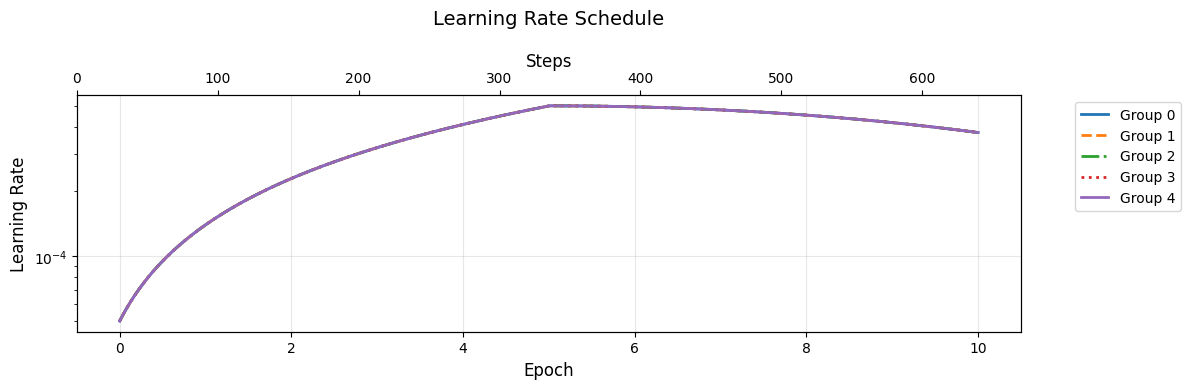

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036431693006306887
abm_loss is 0.0033501770813018084


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   1%| | 1/67 [00:00<00:16,  3.95it/s, batch_accuracy=2.50%, loss=0.0208, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012603789800778031
abm_loss is 0.008722314611077309


Training:   7%| | 5/67 [00:00<00:04, 12.47it/s, batch_accuracy=1.25%, loss=0.0111, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020294138230383396
abm_loss is 0.010827712714672089
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019533950835466385
abm_loss is 0.012368707917630672
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014234005939215422
abm_loss is 0.005448982119560242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018615893786773086
abm_loss is 0.0022892991546541452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:03, 17.25it/s, batch_accuracy=1.25%, loss=0.0153, mae=

mse_loss is 0.0026279857847839594
abm_loss is 0.0027973290998488665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 20.12it/s, batch_accuracy=2.50%, loss=0.0063, mae

mse_loss is 0.002482655458152294
abm_loss is 0.0026310549583286047
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002563968999311328
abm_loss is 0.002020176500082016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012041350128129125
abm_loss is 0.0026502807158976793
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009720410453155637
abm_loss is 0.0019072063732892275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008750209817662835
abm_loss is 0.0011457664659246802


Training:  16%|▏| 11/67 [00:00<00:02, 20.12it/s, batch_accuracy=3.75%, loss=0.0053, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017128012841567397
abm_loss is 0.0051474845968186855


Training:  24%|▏| 16/67 [00:00<00:02, 23.18it/s, batch_accuracy=5.00%, loss=0.0242, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011813140008598566
abm_loss is 0.005843356717377901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010835761204361916
abm_loss is 0.0059966701082885265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016334891552105546
abm_loss is 0.008910352364182472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020303577184677124
abm_loss is 0.01820266619324684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017119309632107615
abm_loss is 0.02459467388689518


Training:  25%|▎| 17/67 [00:00<00:02, 23.18it/s, batch_accuracy=7.50%, loss=0.0275, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013533513993024826
abm_loss is 0.02960248664021492


Training:  33%|▎| 22/67 [00:01<00:01, 24.64it/s, batch_accuracy=18.75%, loss=0.0321, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004710455541498959
abm_loss is 0.021232808008790016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006707622087560594
abm_loss is 0.028380602598190308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000697218463756144
abm_loss is 0.025804871693253517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009466474875807762
abm_loss is 0.03544311597943306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011750496923923492


Training:  34%|▎| 23/67 [00:01<00:01, 24.64it/s, batch_accuracy=20.00%, loss=0.0336, ma

abm_loss is 0.03599315509200096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020951416809111834
abm_loss is 0.029781524091959


Training:  42%|▍| 28/67 [00:01<00:01, 25.26it/s, batch_accuracy=10.00%, loss=0.0465, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022787030320614576
abm_loss is 0.02969069592654705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019322683801874518
abm_loss is 0.044912099838256836
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018173091812059283
abm_loss is 0.048571210354566574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006540059112012386
abm_loss is 0.0914560928940773


Training:  43%|▍| 29/67 [00:01<00:01, 25.26it/s, batch_accuracy=47.50%, loss=0.0857, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005301372148096561
abm_loss is 0.10767219215631485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.50it/s, batch_accuracy=13.75%, loss=0.0556, ma

mse_loss is 0.0027114569675177336
abm_loss is 0.05300452932715416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007423061411827803
abm_loss is 0.01314189750701189
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004665763583034277
abm_loss is 0.028678206726908684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017527200980111957
abm_loss is 0.0607193224132061
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.50it/s, batch_accuracy=13.75%, loss=0.0499, ma

mse_loss is 0.0018945916090160608
abm_loss is 0.05241120979189873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010017638560384512
abm_loss is 0.07154126465320587


Training:  57%|▌| 38/67 [00:01<00:01, 25.53it/s, batch_accuracy=13.75%, loss=0.1946, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006447671330533922
abm_loss is 0.09015857428312302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006373910582624376
abm_loss is 0.13972213864326477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002389368833974004
abm_loss is 0.23688380420207977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00600785855203867
abm_loss is 0.37564465403556824


Training:  60%|▌| 40/67 [00:01<00:01, 25.41it/s, batch_accuracy=10.00%, loss=0.2719, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003883143188431859
abm_loss is 0.32743582129478455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.53it/s, batch_accuracy=0.00%, loss=1.0847, mae

mse_loss is 0.0010260390117764473
abm_loss is 0.23355746269226074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004431727342307568
abm_loss is 0.43220171332359314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011048059910535812
abm_loss is 0.7121290564537048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028275681659579277
abm_loss is 1.2232749462127686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:02<00:00, 25.56it/s, batch_accuracy=0.00%, loss=0.9484, mae

mse_loss is 0.01780165173113346
abm_loss is 1.1146081686019897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01714113913476467
abm_loss is 1.2439212799072266


Training:  73%|▋| 49/67 [00:02<00:00, 25.67it/s, batch_accuracy=27.50%, loss=1.0457, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02314159832894802
abm_loss is 1.5547655820846558
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006699405610561371
abm_loss is 1.212337851524353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006123530678451061
abm_loss is 1.3166258335113525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022052591666579247
abm_loss is 1.209471344947815


Training:  78%|▊| 52/67 [00:02<00:00, 25.68it/s, batch_accuracy=40.00%, loss=1.3266, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005390566773712635
abm_loss is 1.6857012510299683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.71it/s, batch_accuracy=63.75%, loss=1.8493, ma

mse_loss is 0.0038807031232863665
abm_loss is 1.7411001920700073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00325001566670835
abm_loss is 1.5755847692489624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0072531807236373425
abm_loss is 2.316171407699585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0052514830604195595
abm_loss is 2.3645875453948975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.71it/s, batch_accuracy=57.50%, loss=1.6040, ma

mse_loss is 0.006529155652970076
abm_loss is 2.0380730628967285
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015050469897687435
abm_loss is 1.838218331336975


Training:  91%|▉| 61/67 [00:02<00:00, 25.75it/s, batch_accuracy=3.75%, loss=1.3394, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04989541694521904
abm_loss is 1.0913927555084229
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028368372470140457
abm_loss is 1.6636568307876587
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044594015926122665
abm_loss is 1.4477828741073608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07222304493188858
abm_loss is 1.1095691919326782


Training:  93%|▉| 62/67 [00:02<00:00, 25.75it/s, batch_accuracy=0.00%, loss=1.1575, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07888573408126831
abm_loss is 0.9890252947807312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06978514045476913
abm_loss is 1.1403120756149292


Training: 100%|█| 67/67 [00:02<00:00, 25.79it/s, batch_accuracy=54.00%, loss=2.0501, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03835044428706169
abm_loss is 1.5350139141082764
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01754940301179886
abm_loss is 2.041916608810425
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.008551708422601223
abm_loss is 2.603685140609741


Training: 100%|█| 67/67 [00:02<00:00, 23.63it/s, batch_accuracy=54.00%, loss=2.0501, ma



📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.4950 | train_mae: nan | train_accuracy: 16.3602


Training:   3%| | 2/67 [00:00<00:03, 16.86it/s, batch_accuracy=0.00%, loss=1.9958, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.4368440806865692
abm_loss is 0.3825575113296509
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.35486868023872375
abm_loss is 0.28411969542503357
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.31270065903663635
abm_loss is 0.2436339408159256


Training:   7%| | 5/67 [00:00<00:02, 22.04it/s, batch_accuracy=0.00%, loss=0.8629, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.24362342059612274
abm_loss is 0.1826198548078537
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.15458077192306519
abm_loss is 0.11536283791065216
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.1374, mae=

mse_loss is 0.10546493530273438
abm_loss is 0.08324157446622849
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05128652974963188
abm_loss is 0.03399818763136864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024980129674077034
abm_loss is 0.015994546934962273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.76it/s, batch_accuracy=3.75%, loss=0.0190, mae=

mse_loss is 0.009631993249058723
abm_loss is 0.00813582818955183
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003359094960615039
abm_loss is 0.002839274238795042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038725167978554964
abm_loss is 0.005767046473920345


Training:  18%|▏| 12/67 [00:00<00:02, 24.55it/s, batch_accuracy=0.00%, loss=0.0836, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007505706045776606
abm_loss is 0.00930486898869276
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013454071246087551
abm_loss is 0.021004537120461464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024426326155662537
abm_loss is 0.04021098092198372


Training:  22%|▏| 15/67 [00:00<00:02, 25.00it/s, batch_accuracy=0.00%, loss=0.1824, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027553750202059746
abm_loss is 0.044718753546476364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028830511495471
abm_loss is 0.0493723601102829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.21it/s, batch_accuracy=0.00%, loss=0.2240, mae

mse_loss is 0.030432580038905144
abm_loss is 0.06796319782733917
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03283288702368736
abm_loss is 0.08439221978187561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03026728332042694
abm_loss is 0.09402480721473694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.1700, mae

mse_loss is 0.024302450940012932
abm_loss is 0.07875913381576538
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020726501941680908
abm_loss is 0.08589457720518112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01588846556842327
abm_loss is 0.0752764642238617


Training:  34%|▎| 23/67 [00:00<00:01, 25.48it/s, batch_accuracy=0.00%, loss=0.1051, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012827533297240734
abm_loss is 0.08384519070386887
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008888671174645424
abm_loss is 0.07859420031309128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005476833321154118
abm_loss is 0.06684508919715881


Training:  39%|▍| 26/67 [00:01<00:01, 25.59it/s, batch_accuracy=8.75%, loss=0.0679, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004154602065682411
abm_loss is 0.06397467851638794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002390672452747822
abm_loss is 0.072602778673172
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.69it/s, batch_accuracy=21.25%, loss=0.1095, ma

mse_loss is 0.0025700663682073355
abm_loss is 0.07983507961034775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002609503921121359
abm_loss is 0.1154102310538292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002314916579052806
abm_loss is 0.12700942158699036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010258324909955263
abm_loss is 0.06465335190296173


Training:  48%|▍| 32/67 [00:01<00:01, 25.74it/s, batch_accuracy=6.25%, loss=0.0323, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003696900326758623
abm_loss is 0.017854684963822365
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032898138742893934
abm_loss is 0.03415357321500778


Training:  52%|▌| 35/67 [00:01<00:01, 25.79it/s, batch_accuracy=13.75%, loss=0.0655, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00173956248909235
abm_loss is 0.06309390068054199
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031234975904226303
abm_loss is 0.049636360257864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028519933111965656
abm_loss is 0.06646346300840378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020046436693519354
abm_loss is 0.08098030090332031


Training:  57%|▌| 38/67 [00:01<00:01, 25.85it/s, batch_accuracy=28.75%, loss=0.1018, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014324834337458014
abm_loss is 0.12276997417211533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008922146516852081
abm_loss is 0.2108508199453354


Training:  61%|▌| 41/67 [00:01<00:01, 25.87it/s, batch_accuracy=43.75%, loss=0.1791, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031108360271900892
abm_loss is 0.3432175815105438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00224155280739069
abm_loss is 0.29098889231681824
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011237675789743662
abm_loss is 0.22497621178627014
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.84it/s, batch_accuracy=2.50%, loss=0.6000, mae

mse_loss is 0.003121133428066969
abm_loss is 0.4155871868133545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011471663601696491
abm_loss is 0.7037537693977356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.1755, mae

mse_loss is 0.03105863370001316
abm_loss is 1.2694971561431885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02614033780992031
abm_loss is 1.1576502323150635
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02994411066174507
abm_loss is 1.3302046060562134
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04151047021150589
abm_loss is 1.6963452100753784


Training:  72%|▋| 48/67 [00:01<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.1543, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02205822803080082
abm_loss is 1.3539351224899292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024972349405288696
abm_loss is 1.5011438131332397


Training:  79%|▊| 53/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.7504, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017713574692606926
abm_loss is 1.417315125465393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03238719329237938
abm_loss is 1.9544620513916016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03142089396715164
abm_loss is 2.0663628578186035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021349092945456505
abm_loss is 1.9276618957519531


Training:  81%|▊| 54/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=2.3378, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04295008257031441
abm_loss is 2.753370761871338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=76.25%, loss=1.1588, ma

mse_loss is 0.03869427368044853
abm_loss is 2.835334300994873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02573465369641781
abm_loss is 2.538294553756714
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012778651900589466
abm_loss is 2.23193621635437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001732662320137024
abm_loss is 1.4918732643127441
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=48.75%, loss=1.6332, ma

mse_loss is 0.005551036447286606
abm_loss is 2.0824036598205566
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030862384010106325
abm_loss is 1.941794991493225


Training:  94%|▉| 63/67 [00:02<00:00, 25.84it/s, batch_accuracy=18.75%, loss=1.1471, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0041222358122467995
abm_loss is 1.5002803802490234
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011313244700431824
abm_loss is 1.269938349723816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012399028055369854
abm_loss is 1.4074252843856812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006784842815250158
abm_loss is 1.762207269668579


Training:  97%|▉| 65/67 [00:02<00:00, 25.90it/s, batch_accuracy=72.50%, loss=1.7098, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003367975354194641
abm_loss is 2.1959526538848877
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0025470079854130745
abm_loss is 2.6959078311920166


Training: 100%|█| 67/67 [00:02<00:00, 25.26it/s, batch_accuracy=82.00%, loss=2.0912, ma



📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.7280 | train_mae: nan | train_accuracy: 12.8705


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.420187771320343
abm_loss is 0.3678889274597168


Training:   3%| | 2/67 [00:00<00:03, 16.76it/s, batch_accuracy=0.00%, loss=2.3722, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.420793741941452
abm_loss is 0.3442502021789551
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.41656753420829773
abm_loss is 0.33776575326919556


Training:   7%| | 5/67 [00:00<00:02, 21.93it/s, batch_accuracy=0.00%, loss=2.1903, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.40418997406959534
abm_loss is 0.32558903098106384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.38719791173934937
abm_loss is 0.32645997405052185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.93it/s, batch_accuracy=0.00%, loss=2.1775, mae=

mse_loss is 0.3829844892024994
abm_loss is 0.3371935784816742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.61it/s, batch_accuracy=0.00%, loss=1.9270, mae=

mse_loss is 0.3464090824127197
abm_loss is 0.2952919602394104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.3390223979949951
abm_loss is 0.2978884279727936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.61it/s, batch_accuracy=0.00%, loss=1.6098, mae=

mse_loss is 0.3127717673778534
abm_loss is 0.3016895353794098
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.2824821174144745
abm_loss is 0.25357043743133545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.26929962635040283
abm_loss is 0.25327813625335693


Training:  16%|▏| 11/67 [00:00<00:02, 24.49it/s, batch_accuracy=0.00%, loss=1.5436, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.2383064329624176
abm_loss is 0.2265440970659256


Training:  18%|▏| 12/67 [00:00<00:02, 24.49it/s, batch_accuracy=0.00%, loss=1.2048, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.2119227647781372
abm_loss is 0.18647348880767822
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.17683811485767365
abm_loss is 0.14426158368587494


Training:  22%|▏| 15/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.7805, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1592901200056076
abm_loss is 0.1268327683210373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13962171971797943
abm_loss is 0.10566025972366333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.14it/s, batch_accuracy=0.00%, loss=0.6053, mae

mse_loss is 0.11040244251489639
abm_loss is 0.06814141571521759
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.14it/s, batch_accuracy=0.00%, loss=0.3981, mae

mse_loss is 0.09075285494327545
abm_loss is 0.04436365142464638
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07475271821022034
abm_loss is 0.0309396181255579
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=0.00%, loss=0.2604, mae

mse_loss is 0.0631440132856369
abm_loss is 0.026280198246240616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.049330826848745346
abm_loss is 0.01743956468999386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040570925921201706
abm_loss is 0.014386775903403759


Training:  31%|▎| 21/67 [00:00<00:01, 25.37it/s, batch_accuracy=0.00%, loss=0.2142, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02910507656633854
abm_loss is 0.013802766799926758


Training:  34%|▎| 23/67 [00:00<00:01, 25.51it/s, batch_accuracy=0.00%, loss=0.1173, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021060124039649963
abm_loss is 0.015382999554276466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01805708557367325
abm_loss is 0.015567208640277386


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0648, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013149973936378956
abm_loss is 0.017685750499367714
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008416014723479748
abm_loss is 0.02938912622630596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0052698575891554356
abm_loss is 0.03813361003994942


Training:  40%|▍| 27/67 [00:01<00:01, 25.64it/s, batch_accuracy=1.25%, loss=0.0558, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.67it/s, batch_accuracy=28.75%, loss=0.0820, ma

mse_loss is 0.0016904715448617935
abm_loss is 0.08135812729597092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007791451062075794
abm_loss is 0.10136621445417404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.73it/s, batch_accuracy=13.75%, loss=0.0394, ma

mse_loss is 0.001299520255997777
abm_loss is 0.060533370822668076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031666960567235947
abm_loss is 0.01815692149102688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020451731979846954
abm_loss is 0.03781355172395706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000727760256268084
abm_loss is 0.07811006903648376


Training:  52%|▌| 35/67 [00:01<00:01, 25.73it/s, batch_accuracy=26.25%, loss=0.0562, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007873899303376675
abm_loss is 0.0677541047334671
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013165908167138696
abm_loss is 0.09532856196165085


Training:  57%|▌| 38/67 [00:01<00:01, 25.76it/s, batch_accuracy=3.75%, loss=0.1613, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017446723068132997
abm_loss is 0.11103615909814835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004894693847745657
abm_loss is 0.17737743258476257
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008575132116675377
abm_loss is 0.2724950909614563


Training:  57%|▌| 38/67 [00:01<00:01, 25.76it/s, batch_accuracy=0.00%, loss=0.2530, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.74it/s, batch_accuracy=2.50%, loss=0.3797, mae

mse_loss is 0.01962781697511673
abm_loss is 0.4446263313293457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015410740859806538
abm_loss is 0.3924156129360199
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.76it/s, batch_accuracy=0.00%, loss=0.8768, mae

mse_loss is 0.009958586655557156
abm_loss is 0.3032734990119934
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02517392672598362
abm_loss is 0.5482802391052246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04285164177417755
abm_loss is 0.8590090870857239
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07958856970071793
abm_loss is 1.4546364545822144


Training:  67%|▋| 45/67 [00:01<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.4366, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07155626267194748
abm_loss is 1.3986703157424927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07758456468582153
abm_loss is 1.537103533744812


Training:  72%|▋| 48/67 [00:01<00:00, 25.78it/s, batch_accuracy=0.00%, loss=1.5783, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09582623094320297
abm_loss is 1.9595712423324585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06956584751605988
abm_loss is 1.5953954458236694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07410569489002228
abm_loss is 1.764250636100769


Training:  75%|▋| 50/67 [00:01<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.7312, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.2190, mae

mse_loss is 0.0630841851234436
abm_loss is 1.6627815961837769
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09327580034732819
abm_loss is 2.2724978923797607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09295163303613663
abm_loss is 2.394907236099243


Training:  81%|▊| 54/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=3.1181, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08025393635034561
abm_loss is 2.276918888092041
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12759733200073242
abm_loss is 3.2157704830169678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12667201459407806
abm_loss is 3.3276939392089844


Training:  85%|▊| 57/67 [00:02<00:00, 25.88it/s, batch_accuracy=0.00%, loss=2.5400, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1004684790968895
abm_loss is 3.0237929821014404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08095297962427139
abm_loss is 2.768949508666992
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036382343620061874
abm_loss is 1.897507905960083


Training:  90%|▉| 60/67 [00:02<00:00, 25.89it/s, batch_accuracy=0.00%, loss=2.1319, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06279043108224869
abm_loss is 2.567662000656128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05023038014769554
abm_loss is 2.4390952587127686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02717111073434353
abm_loss is 1.924079179763794


Training:  94%|▉| 63/67 [00:02<00:00, 25.91it/s, batch_accuracy=2.50%, loss=1.5454, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01709316484630108
abm_loss is 1.7095524072647095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019968412816524506
abm_loss is 1.874826431274414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02958609163761139
abm_loss is 2.307044744491577


Training:  99%|▉| 66/67 [00:02<00:00, 26.05it/s, batch_accuracy=0.00%, loss=2.9564, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043795980513095856
abm_loss is 2.8242461681365967
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.06336048990488052
abm_loss is 3.423215627670288


Training: 100%|█| 67/67 [00:02<00:00, 25.27it/s, batch_accuracy=0.00%, loss=2.9564, mae



📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 1.2134 | train_mae: nan | train_accuracy: 3.1707


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.16185076534748077
abm_loss is 0.12971965968608856


Training:   3%| | 2/67 [00:00<00:03, 16.85it/s, batch_accuracy=0.00%, loss=0.9212, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.16547803580760956
abm_loss is 0.12027790397405624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1723240613937378
abm_loss is 0.12342845648527145


Training:   7%| | 5/67 [00:00<00:02, 21.98it/s, batch_accuracy=0.00%, loss=1.0015, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.18075160682201385
abm_loss is 0.1308165341615677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.17869023978710175
abm_loss is 0.13853295147418976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.98it/s, batch_accuracy=0.00%, loss=1.0787, mae=

mse_loss is 0.19098840653896332
abm_loss is 0.15891240537166595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=1.0332, mae=

mse_loss is 0.1825477033853531
abm_loss is 0.14533770084381104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1828131526708603
abm_loss is 0.1529850959777832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.9963, mae=

mse_loss is 0.18504598736763
abm_loss is 0.17634104192256927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.17540402710437775
abm_loss is 0.15320971608161926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.17422115802764893
abm_loss is 0.16213750839233398


Training:  16%|▏| 11/67 [00:00<00:02, 24.45it/s, batch_accuracy=0.00%, loss=0.9973, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.16890336573123932
abm_loss is 0.1591886729001999


Training:  18%|▏| 12/67 [00:00<00:02, 24.45it/s, batch_accuracy=0.00%, loss=0.8532, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.15045538544654846
abm_loss is 0.12957513332366943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13705800473690033
abm_loss is 0.10825125128030777


Training:  22%|▏| 15/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.6826, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13146549463272095
abm_loss is 0.1023728996515274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1223251223564148
abm_loss is 0.09093724936246872
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.5610, mae

mse_loss is 0.1024048700928688
abm_loss is 0.06263456493616104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.4152, mae

mse_loss is 0.0920703113079071
abm_loss is 0.04598769173026085
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07788942009210587
abm_loss is 0.03271634504199028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07441291213035583
abm_loss is 0.031712062656879425


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=0.00%, loss=0.3440, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06505083292722702
abm_loss is 0.023755472153425217
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05989798903465271
abm_loss is 0.021182609722018242


Training:  31%|▎| 21/67 [00:00<00:01, 25.45it/s, batch_accuracy=0.00%, loss=0.3162, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04963219165802002
abm_loss is 0.016733307391405106


Training:  36%|▎| 24/67 [00:01<00:01, 25.54it/s, batch_accuracy=0.00%, loss=0.2155, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04259452596306801
abm_loss is 0.016392936930060387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040746621787548065
abm_loss is 0.014941182918846607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.1579, mae

mse_loss is 0.03560228645801544
abm_loss is 0.014954742975533009
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02863898314535618
abm_loss is 0.018798978999257088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.1367, mae

mse_loss is 0.023650353774428368
abm_loss is 0.023679673671722412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.1060, mae

mse_loss is 0.01582552306354046
abm_loss is 0.04894893243908882
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011065387167036533
abm_loss is 0.0655832588672638
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017832329496741295
abm_loss is 0.032403185963630676


Training:  48%|▍| 32/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.1248, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023266321048140526
abm_loss is 0.010844835080206394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017722025513648987
abm_loss is 0.01856655813753605


Training:  48%|▍| 32/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.1030, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010336540639400482
abm_loss is 0.03952750936150551


Training:  52%|▌| 35/67 [00:01<00:01, 25.72it/s, batch_accuracy=1.25%, loss=0.0782, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011253532953560352
abm_loss is 0.034457117319107056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007705856114625931
abm_loss is 0.051404234021902084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.78it/s, batch_accuracy=5.00%, loss=0.0960, mae

mse_loss is 0.005646705161780119
abm_loss is 0.0628177747130394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002440763870254159
abm_loss is 0.10871487110853195
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.78it/s, batch_accuracy=72.50%, loss=0.1565, ma

mse_loss is 0.00035680769360624254
abm_loss is 0.20070676505565643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.73it/s, batch_accuracy=28.75%, loss=0.2373, ma

mse_loss is 0.0018536454299464822
abm_loss is 0.33336201310157776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00204521045088768
abm_loss is 0.29448792338371277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008246636134572327
abm_loss is 0.22440031170845032


Training:  63%|▋| 42/67 [00:01<00:00, 25.73it/s, batch_accuracy=3.75%, loss=0.3710, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005545543972402811
abm_loss is 0.44514843821525574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018699798732995987
abm_loss is 0.7674782872200012


Training:  66%|▋| 44/67 [00:01<00:00, 25.66it/s, batch_accuracy=0.00%, loss=0.6853, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048891108483076096
abm_loss is 1.3425403833389282


Training:  70%|▋| 47/67 [00:01<00:00, 25.62it/s, batch_accuracy=0.00%, loss=1.3777, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042508553713560104
abm_loss is 1.2465473413467407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05222484469413757
abm_loss is 1.4479056596755981
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.62it/s, batch_accuracy=0.00%, loss=1.4531, mae

mse_loss is 0.07708166539669037
abm_loss is 1.8713620901107788
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05461740493774414
abm_loss is 1.5301483869552612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.66it/s, batch_accuracy=0.00%, loss=1.6069, mae

mse_loss is 0.06006082519888878
abm_loss is 1.694273591041565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.66it/s, batch_accuracy=0.00%, loss=2.1599, mae

mse_loss is 0.05619361996650696
abm_loss is 1.640822410583496
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08636396378278732
abm_loss is 2.2407679557800293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09116175025701523
abm_loss is 2.4045937061309814


Training:  79%|▊| 53/67 [00:02<00:00, 25.73it/s, batch_accuracy=0.00%, loss=2.1625, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08126509189605713
abm_loss is 2.2771618366241455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12941928207874298
abm_loss is 3.1752188205718994


Training:  81%|▊| 54/67 [00:02<00:00, 25.73it/s, batch_accuracy=0.00%, loss=3.0959, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13268940150737762
abm_loss is 3.3686962127685547


Training:  85%|▊| 57/67 [00:02<00:00, 25.75it/s, batch_accuracy=0.00%, loss=2.6356, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10888157039880753
abm_loss is 3.0861635208129883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09061994403600693
abm_loss is 2.830061674118042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=2.4263, mae

mse_loss is 0.045226048678159714
abm_loss is 1.959734320640564
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07590959221124649
abm_loss is 2.654209613800049
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=2.2286, mae

mse_loss is 0.06293651461601257
abm_loss is 2.481924533843994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.5528, mae

mse_loss is 0.039663542062044144
abm_loss is 2.0656678676605225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02938615158200264
abm_loss is 1.8232253789901733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032280027866363525
abm_loss is 1.9883521795272827


Training:  97%|▉| 65/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.0985, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04552252218127251
abm_loss is 2.426270008087158
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06476443260908127
abm_loss is 2.995328187942505


Training:  97%|▉| 65/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.6335, mae

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.09003394842147827
abm_loss is 3.569455862045288


Training: 100%|█| 67/67 [00:02<00:00, 25.18it/s, batch_accuracy=0.00%, loss=3.2027, mae



📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 1.0293 | train_mae: nan | train_accuracy: 2.7580


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.6936, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1237533837556839
abm_loss is 0.0959910973906517


Training:   3%| | 2/67 [00:00<00:03, 16.86it/s, batch_accuracy=0.00%, loss=0.6730, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12158123403787613
abm_loss is 0.08340772241353989
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12608346343040466
abm_loss is 0.0855361744761467


Training:   7%| | 5/67 [00:00<00:02, 22.14it/s, batch_accuracy=0.00%, loss=0.7369, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12435107678174973
abm_loss is 0.08387286216020584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1320739984512329
abm_loss is 0.09816314280033112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.14it/s, batch_accuracy=0.00%, loss=0.7907, mae=

mse_loss is 0.1404317319393158
abm_loss is 0.11362450569868088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.7789, mae=

mse_loss is 0.136210098862648
abm_loss is 0.10538804531097412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13814519345760345
abm_loss is 0.11322041600942612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.7779, mae=

mse_loss is 0.1471952497959137
abm_loss is 0.13947229087352753
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1372160166501999
abm_loss is 0.1179129108786583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1405966728925705
abm_loss is 0.1297273188829422


Training:  16%|▏| 11/67 [00:00<00:02, 24.62it/s, batch_accuracy=0.00%, loss=0.8039, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13211916387081146
abm_loss is 0.12338689714670181


Training:  18%|▏| 12/67 [00:00<00:02, 24.62it/s, batch_accuracy=0.00%, loss=0.7084, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1251414567232132
abm_loss is 0.10618572682142258
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11765702068805695
abm_loss is 0.09122512489557266


Training:  22%|▏| 15/67 [00:00<00:02, 25.03it/s, batch_accuracy=0.00%, loss=0.5785, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10957839339971542
abm_loss is 0.08337116241455078
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10388872772455215
abm_loss is 0.0757189393043518
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.4896, mae

mse_loss is 0.08974000066518784
abm_loss is 0.05220918729901314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.3776, mae

mse_loss is 0.07911044359207153
abm_loss is 0.03752664476633072
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07089690119028091
abm_loss is 0.029382437467575073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.3076, mae

mse_loss is 0.06525924056768417
abm_loss is 0.026956230401992798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.058196019381284714
abm_loss is 0.02101254276931286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05381426960229874
abm_loss is 0.018198901787400246


Training:  31%|▎| 21/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.2835, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04424829035997391
abm_loss is 0.015664303675293922


Training:  34%|▎| 23/67 [00:00<00:01, 25.47it/s, batch_accuracy=0.00%, loss=0.2108, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03969428315758705
abm_loss is 0.015667175874114037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03899340704083443
abm_loss is 0.015570874325931072


Training:  39%|▍| 26/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.1572, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03464433178305626
abm_loss is 0.014375278726220131
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028194556012749672
abm_loss is 0.020861802622675896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024355581030249596
abm_loss is 0.02353472076356411


Training:  40%|▍| 27/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.1401, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016275087371468544
abm_loss is 0.04783359169960022


Training:  43%|▍| 29/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.1102, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012721075676381588
abm_loss is 0.060307323932647705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.1112, mae

mse_loss is 0.018249256536364555
abm_loss is 0.033415865153074265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023898689076304436
abm_loss is 0.010386190377175808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019616736099123955
abm_loss is 0.01689554564654827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0889, mae

mse_loss is 0.011472380720078945
abm_loss is 0.040872156620025635
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.0837, mae

mse_loss is 0.01148964837193489
abm_loss is 0.033928681164979935
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008574421517550945
abm_loss is 0.050194282084703445


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=6.25%, loss=0.0962, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007384897209703922
abm_loss is 0.061360981315374374
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026929278392344713
abm_loss is 0.10730049759149551
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006235709297470748
abm_loss is 0.19031792879104614


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=47.50%, loss=0.1498, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012732403120025992
abm_loss is 0.3313475549221039


Training:  61%|▌| 41/67 [00:01<00:01, 25.77it/s, batch_accuracy=30.00%, loss=0.2315, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016146320849657059
abm_loss is 0.28982874751091003
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.80it/s, batch_accuracy=0.00%, loss=0.6556, mae

mse_loss is 0.0007003503851592541
abm_loss is 0.22715850174427032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004050238523632288
abm_loss is 0.43647298216819763
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015615971758961678
abm_loss is 0.7490081191062927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.2293, mae

mse_loss is 0.041744980961084366
abm_loss is 1.3233842849731445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03721177577972412
abm_loss is 1.219700574874878


Training:  67%|▋| 45/67 [00:01<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.1266, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04715346917510033
abm_loss is 1.4301856756210327


Training:  72%|▋| 48/67 [00:01<00:00, 25.82it/s, batch_accuracy=0.00%, loss=1.3941, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07240375131368637
abm_loss is 1.8365026712417603
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04897624999284744
abm_loss is 1.4902464151382446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05917114019393921
abm_loss is 1.6870163679122925


Training:  75%|▋| 50/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.5057, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.052073221653699875
abm_loss is 1.614885926246643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.1518, mae

mse_loss is 0.08374574035406113
abm_loss is 2.2472240924835205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.77it/s, batch_accuracy=0.00%, loss=3.0779, mae

mse_loss is 0.08759337663650513
abm_loss is 2.3869881629943848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07650791853666306
abm_loss is 2.2384541034698486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1281713843345642
abm_loss is 3.1600005626678467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=3.2436, mae

mse_loss is 0.1308441013097763
abm_loss is 3.3574981689453125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10842917114496231
abm_loss is 3.068058490753174


Training:  84%|▊| 56/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.9082, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09037935733795166
abm_loss is 2.8145482540130615


Training:  88%|▉| 59/67 [00:02<00:00, 25.83it/s, batch_accuracy=0.00%, loss=2.4204, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045599933713674545
abm_loss is 1.9516032934188843
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0760636180639267
abm_loss is 2.6454765796661377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06384069472551346
abm_loss is 2.4764931201934814


Training:  93%|▉| 62/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.7735, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039764903485774994
abm_loss is 2.042207956314087
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02826692722737789
abm_loss is 1.8005701303482056


Training:  93%|▉| 62/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.5297, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03187326341867447
abm_loss is 1.9900387525558472


Training:  97%|▉| 65/67 [00:02<00:00, 26.00it/s, batch_accuracy=0.00%, loss=2.6365, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04482107609510422
abm_loss is 2.4118144512176514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06778433173894882
abm_loss is 2.979588031768799
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.09094353765249252
abm_loss is 3.6075918674468994


Training: 100%|█| 67/67 [00:02<00:00, 25.27it/s, batch_accuracy=0.00%, loss=3.2366, mae



📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.9646 | train_mae: nan | train_accuracy: 2.6266


Training:   3%| | 2/67 [00:00<00:03, 16.55it/s, batch_accuracy=0.00%, loss=0.6111, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11322738975286484
abm_loss is 0.08716215193271637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11065882444381714
abm_loss is 0.07397885620594025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11672114580869675
abm_loss is 0.07827045768499374


Training:   7%| | 5/67 [00:00<00:02, 21.92it/s, batch_accuracy=0.00%, loss=0.6858, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11947774142026901
abm_loss is 0.07985633611679077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12310536205768585
abm_loss is 0.09001567959785461


Training:  12%| | 8/67 [00:00<00:02, 23.67it/s, batch_accuracy=0.00%, loss=0.7314, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13257861137390137
abm_loss is 0.10752294212579727
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12912167608737946
abm_loss is 0.09794953465461731
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.129736065864563
abm_loss is 0.10612304508686066
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.67it/s, batch_accuracy=0.00%, loss=0.7377, mae=

mse_loss is 0.1393449306488037
abm_loss is 0.1312175989151001
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13015441596508026
abm_loss is 0.11156100034713745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.44it/s, batch_accuracy=0.00%, loss=0.6908, mae

mse_loss is 0.1287391483783722
abm_loss is 0.1184839978814125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12979371845722198
abm_loss is 0.1210346445441246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12206953763961792
abm_loss is 0.10330919176340103
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11251380294561386
abm_loss is 0.08720041811466217


Training:  21%|▏| 14/67 [00:00<00:02, 24.96it/s, batch_accuracy=0.00%, loss=0.6021, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10771805047988892
abm_loss is 0.08145396411418915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09995349496603012
abm_loss is 0.07216934114694595


Training:  27%|▎| 18/67 [00:00<00:01, 25.25it/s, batch_accuracy=0.00%, loss=0.3698, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08910432457923889
abm_loss is 0.05179046466946602
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0782645046710968
abm_loss is 0.03677015379071236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06956552714109421
abm_loss is 0.027901440858840942
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06626381725072861
abm_loss is 0.026972780004143715


Training:  30%|▎| 20/67 [00:00<00:01, 25.49it/s, batch_accuracy=0.00%, loss=0.3137, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05939371511340141
abm_loss is 0.021152475848793983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.055682308971881866
abm_loss is 0.01996857486665249


Training:  36%|▎| 24/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.2012, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04673660546541214
abm_loss is 0.017101434990763664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0415918193757534
abm_loss is 0.015573053620755672
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03793478012084961
abm_loss is 0.014667190611362457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03629394248127937
abm_loss is 0.014899267815053463


Training:  39%|▍| 26/67 [00:01<00:01, 25.72it/s, batch_accuracy=0.00%, loss=0.1656, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02977619133889675
abm_loss is 0.021403107792139053
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0256922896951437
abm_loss is 0.023201793432235718


Training:  45%|▍| 30/67 [00:01<00:01, 25.79it/s, batch_accuracy=0.00%, loss=0.1136, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01740783452987671
abm_loss is 0.0481085442006588
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013706410303711891
abm_loss is 0.059350352734327316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017921581864356995
abm_loss is 0.03102087415754795
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026034165173768997
abm_loss is 0.010279231704771519


Training:  48%|▍| 32/67 [00:01<00:01, 25.88it/s, batch_accuracy=0.00%, loss=0.1129, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01995856873691082
abm_loss is 0.01685466431081295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012458679266273975
abm_loss is 0.03870784118771553


Training:  54%|▌| 36/67 [00:01<00:01, 25.88it/s, batch_accuracy=0.00%, loss=0.0835, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013232982717454433
abm_loss is 0.032668307423591614
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009621587581932545
abm_loss is 0.0471084825694561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007519432809203863
abm_loss is 0.05951378494501114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003640036331489682
abm_loss is 0.10242538899183273


Training:  57%|▌| 38/67 [00:01<00:01, 25.91it/s, batch_accuracy=52.50%, loss=0.1489, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000575589423533529
abm_loss is 0.1893385499715805
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010966837871819735
abm_loss is 0.32688388228416443


Training:  63%|▋| 42/67 [00:01<00:00, 25.88it/s, batch_accuracy=8.75%, loss=0.3405, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011831664014607668
abm_loss is 0.28515323996543884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005892200279049575
abm_loss is 0.21949036419391632
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003102883230894804
abm_loss is 0.42148658633232117
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.2018, mae

mse_loss is 0.014051074162125587
abm_loss is 0.7437857985496521
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04041045531630516
abm_loss is 1.2964274883270264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.77it/s, batch_accuracy=0.00%, loss=1.7189, mae

mse_loss is 0.03615226224064827
abm_loss is 1.2139558792114258
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044933635741472244
abm_loss is 1.4071197509765625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06404012441635132
abm_loss is 1.813629150390625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04761427268385887
abm_loss is 1.5003670454025269


Training:  75%|▋| 50/67 [00:01<00:00, 25.78it/s, batch_accuracy=0.00%, loss=1.5839, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.056197043508291245
abm_loss is 1.6894992589950562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048726342618465424
abm_loss is 1.6065151691436768


Training:  79%|▊| 53/67 [00:02<00:00, 25.72it/s, batch_accuracy=0.00%, loss=2.0871, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07672075182199478
abm_loss is 2.206425428390503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08288577198982239
abm_loss is 2.3526313304901123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0729772076010704
abm_loss is 2.2332746982574463
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.74it/s, batch_accuracy=0.00%, loss=3.1957, mae

mse_loss is 0.12149006128311157
abm_loss is 3.180682897567749
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12557433545589447
abm_loss is 3.3296730518341064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.7026, mae

mse_loss is 0.10626866668462753
abm_loss is 3.018484115600586
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08867847919464111
abm_loss is 2.8078503608703613
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043844934552907944
abm_loss is 1.9237295389175415
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07159876823425293
abm_loss is 2.6239631175994873


Training:  90%|▉| 60/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=2.2069, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.060618817806243896
abm_loss is 2.4689273834228516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03861791267991066
abm_loss is 2.038351058959961


Training:  97%|▉| 65/67 [00:02<00:00, 26.00it/s, batch_accuracy=0.00%, loss=2.0752, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028267160058021545
abm_loss is 1.784218430519104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031859852373600006
abm_loss is 1.9671986103057861
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04390260577201843
abm_loss is 2.406576633453369
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06490050256252289
abm_loss is 2.9790196418762207


Training:  99%|▉| 66/67 [00:02<00:00, 26.00it/s, batch_accuracy=0.00%, loss=3.1581, mae

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.08605930209159851
abm_loss is 3.537506580352783


Training: 100%|█| 67/67 [00:02<00:00, 25.28it/s, batch_accuracy=0.00%, loss=3.1581, mae



📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.9461 | train_mae: nan | train_accuracy: 2.7955


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.6195, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11051278561353683
abm_loss is 0.08580373972654343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.74it/s, batch_accuracy=0.00%, loss=0.5992, mae=

mse_loss is 0.10849287360906601
abm_loss is 0.07261042296886444
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10992180556058884
abm_loss is 0.07289282232522964


Training:   7%| | 5/67 [00:00<00:02, 22.02it/s, batch_accuracy=0.00%, loss=0.6764, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11414077132940292
abm_loss is 0.07525835931301117
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12142127007246017
abm_loss is 0.08877524733543396
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.02it/s, batch_accuracy=0.00%, loss=0.7271, mae=

mse_loss is 0.1291147917509079
abm_loss is 0.10457601398229599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12501132488250732
abm_loss is 0.09553545713424683


Training:  12%| | 8/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.7170, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12724192440509796
abm_loss is 0.10367589443922043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13491208851337433
abm_loss is 0.1267910748720169


Training:  13%|▏| 9/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.7192, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1269480288028717
abm_loss is 0.10849957913160324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1294422596693039
abm_loss is 0.11890008300542831


Training:  16%|▏| 11/67 [00:00<00:02, 24.59it/s, batch_accuracy=0.00%, loss=0.7322, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12783800065517426
abm_loss is 0.11948966234922409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11656828969717026
abm_loss is 0.09819334000349045


Training:  21%|▏| 14/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.6042, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10777967423200607
abm_loss is 0.08375753462314606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.5587, mae

mse_loss is 0.10477592051029205
abm_loss is 0.07916270196437836
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10044119507074356
abm_loss is 0.07235699146986008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.26it/s, batch_accuracy=0.00%, loss=0.3996, mae

mse_loss is 0.08636539429426193
abm_loss is 0.0500129871070385
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07450703531503677
abm_loss is 0.03439806401729584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.26it/s, batch_accuracy=0.00%, loss=0.3536, mae

mse_loss is 0.0664178803563118
abm_loss is 0.02727033756673336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06431439518928528
abm_loss is 0.025983039289712906


Training:  30%|▎| 20/67 [00:00<00:01, 25.40it/s, batch_accuracy=0.00%, loss=0.2894, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05481211096048355
abm_loss is 0.01945047453045845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050966646522283554
abm_loss is 0.017691267654299736


Training:  34%|▎| 23/67 [00:00<00:01, 25.52it/s, batch_accuracy=0.00%, loss=0.2316, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04378114640712738
abm_loss is 0.016089370474219322
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03958651050925255
abm_loss is 0.01544654555618763


Training:  36%|▎| 24/67 [00:01<00:01, 25.52it/s, batch_accuracy=0.00%, loss=0.2048, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03864026814699173
abm_loss is 0.014649966731667519
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.1556, mae

mse_loss is 0.034398049116134644
abm_loss is 0.014206918887794018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027833987027406693
abm_loss is 0.021015144884586334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.1195, mae

mse_loss is 0.023922542110085487
abm_loss is 0.023491427302360535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016436411067843437
abm_loss is 0.048298221081495285
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.1103, mae

mse_loss is 0.012552926316857338
abm_loss is 0.06158362701535225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01915636472404003
abm_loss is 0.031199727207422256


Training:  48%|▍| 32/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.1405, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02639228105545044
abm_loss is 0.010787921957671642
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01993049494922161
abm_loss is 0.01755535788834095


Training:  49%|▍| 33/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0912, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012409753166139126
abm_loss is 0.03772836923599243
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013420188799500465
abm_loss is 0.03140861913561821


Training:  52%|▌| 35/67 [00:01<00:01, 25.70it/s, batch_accuracy=0.00%, loss=0.0832, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009149164892733097
abm_loss is 0.0485285148024559
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=1.25%, loss=0.0967, mae

mse_loss is 0.007124830037355423
abm_loss is 0.060851793736219406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004125256557017565
abm_loss is 0.09868527203798294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  58%|▌| 39/67 [00:01<00:01, 25.71it/s, batch_accuracy=42.50%, loss=0.2553, ma

mse_loss is 0.0007848282693885267
abm_loss is 0.18715469539165497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008811405277810991
abm_loss is 0.3254377543926239
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.72it/s, batch_accuracy=43.75%, loss=0.2183, ma

mse_loss is 0.0010911443969234824
abm_loss is 0.27603453397750854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007174612837843597
abm_loss is 0.21126675605773926


Training:  63%|▋| 42/67 [00:01<00:00, 25.72it/s, batch_accuracy=10.00%, loss=0.3442, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030843042768538
abm_loss is 0.42647162079811096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012670737691223621
abm_loss is 0.7175397276878357


Training:  66%|▋| 44/67 [00:01<00:00, 25.72it/s, batch_accuracy=0.00%, loss=1.1517, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036683157086372375
abm_loss is 1.255626916885376
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03298591449856758
abm_loss is 1.2152694463729858


Training:  70%|▋| 47/67 [00:01<00:00, 25.72it/s, batch_accuracy=0.00%, loss=1.2861, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.041958123445510864
abm_loss is 1.3956972360610962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.72it/s, batch_accuracy=0.00%, loss=1.3785, mae

mse_loss is 0.06026628240942955
abm_loss is 1.7857292890548706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04537263140082359
abm_loss is 1.4933345317840576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.70it/s, batch_accuracy=0.00%, loss=1.4604, mae

mse_loss is 0.053153373301029205
abm_loss is 1.6743805408477783
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04603366181254387
abm_loss is 1.5952622890472412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.70it/s, batch_accuracy=0.00%, loss=2.0734, mae

mse_loss is 0.07537082582712173
abm_loss is 2.199925422668457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07850132137537003
abm_loss is 2.3589651584625244


Training:  79%|▊| 53/67 [00:02<00:00, 25.72it/s, batch_accuracy=0.00%, loss=2.0812, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07055705785751343
abm_loss is 2.2412402629852295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11586608737707138
abm_loss is 3.1597392559051514


Training:  84%|▊| 56/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=3.1366, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12046580761671066
abm_loss is 3.2861716747283936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09982407093048096
abm_loss is 2.994684934616089


Training:  85%|▊| 57/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=2.5360, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08290541917085648
abm_loss is 2.751072645187378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.69it/s, batch_accuracy=0.00%, loss=2.3314, mae

mse_loss is 0.04049650579690933
abm_loss is 1.9066969156265259
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06699107587337494
abm_loss is 2.5890088081359863
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.7166, mae

mse_loss is 0.056266140192747116
abm_loss is 2.447265386581421
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034264400601387024
abm_loss is 2.0040271282196045
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.4997, mae

mse_loss is 0.025126857683062553
abm_loss is 1.7821285724639893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027606645599007607
abm_loss is 1.9562759399414062


Training:  97%|▉| 65/67 [00:02<00:00, 25.90it/s, batch_accuracy=0.00%, loss=2.0429, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04114902764558792
abm_loss is 2.382585287094116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05788401886820793
abm_loss is 2.9382436275482178


Training: 100%|█| 67/67 [00:02<00:00, 25.21it/s, batch_accuracy=0.00%, loss=3.0954, mae

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.07708455622196198
abm_loss is 3.514418363571167

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.9266 | train_mae: nan | train_accuracy: 2.8518



Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.6040, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10791242122650146
abm_loss is 0.08266931027173996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.03it/s, batch_accuracy=0.00%, loss=0.6769, mae=

mse_loss is 0.10825594514608383
abm_loss is 0.07189559191465378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11263493448495865
abm_loss is 0.07476519793272018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11600573360919952
abm_loss is 0.07682708650827408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12146587669849396
abm_loss is 0.0892205610871315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.03it/s, batch_accuracy=0.00%, loss=0.7239, mae=

mse_loss is 0.12865598499774933
abm_loss is 0.10342426598072052
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12369437515735626
abm_loss is 0.0941595584154129


Training:  13%|▏| 9/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.7064, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12466295808553696
abm_loss is 0.10107486695051193
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1281651109457016
abm_loss is 0.12114914506673813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12472324818372726
abm_loss is 0.10629963129758835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12341020256280899
abm_loss is 0.1132073923945427


Training:  16%|▏| 11/67 [00:00<00:02, 24.62it/s, batch_accuracy=0.00%, loss=0.6913, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12077059596776962
abm_loss is 0.11235984414815903
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11085885018110275
abm_loss is 0.09318675845861435


Training:  22%|▏| 15/67 [00:00<00:02, 24.91it/s, batch_accuracy=0.00%, loss=0.4949, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10123753547668457
abm_loss is 0.0775616243481636
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09730111807584763
abm_loss is 0.07289726287126541
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08909401297569275
abm_loss is 0.06328912824392319
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.97it/s, batch_accuracy=0.00%, loss=0.3615, mae

mse_loss is 0.07640757411718369
abm_loss is 0.04196914657950401
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06758252531290054
abm_loss is 0.029944822192192078
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.25it/s, batch_accuracy=0.00%, loss=0.2430, mae

mse_loss is 0.05905579403042793
abm_loss is 0.02271292917430401
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053811799734830856
abm_loss is 0.020808354020118713
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046116091310977936
abm_loss is 0.015715137124061584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040640681982040405
abm_loss is 0.013774744234979153


Training:  34%|▎| 23/67 [00:00<00:01, 25.39it/s, batch_accuracy=0.00%, loss=0.1834, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034490104764699936
abm_loss is 0.013903710059821606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029765237122774124
abm_loss is 0.014645612798631191


Training:  39%|▍| 26/67 [00:01<00:01, 25.53it/s, batch_accuracy=0.00%, loss=0.1048, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02599862776696682
abm_loss is 0.012400615960359573
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022075245156884193
abm_loss is 0.015135722234845161
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01728658378124237
abm_loss is 0.02365330420434475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.0865, mae

mse_loss is 0.01334961224347353
abm_loss is 0.02844347432255745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008246924728155136
abm_loss is 0.05863484740257263
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.62it/s, batch_accuracy=0.00%, loss=0.0720, mae

mse_loss is 0.004569395910948515
abm_loss is 0.07809559255838394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007742180023342371
abm_loss is 0.0417085662484169
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012725523672997952
abm_loss is 0.010797076858580112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009135830216109753
abm_loss is 0.02329068072140217


Training:  49%|▍| 33/67 [00:01<00:01, 25.62it/s, batch_accuracy=0.00%, loss=0.0622, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004534271080046892
abm_loss is 0.051275741308927536
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00358222727663815
abm_loss is 0.04673610255122185


Training:  57%|▌| 38/67 [00:01<00:01, 25.64it/s, batch_accuracy=48.75%, loss=0.1026, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018295031040906906
abm_loss is 0.0674162432551384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013617059448733926
abm_loss is 0.07947208732366562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005062246927991509
abm_loss is 0.12982435524463654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  58%|▌| 39/67 [00:01<00:01, 25.64it/s, batch_accuracy=2.50%, loss=0.3121, mae

mse_loss is 0.0015921369194984436
abm_loss is 0.22937622666358948
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005358859896659851
abm_loss is 0.3700161278247833
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.70it/s, batch_accuracy=0.00%, loss=0.4019, mae

mse_loss is 0.005263796541839838
abm_loss is 0.329611599445343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002324234927073121
abm_loss is 0.2570687234401703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008792920969426632
abm_loss is 0.4642126262187958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020242467522621155
abm_loss is 0.7597640156745911


Training:  66%|▋| 44/67 [00:01<00:00, 25.73it/s, batch_accuracy=0.00%, loss=1.2772, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04809674993157387
abm_loss is 1.3443489074707031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.041376933455467224
abm_loss is 1.265939712524414


Training:  72%|▋| 48/67 [00:01<00:00, 25.73it/s, batch_accuracy=0.00%, loss=1.3744, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0467718206346035
abm_loss is 1.4206546545028687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06155542656779289
abm_loss is 1.7888870239257812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04485979676246643
abm_loss is 1.491438865661621
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.4157, mae

mse_loss is 0.048916976898908615
abm_loss is 1.6595808267593384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042081113904714584
abm_loss is 1.5629446506500244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.70it/s, batch_accuracy=0.00%, loss=1.9539, mae

mse_loss is 0.0625452995300293
abm_loss is 2.1546053886413574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06706848740577698
abm_loss is 2.2911899089813232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05709114298224449
abm_loss is 2.1635653972625732
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09029507637023926
abm_loss is 3.0267527103424072


Training:  84%|▊| 56/67 [00:02<00:00, 25.74it/s, batch_accuracy=0.00%, loss=2.8821, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.093626469373703
abm_loss is 3.1302578449249268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07581868767738342
abm_loss is 2.9179012775421143


Training:  88%|▉| 59/67 [00:02<00:00, 25.67it/s, batch_accuracy=0.00%, loss=2.1402, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059047501534223557
abm_loss is 2.644937038421631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025741690769791603
abm_loss is 1.8045734167099
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043999385088682175
abm_loss is 2.4903199672698975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.5443, mae

mse_loss is 0.03459971025586128
abm_loss is 2.2981879711151123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018254412338137627
abm_loss is 1.8844856023788452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.82it/s, batch_accuracy=1.25%, loss=1.7609, mae

mse_loss is 0.01058750506490469
abm_loss is 1.6216026544570923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00995198730379343
abm_loss is 1.7946423292160034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01552796270698309
abm_loss is 2.1831932067871094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025734269991517067
abm_loss is 2.6851632595062256


Training: 100%|█| 67/67 [00:02<00:00, 25.15it/s, batch_accuracy=0.00%, loss=2.6600, mae

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.035763900727033615
abm_loss is 3.2180514335632324

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.8664 | train_mae: nan | train_accuracy: 1.8762



Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.7140, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1273457109928131
abm_loss is 0.09916096180677414


Training:   7%| | 5/67 [00:00<00:02, 21.94it/s, batch_accuracy=0.00%, loss=0.8010, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1283208578824997
abm_loss is 0.08863174915313721
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13659730553627014
abm_loss is 0.09409105032682419
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.14213286340236664
abm_loss is 0.0984974130988121
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1433533877134323
abm_loss is 0.10806567966938019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.94it/s, batch_accuracy=0.00%, loss=0.8363, mae=

mse_loss is 0.14832286536693573
abm_loss is 0.12149770557880402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.62it/s, batch_accuracy=0.00%, loss=0.7580, mae=

mse_loss is 0.14457349479198456
abm_loss is 0.11294231563806534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.14373217523097992
abm_loss is 0.11786612123250961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13924893736839294
abm_loss is 0.1313997060060501
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.13371221721172333
abm_loss is 0.11480891704559326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12269717454910278
abm_loss is 0.11212310940027237


Training:  16%|▏| 11/67 [00:00<00:02, 24.43it/s, batch_accuracy=0.00%, loss=0.7008, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11730773746967316
abm_loss is 0.10924414545297623


Training:  22%|▏| 15/67 [00:00<00:02, 24.91it/s, batch_accuracy=0.00%, loss=0.4110, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10558098554611206
abm_loss is 0.08793266117572784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09244765341281891
abm_loss is 0.0699695348739624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08127202093601227
abm_loss is 0.058682914823293686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07430904358625412
abm_loss is 0.05048680305480957
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.3257, mae

mse_loss is 0.060217052698135376
abm_loss is 0.031401898711919785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=0.00%, loss=0.1557, mae

mse_loss is 0.04911039397120476
abm_loss is 0.019552497193217278
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.041586242616176605
abm_loss is 0.014906111173331738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03442174196243286
abm_loss is 0.012282813899219036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02940865233540535
abm_loss is 0.010923421941697598
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023782918229699135
abm_loss is 0.009130402468144894


Training:  31%|▎| 21/67 [00:00<00:01, 25.37it/s, batch_accuracy=0.00%, loss=0.1261, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01729896478354931
abm_loss is 0.013738999143242836


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0543, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01421115081757307
abm_loss is 0.01776977628469467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011494020000100136
abm_loss is 0.0173187218606472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008293700404465199
abm_loss is 0.02061854675412178
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005562387872487307
abm_loss is 0.03432987257838249
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.64it/s, batch_accuracy=1.25%, loss=0.0491, mae

mse_loss is 0.0032226983457803726
abm_loss is 0.04281366989016533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.63it/s, batch_accuracy=1.25%, loss=0.0270, mae

mse_loss is 0.001035230583511293
abm_loss is 0.0850493460893631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042231931001879275
abm_loss is 0.10359244793653488
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008717825985513628
abm_loss is 0.05833209306001663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002491782186552882
abm_loss is 0.018829114735126495
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013388871448114514
abm_loss is 0.03676723688840866


Training:  48%|▍| 32/67 [00:01<00:01, 25.63it/s, batch_accuracy=11.25%, loss=0.0350, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030481681460514665
abm_loss is 0.07627930492162704


Training:  57%|▌| 38/67 [00:01<00:01, 25.67it/s, batch_accuracy=5.00%, loss=0.1312, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004117220814805478
abm_loss is 0.06575015187263489
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038466506521217525
abm_loss is 0.09050249308347702
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006467997445724905
abm_loss is 0.10461971908807755
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019237622618675232
abm_loss is 0.1576671451330185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.2290, mae

mse_loss is 0.0057554603554308414
abm_loss is 0.2596305310726166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.69it/s, batch_accuracy=0.00%, loss=0.4479, mae

mse_loss is 0.010571981780230999
abm_loss is 0.4010496139526367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009213014505803585
abm_loss is 0.3487723469734192
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00515782693400979
abm_loss is 0.268381804227829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013155569322407246
abm_loss is 0.4954994320869446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025428010150790215
abm_loss is 0.7959867715835571


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=0.00%, loss=0.7410, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04740723595023155
abm_loss is 1.3190468549728394


Training:  72%|▋| 48/67 [00:01<00:00, 25.73it/s, batch_accuracy=0.00%, loss=1.3242, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0410887785255909
abm_loss is 1.2290070056915283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0446450375020504
abm_loss is 1.4160183668136597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05644404888153076
abm_loss is 1.7802848815917969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0391002781689167
abm_loss is 1.4636527299880981
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.70it/s, batch_accuracy=0.00%, loss=1.4426, mae

mse_loss is 0.0412849597632885
abm_loss is 1.6030781269073486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.68it/s, batch_accuracy=0.00%, loss=1.7775, mae

mse_loss is 0.03461072966456413
abm_loss is 1.5227922201156616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045885588973760605
abm_loss is 2.051245927810669
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046393465250730515
abm_loss is 2.162330150604248
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038429658859968185
abm_loss is 2.056065797805786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05410823971033096
abm_loss is 2.799168109893799


Training:  81%|▊| 54/67 [00:02<00:00, 25.68it/s, batch_accuracy=0.00%, loss=2.4289, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05226113274693489
abm_loss is 2.941810369491577


Training:  88%|▉| 59/67 [00:02<00:00, 25.72it/s, batch_accuracy=36.25%, loss=1.6777, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0368882454931736
abm_loss is 2.643569231033325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02242070436477661
abm_loss is 2.354560613632202
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0051823570393025875
abm_loss is 1.6041173934936523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007678397931158543
abm_loss is 2.1263234615325928
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.72it/s, batch_accuracy=61.25%, loss=1.5336, ma

mse_loss is 0.003478755010291934
abm_loss is 1.9666610956192017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.97it/s, batch_accuracy=37.50%, loss=1.3752, ma

mse_loss is 0.0015293399337679148
abm_loss is 1.5686222314834595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006326319184154272
abm_loss is 1.3487223386764526
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010630029253661633
abm_loss is 1.4251999855041504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0077470638789236546
abm_loss is 1.7334556579589844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037787016481161118
abm_loss is 2.2217202186584473


Training:  97%|▉| 65/67 [00:02<00:00, 25.97it/s, batch_accuracy=63.75%, loss=1.7318, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005322020035237074
abm_loss is 2.7679061889648438


Training: 100%|█| 67/67 [00:02<00:00, 25.19it/s, batch_accuracy=66.00%, loss=2.1606, ma



📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.7845 | train_mae: nan | train_accuracy: 10.4315


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.7664, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1364780217409134
abm_loss is 0.10779503732919693
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.70it/s, batch_accuracy=0.00%, loss=0.7728, mae=

mse_loss is 0.13934199512004852
abm_loss is 0.09747250378131866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.14806990325450897
abm_loss is 0.10406259447336197


Training:   7%| | 5/67 [00:00<00:02, 22.05it/s, batch_accuracy=0.00%, loss=0.7018, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12997427582740784
abm_loss is 0.08804052323102951
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.12608705461025238
abm_loss is 0.0914946123957634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.05it/s, batch_accuracy=0.00%, loss=0.6454, mae=

mse_loss is 0.11499983072280884
abm_loss is 0.09027646481990814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.10678849369287491
abm_loss is 0.07899834215641022


Training:  12%| | 8/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.4910, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0875215008854866
abm_loss is 0.06854837387800217
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08094751834869385
abm_loss is 0.07561399787664413


Training:  13%|▏| 9/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.4090, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07256360352039337
abm_loss is 0.05922833830118179
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05831032991409302
abm_loss is 0.051759667694568634


Training:  16%|▏| 11/67 [00:00<00:02, 24.61it/s, batch_accuracy=0.00%, loss=0.2953, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05185798928141594
abm_loss is 0.04619772732257843
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04527117311954498
abm_loss is 0.034662842750549316


Training:  21%|▏| 14/67 [00:00<00:02, 25.11it/s, batch_accuracy=0.00%, loss=0.1839, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033521801233291626
abm_loss is 0.02084336243569851
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02765323780477047
abm_loss is 0.016011357307434082


Training:  22%|▏| 15/67 [00:00<00:02, 25.11it/s, batch_accuracy=0.00%, loss=0.1258, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023299911990761757
abm_loss is 0.01190272718667984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01502546388655901
abm_loss is 0.005448609124869108


Training:  25%|▎| 17/67 [00:00<00:01, 25.39it/s, batch_accuracy=0.00%, loss=0.0502, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009172872640192509
abm_loss is 0.005479418206959963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00514359911903739
abm_loss is 0.010342168621718884


Training:  30%|▎| 20/67 [00:00<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.0215, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026285869535058737
abm_loss is 0.010819627903401852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016906628152355552
abm_loss is 0.019262323155999184


Training:  31%|▎| 21/67 [00:00<00:01, 25.57it/s, batch_accuracy=23.75%, loss=0.0217, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004090528527740389
abm_loss is 0.025462273508310318
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004630961047951132
abm_loss is 0.040532421320676804


Training:  34%|▎| 23/67 [00:00<00:01, 25.63it/s, batch_accuracy=5.00%, loss=0.0466, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011263240594416857
abm_loss is 0.05310792848467827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.63it/s, batch_accuracy=6.25%, loss=0.0494, mae

mse_loss is 0.0013783996691927314
abm_loss is 0.051534105092287064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001505815191194415
abm_loss is 0.05432974919676781
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.63it/s, batch_accuracy=2.50%, loss=0.0852, mae

mse_loss is 0.003031600033864379
abm_loss is 0.07777330279350281
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035380281042307615
abm_loss is 0.08759548515081406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.1368, mae

mse_loss is 0.006340891122817993
abm_loss is 0.1362648755311966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008395635522902012
abm_loss is 0.16689924895763397


Training:  45%|▍| 30/67 [00:01<00:01, 25.64it/s, batch_accuracy=1.25%, loss=0.0961, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004255698062479496
abm_loss is 0.09707456827163696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008935960941016674
abm_loss is 0.03635269030928612


Training:  48%|▍| 32/67 [00:01<00:01, 25.72it/s, batch_accuracy=15.00%, loss=0.0469, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008575873798690736
abm_loss is 0.05530295893549919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024503839667886496
abm_loss is 0.09800396114587784


Training:  52%|▌| 35/67 [00:01<00:01, 25.72it/s, batch_accuracy=17.50%, loss=0.0662, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010784956393763423
abm_loss is 0.07888639718294144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.72it/s, batch_accuracy=5.00%, loss=0.0983, mae

mse_loss is 0.0013651087647303939
abm_loss is 0.10268609970808029
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017053791088983417
abm_loss is 0.11649353802204132
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.2266, mae

mse_loss is 0.0028021216858178377
abm_loss is 0.16389717161655426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00541862566024065
abm_loss is 0.2587031424045563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  58%|▌| 39/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.3619, mae

mse_loss is 0.010474449954926968
abm_loss is 0.4013473093509674
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007895824499428272
abm_loss is 0.3503633439540863


Training:  61%|▌| 41/67 [00:01<00:01, 25.67it/s, batch_accuracy=5.00%, loss=0.2197, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003424735739827156
abm_loss is 0.26274415850639343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009143727831542492
abm_loss is 0.4782804548740387


Training:  66%|▋| 44/67 [00:01<00:00, 25.74it/s, batch_accuracy=0.00%, loss=0.6701, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017842499539256096
abm_loss is 0.7533397674560547
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029615629464387894
abm_loss is 1.2325844764709473


Training:  67%|▋| 45/67 [00:01<00:00, 25.74it/s, batch_accuracy=0.00%, loss=1.0410, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027044454589486122
abm_loss is 1.1745821237564087
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024807607755064964
abm_loss is 1.3074768781661987


Training:  70%|▋| 47/67 [00:01<00:00, 25.80it/s, batch_accuracy=1.25%, loss=1.2952, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01919226348400116
abm_loss is 1.555400013923645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014070424251258373
abm_loss is 1.294087290763855


Training:  75%|▋| 50/67 [00:01<00:00, 25.84it/s, batch_accuracy=11.25%, loss=1.0819, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00828652922064066
abm_loss is 1.349566102027893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025583747774362564
abm_loss is 1.2341240644454956


Training:  76%|▊| 51/67 [00:02<00:00, 25.84it/s, batch_accuracy=58.75%, loss=1.1682, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003968791104853153
abm_loss is 1.4895352125167847
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01344442367553711
abm_loss is 1.4658780097961426


Training:  79%|▊| 53/67 [00:02<00:00, 25.83it/s, batch_accuracy=11.25%, loss=1.1451, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02118486724793911
abm_loss is 1.3476999998092651
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.85it/s, batch_accuracy=13.75%, loss=1.6379, ma

mse_loss is 0.02950323559343815
abm_loss is 1.8775386810302734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025419095531105995
abm_loss is 1.9593695402145386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.85it/s, batch_accuracy=6.25%, loss=1.4601, mae

mse_loss is 0.036256033927202225
abm_loss is 1.7214040756225586
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04344791918992996
abm_loss is 1.6117355823516846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.1336, mae

mse_loss is 0.06419049203395844
abm_loss is 1.0535011291503906
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04897439852356911
abm_loss is 1.524652123451233


Training:  90%|▉| 60/67 [00:02<00:00, 25.80it/s, batch_accuracy=2.50%, loss=1.3735, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04325811564922333
abm_loss is 1.5006784200668335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05602769926190376
abm_loss is 1.1618175506591797


Training:  93%|▉| 62/67 [00:02<00:00, 25.78it/s, batch_accuracy=0.00%, loss=1.1101, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06215278431773186
abm_loss is 1.0363329648971558
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05165660008788109
abm_loss is 1.1903221607208252


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=12.50%, loss=1.3650, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03358031064271927
abm_loss is 1.5523977279663086
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01629977487027645
abm_loss is 2.061591863632202


Training:  99%|▉| 66/67 [00:02<00:00, 25.91it/s, batch_accuracy=58.00%, loss=2.0422, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.00614206911996007
abm_loss is 2.6090784072875977


Training: 100%|█| 67/67 [00:02<00:00, 25.26it/s, batch_accuracy=58.00%, loss=2.0422, ma



📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.6087 | train_mae: nan | train_accuracy: 6.5854


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.4375, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07854242622852325
abm_loss is 0.05746043473482132
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.77it/s, batch_accuracy=0.00%, loss=0.4006, mae=

mse_loss is 0.07315242290496826
abm_loss is 0.04453685134649277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07424822449684143
abm_loss is 0.044665951281785965


Training:   7%| | 5/67 [00:00<00:02, 22.13it/s, batch_accuracy=0.00%, loss=0.3680, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06844328343868256
abm_loss is 0.04012490063905716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06674712151288986
abm_loss is 0.04380466416478157
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.13it/s, batch_accuracy=0.00%, loss=0.3733, mae=

mse_loss is 0.06691434234380722
abm_loss is 0.04970461130142212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06197357177734375
abm_loss is 0.04218731448054314


Training:  12%| | 8/67 [00:00<00:02, 23.57it/s, batch_accuracy=0.00%, loss=0.3128, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05615495517849922
abm_loss is 0.0410243384540081
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.57it/s, batch_accuracy=0.00%, loss=0.3051, mae=

mse_loss is 0.05884500965476036
abm_loss is 0.053729552775621414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05432755872607231
abm_loss is 0.04296291992068291
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04769989848136902
abm_loss is 0.04149075970053673


Training:  16%|▏| 11/67 [00:00<00:02, 24.46it/s, batch_accuracy=0.00%, loss=0.2562, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04499748721718788
abm_loss is 0.04009726643562317
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.46it/s, batch_accuracy=0.00%, loss=0.2241, mae

mse_loss is 0.0401429645717144
abm_loss is 0.03002179227769375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03364616259932518
abm_loss is 0.02097671665251255


Training:  22%|▏| 15/67 [00:00<00:02, 24.90it/s, batch_accuracy=0.00%, loss=0.1476, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027830371633172035
abm_loss is 0.01612405851483345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02726534567773342
abm_loss is 0.01438655611127615
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.1071, mae

mse_loss is 0.020158719271421432
abm_loss is 0.008062392473220825
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01573115587234497
abm_loss is 0.0059983874671161175


Training:  27%|▎| 18/67 [00:00<00:01, 25.24it/s, batch_accuracy=0.00%, loss=0.0610, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010937350802123547
abm_loss is 0.008038423024117947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009227846749126911
abm_loss is 0.007193418685346842


Training:  30%|▎| 20/67 [00:00<00:01, 25.49it/s, batch_accuracy=0.00%, loss=0.0449, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007046941667795181
abm_loss is 0.012448501773178577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004927267320454121
abm_loss is 0.013536875136196613


Training:  34%|▎| 23/67 [00:00<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0367, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003678760025650263
abm_loss is 0.02370123378932476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023140967823565006
abm_loss is 0.029775863513350487


Training:  36%|▎| 24/67 [00:01<00:01, 25.65it/s, batch_accuracy=2.50%, loss=0.0303, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015185390366241336
abm_loss is 0.02940179966390133
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008993774536065757
abm_loss is 0.0353049598634243


Training:  39%|▍| 26/67 [00:01<00:01, 25.75it/s, batch_accuracy=27.50%, loss=0.0414, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004530662263277918
abm_loss is 0.05075940117239952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032341820769943297
abm_loss is 0.05827968940138817


Training:  43%|▍| 29/67 [00:01<00:01, 25.81it/s, batch_accuracy=43.75%, loss=0.0798, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041971728205680847
abm_loss is 0.10076011717319489
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011806221446022391
abm_loss is 0.12605829536914825


Training:  45%|▍| 30/67 [00:01<00:01, 25.81it/s, batch_accuracy=23.75%, loss=0.0611, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008053610217757523
abm_loss is 0.07403979450464249
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004450917767826468
abm_loss is 0.0256213191896677


Training:  48%|▍| 32/67 [00:01<00:01, 25.86it/s, batch_accuracy=31.25%, loss=0.0360, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003285274433437735
abm_loss is 0.04454142972826958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005063189310021698
abm_loss is 0.08290501683950424


Training:  52%|▌| 35/67 [00:01<00:01, 25.89it/s, batch_accuracy=33.75%, loss=0.0598, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005622476455755532
abm_loss is 0.0738578662276268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007788332877680659
abm_loss is 0.0957038626074791


Training:  54%|▌| 36/67 [00:01<00:01, 25.89it/s, batch_accuracy=17.50%, loss=0.0887, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011174211977049708
abm_loss is 0.10785508155822754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017836466431617737
abm_loss is 0.15778718888759613


Training:  57%|▌| 38/67 [00:01<00:01, 25.92it/s, batch_accuracy=0.00%, loss=0.2193, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004763254430145025
abm_loss is 0.2535453140735626
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008091057650744915
abm_loss is 0.38722535967826843


Training:  61%|▌| 41/67 [00:01<00:01, 25.92it/s, batch_accuracy=1.25%, loss=0.3006, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007442592177540064
abm_loss is 0.3415250778198242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003677754895761609
abm_loss is 0.26366254687309265


Training:  63%|▋| 42/67 [00:01<00:00, 25.92it/s, batch_accuracy=0.00%, loss=0.3830, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006624171044677496
abm_loss is 0.4537554681301117
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00935358740389347
abm_loss is 0.6939837336540222


Training:  66%|▋| 44/67 [00:01<00:00, 25.91it/s, batch_accuracy=11.25%, loss=0.8586, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0076888129115104675
abm_loss is 1.0637928247451782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005100765731185675
abm_loss is 1.0009918212890625


Training:  70%|▋| 47/67 [00:01<00:00, 25.93it/s, batch_accuracy=65.00%, loss=0.8026, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016258445102721453
abm_loss is 1.030496597290039
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006685364991426468
abm_loss is 1.1539064645767212


Training:  72%|▋| 48/67 [00:01<00:00, 25.93it/s, batch_accuracy=32.50%, loss=0.7786, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005788931157439947
abm_loss is 0.9723456501960754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.86it/s, batch_accuracy=3.75%, loss=0.8377, mae

mse_loss is 0.016688738018274307
abm_loss is 1.0203335285186768
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024817636236548424
abm_loss is 0.9253758788108826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.87it/s, batch_accuracy=1.25%, loss=1.1875, mae

mse_loss is 0.030173391103744507
abm_loss is 1.285722255706787
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03144260123372078
abm_loss is 1.3361341953277588
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.87it/s, batch_accuracy=2.50%, loss=1.1573, mae

mse_loss is 0.035424213856458664
abm_loss is 1.271020531654358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017794255167245865
abm_loss is 1.9554424285888672


Training:  84%|▊| 56/67 [00:02<00:00, 25.84it/s, batch_accuracy=26.25%, loss=1.6494, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01321285218000412
abm_loss is 2.053586721420288
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023861853405833244
abm_loss is 1.8602603673934937


Training:  85%|▊| 57/67 [00:02<00:00, 25.84it/s, batch_accuracy=16.25%, loss=1.4617, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0237946268171072
abm_loss is 1.7414902448654175
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04507137089967728
abm_loss is 1.1216267347335815


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=7.50%, loss=1.4085, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030079687014222145
abm_loss is 1.6316150426864624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.79it/s, batch_accuracy=0.00%, loss=1.1332, mae

mse_loss is 0.032455164939165115
abm_loss is 1.552615761756897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040262769907712936
abm_loss is 1.2084059715270996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  94%|▉| 63/67 [00:02<00:00, 25.79it/s, batch_accuracy=5.00%, loss=1.1593, mae

mse_loss is 0.04600803181529045
abm_loss is 1.0911674499511719
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04314778372645378
abm_loss is 1.223526954650879
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029021067544817924
abm_loss is 1.5790448188781738


Training:  97%|▉| 65/67 [00:02<00:00, 25.92it/s, batch_accuracy=8.75%, loss=1.3627, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012058253400027752
abm_loss is 2.0533461570739746


Training: 100%|█| 67/67 [00:02<00:00, 25.30it/s, batch_accuracy=72.00%, loss=2.0278, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004364187363535166
abm_loss is 2.6018877029418945

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.5310 | train_mae: nan | train_accuracy: 10.7692



Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1678, mae=nan]

mse_loss is 0.030599040910601616
abm_loss is 0.018969833850860596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.04it/s, batch_accuracy=0.00%, loss=0.1325, mae=

mse_loss is 0.0275461133569479
abm_loss is 0.012621723115444183
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0293173436075449
abm_loss is 0.013692030683159828
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02567428909242153
abm_loss is 0.010882542468607426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024580126628279686
abm_loss is 0.012217927724123001
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025290656834840775
abm_loss is 0.014994286000728607


Training:   7%| | 5/67 [00:00<00:02, 22.04it/s, batch_accuracy=0.00%, loss=0.1382, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023496394976973534
abm_loss is 0.01290809828788042


Training:  13%|▏| 9/67 [00:00<00:02, 23.74it/s, batch_accuracy=0.00%, loss=0.1129, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020506680011749268
abm_loss is 0.012328239157795906
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021663013845682144
abm_loss is 0.018820209428668022
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02040228806436062
abm_loss is 0.013924993574619293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016961298882961273
abm_loss is 0.013517488725483418


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0953, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0910, mae

mse_loss is 0.016134047880768776
abm_loss is 0.013209715485572815
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.99it/s, batch_accuracy=0.00%, loss=0.0420, mae

mse_loss is 0.014713364653289318
abm_loss is 0.009162189438939095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010999021120369434
abm_loss is 0.004846964031457901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009108075872063637
abm_loss is 0.0035755999851971865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007925101555883884
abm_loss is 0.003053097752854228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00495378952473402
abm_loss is 0.003612436121329665


Training:  25%|▎| 17/67 [00:00<00:01, 25.23it/s, batch_accuracy=0.00%, loss=0.0276, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003572407877072692
abm_loss is 0.0076404451392591


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=8.75%, loss=0.0207, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002378800418227911
abm_loss is 0.01331969816237688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014973711222410202
abm_loss is 0.01304942648857832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008180473232641816
abm_loss is 0.021539663895964622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042944643064402044
abm_loss is 0.024247661232948303


Training:  31%|▎| 21/67 [00:00<00:01, 25.41it/s, batch_accuracy=30.00%, loss=0.0208, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.50it/s, batch_accuracy=35.00%, loss=0.0296, ma

mse_loss is 0.0002628013025969267
abm_loss is 0.03662259504199028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.58it/s, batch_accuracy=21.25%, loss=0.0557, ma

mse_loss is 0.000264980539213866
abm_loss is 0.044004570692777634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032516117789782584
abm_loss is 0.04244421795010567
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005473748315125704
abm_loss is 0.04793090373277664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008808345883153379
abm_loss is 0.06647450476884842
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009729168377816677
abm_loss is 0.07280135154724121


Training:  40%|▍| 27/67 [00:01<00:01, 25.58it/s, batch_accuracy=16.25%, loss=0.0610, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001323968288488686
abm_loss is 0.11054837703704834


Training:  48%|▍| 32/67 [00:01<00:01, 25.74it/s, batch_accuracy=30.00%, loss=0.0256, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030834691133350134
abm_loss is 0.1394898146390915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019539115019142628
abm_loss is 0.08621487766504288
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034082538331858814
abm_loss is 0.03101157210767269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002981197030749172
abm_loss is 0.05026642233133316


Training:  48%|▍| 32/67 [00:01<00:01, 25.74it/s, batch_accuracy=36.25%, loss=0.0402, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.74it/s, batch_accuracy=17.50%, loss=0.0685, ma

mse_loss is 0.0007401470793411136
abm_loss is 0.08404043316841125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006422916776500642
abm_loss is 0.07531382888555527


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=23.75%, loss=0.1163, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006686141132377088
abm_loss is 0.09478762000799179
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001104529364965856
abm_loss is 0.10862325876951218
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008703775820322335
abm_loss is 0.1452605426311493
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019890109542757273
abm_loss is 0.22741733491420746


Training:  58%|▌| 39/67 [00:01<00:01, 25.74it/s, batch_accuracy=27.50%, loss=0.2646, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018176930025219917
abm_loss is 0.3313862383365631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.72it/s, batch_accuracy=51.25%, loss=0.2730, ma

mse_loss is 0.0023987169843167067
abm_loss is 0.3002901077270508
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007963892421685159
abm_loss is 0.23482385277748108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012750778114423156
abm_loss is 0.34577545523643494
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008656485937535763
abm_loss is 0.48404914140701294


Training:  66%|▋| 44/67 [00:01<00:00, 25.68it/s, batch_accuracy=13.75%, loss=0.4165, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.68it/s, batch_accuracy=3.75%, loss=0.6942, mae

mse_loss is 0.02627555839717388
abm_loss is 0.7297462224960327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027491146698594093
abm_loss is 0.6666907072067261


Training:  72%|▋| 48/67 [00:01<00:00, 25.71it/s, batch_accuracy=5.00%, loss=0.7734, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03374677151441574
abm_loss is 0.7494909167289734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038167696446180344
abm_loss is 0.9699228405952454
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01758827082812786
abm_loss is 0.8889421820640564
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027561143040657043
abm_loss is 0.937278687953949


Training:  75%|▋| 50/67 [00:02<00:00, 25.75it/s, batch_accuracy=3.75%, loss=0.8335, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020688248798251152
abm_loss is 0.9468020796775818
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.80it/s, batch_accuracy=17.50%, loss=1.1513, ma

mse_loss is 0.01613602228462696
abm_loss is 1.3441078662872314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010250336490571499
abm_loss is 1.4868072271347046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011227778159081936
abm_loss is 1.4204829931259155
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006037528160959482
abm_loss is 2.080536365509033


Training:  81%|▊| 54/67 [00:02<00:00, 25.80it/s, batch_accuracy=56.25%, loss=1.6342, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004097649361938238
abm_loss is 2.2411670684814453


Training:  84%|▊| 56/67 [00:02<00:00, 25.82it/s, batch_accuracy=68.75%, loss=1.7484, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004854579921811819
abm_loss is 2.0302019119262695


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=23.75%, loss=1.4145, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008399726822972298
abm_loss is 1.871713638305664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01758175529539585
abm_loss is 1.2538378238677979
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0157324131578207
abm_loss is 1.732569932937622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.81it/s, batch_accuracy=15.00%, loss=1.3388, ma

mse_loss is 0.022524336352944374
abm_loss is 1.5902351140975952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.73it/s, batch_accuracy=2.50%, loss=1.1253, mae

mse_loss is 0.029651621356606483
abm_loss is 1.2670364379882812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.76it/s, batch_accuracy=2.50%, loss=1.3615, mae

mse_loss is 0.03655443713068962
abm_loss is 1.1272573471069336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04270614683628082
abm_loss is 1.2266916036605835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03157723322510719
abm_loss is 1.560956358909607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020127004012465477
abm_loss is 1.9870452880859375


Training:  97%|▉| 65/67 [00:02<00:00, 25.76it/s, batch_accuracy=11.25%, loss=1.6327, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.01475677452981472
abm_loss is 2.3856375217437744


Training: 100%|█| 67/67 [00:02<00:00, 25.20it/s, batch_accuracy=18.00%, loss=1.9131, ma


📈 Epoch 11 Metrics:


  TRAIN      | train_loss: 0.4691 | train_mae: nan | train_accuracy: 14.5216


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0511, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009518491104245186
abm_loss is 0.004508879501372576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.88it/s, batch_accuracy=0.00%, loss=0.0391, mae=

mse_loss is 0.007393642794340849
abm_loss is 0.002639956306666136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007846075110137463
abm_loss is 0.003039435250684619


Training:   7%| | 5/67 [00:00<00:02, 22.15it/s, batch_accuracy=0.00%, loss=0.0357, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007385747041553259
abm_loss is 0.0027249192353338003
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006760746240615845
abm_loss is 0.0023694366682320833
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.15it/s, batch_accuracy=0.00%, loss=0.0399, mae=

mse_loss is 0.007492867298424244
abm_loss is 0.0031384092289954424
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007710614707320929
abm_loss is 0.003052281681448221


Training:  12%| | 8/67 [00:00<00:02, 23.79it/s, batch_accuracy=0.00%, loss=0.0351, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006540493108332157
abm_loss is 0.003003750927746296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.79it/s, batch_accuracy=0.00%, loss=0.0436, mae=

mse_loss is 0.00768411485478282
abm_loss is 0.006193102803081274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008047327399253845
abm_loss is 0.004334597382694483
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00555164460092783
abm_loss is 0.003912931773811579


Training:  16%|▏| 11/67 [00:00<00:02, 24.55it/s, batch_accuracy=0.00%, loss=0.0316, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005685233045369387
abm_loss is 0.00404788414016366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.55it/s, batch_accuracy=0.00%, loss=0.0283, mae

mse_loss is 0.005263069644570351
abm_loss is 0.002551057143136859
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031552829314023256
abm_loss is 0.001468481495976448


Training:  22%|▏| 15/67 [00:00<00:02, 24.95it/s, batch_accuracy=0.00%, loss=0.0133, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029380186460912228
abm_loss is 0.0011503522982820868
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024157394655048847
abm_loss is 0.001508487039245665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.17it/s, batch_accuracy=3.75%, loss=0.0110, mae

mse_loss is 0.0013311246875673532
abm_loss is 0.005593284498900175
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009116010623984039
abm_loss is 0.011744832620024681


Training:  27%|▎| 18/67 [00:00<00:01, 25.17it/s, batch_accuracy=22.50%, loss=0.0163, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030596036231145263
abm_loss is 0.01910991780459881
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.34it/s, batch_accuracy=37.50%, loss=0.0235, ma

mse_loss is 0.00028386563644744456
abm_loss is 0.019989468157291412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024473757366649806
abm_loss is 0.028902461752295494
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003838423581328243
abm_loss is 0.03114723227918148


Training:  34%|▎| 23/67 [00:00<00:01, 25.50it/s, batch_accuracy=26.25%, loss=0.0350, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004104847030248493
abm_loss is 0.04279182106256485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.50it/s, batch_accuracy=38.75%, loss=0.0400, ma

mse_loss is 0.0005135988467372954
abm_loss is 0.048561763018369675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007209026371128857
abm_loss is 0.04734906926751137


Training:  39%|▍| 26/67 [00:01<00:01, 25.60it/s, batch_accuracy=10.00%, loss=0.0598, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011525008594617248
abm_loss is 0.054386842995882034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012202084762975574
abm_loss is 0.06968720257282257
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.60it/s, batch_accuracy=11.25%, loss=0.0606, ma

mse_loss is 0.0009005639585666358
abm_loss is 0.07271498441696167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007488573319278657
abm_loss is 0.1072014719247818


Training:  43%|▍| 29/67 [00:01<00:01, 25.71it/s, batch_accuracy=3.75%, loss=0.1161, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022449290845543146
abm_loss is 0.13597452640533447
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.70it/s, batch_accuracy=27.50%, loss=0.0274, ma

mse_loss is 0.0018524114275351167
abm_loss is 0.08761563152074814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039418437518179417
abm_loss is 0.03299391642212868
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000372285459889099
abm_loss is 0.0461542010307312


Training:  49%|▍| 33/67 [00:01<00:01, 25.70it/s, batch_accuracy=38.75%, loss=0.0646, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039846455911174417
abm_loss is 0.08116237074136734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.71it/s, batch_accuracy=33.75%, loss=0.0554, ma

mse_loss is 0.0005629988736473024
abm_loss is 0.06826608628034592
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037960251211188734
abm_loss is 0.0842909961938858


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=47.50%, loss=0.0997, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004521032969933003
abm_loss is 0.09978187829256058
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000583308283239603
abm_loss is 0.12553204596042633
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=41.25%, loss=0.1562, ma

mse_loss is 0.0008132527000270784
abm_loss is 0.19729387760162354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013936808099970222
abm_loss is 0.2788110673427582


Training:  61%|▌| 41/67 [00:01<00:01, 25.72it/s, batch_accuracy=47.50%, loss=0.2052, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00249845371581614
abm_loss is 0.2498733103275299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.72it/s, batch_accuracy=1.25%, loss=0.2718, mae

mse_loss is 0.0021650008857250214
abm_loss is 0.189400315284729
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009000599384307861
abm_loss is 0.2940560281276703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02727089636027813
abm_loss is 0.3936741054058075


Training:  66%|▋| 44/67 [00:01<00:00, 25.71it/s, batch_accuracy=0.00%, loss=0.7591, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.056507378816604614
abm_loss is 0.6176918148994446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.71it/s, batch_accuracy=0.00%, loss=0.6947, mae

mse_loss is 0.04127676039934158
abm_loss is 0.6329705119132996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03904593363404274
abm_loss is 0.741205632686615


Training:  72%|▋| 48/67 [00:01<00:00, 25.73it/s, batch_accuracy=12.50%, loss=0.7705, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034416526556015015
abm_loss is 0.9952104687690735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014183384366333485
abm_loss is 0.9073296785354614
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.76it/s, batch_accuracy=16.25%, loss=0.8671, ma

mse_loss is 0.012786582112312317
abm_loss is 1.0416561365127563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00742070097476244
abm_loss is 1.0376538038253784


Training:  76%|▊| 51/67 [00:02<00:00, 25.76it/s, batch_accuracy=17.50%, loss=1.1342, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009582883678376675
abm_loss is 1.4089345932006836
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.77it/s, batch_accuracy=48.75%, loss=1.1655, ma

mse_loss is 0.006000009831041098
abm_loss is 1.5508860349655151
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0050748311914503574
abm_loss is 1.4788349866867065
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005608918145298958
abm_loss is 2.0731728076934814


Training:  84%|▊| 56/67 [00:02<00:00, 25.81it/s, batch_accuracy=56.25%, loss=1.7083, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005013473331928253
abm_loss is 2.1832528114318848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.81it/s, batch_accuracy=52.50%, loss=1.5614, ma

mse_loss is 0.006933008786290884
abm_loss is 1.980290412902832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011957238428294659
abm_loss is 1.7906070947647095


Training:  88%|▉| 59/67 [00:02<00:00, 25.83it/s, batch_accuracy=3.75%, loss=1.3963, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016912544146180153
abm_loss is 1.250836968421936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02457684837281704
abm_loss is 1.6515754461288452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.83it/s, batch_accuracy=2.50%, loss=1.3442, mae

mse_loss is 0.030720412731170654
abm_loss is 1.5440696477890015
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03642641380429268
abm_loss is 1.2374131679534912


Training:  93%|▉| 62/67 [00:02<00:00, 25.84it/s, batch_accuracy=1.25%, loss=1.0393, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04197283461689949
abm_loss is 1.0755398273468018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04943855106830597


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=0.00%, loss=1.3562, mae

abm_loss is 1.2048225402832031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042200248688459396
abm_loss is 1.485003113746643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03609424829483032
abm_loss is 1.865946650505066


Training:  99%|▉| 66/67 [00:02<00:00, 25.91it/s, batch_accuracy=16.00%, loss=1.9313, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.017190586775541306
abm_loss is 2.3934874534606934


Training: 100%|█| 67/67 [00:02<00:00, 25.23it/s, batch_accuracy=16.00%, loss=1.9313, ma



📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.4491 | train_mae: nan | train_accuracy: 16.0976


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0319, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005993644706904888
abm_loss is 0.0024904932361096144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.63it/s, batch_accuracy=0.00%, loss=0.0239, mae=

mse_loss is 0.004442303907126188
abm_loss is 0.0022002391051501036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005736102815717459
abm_loss is 0.002884869696572423


Training:   7%| | 5/67 [00:00<00:02, 21.98it/s, batch_accuracy=0.00%, loss=0.0225, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00369138247333467
abm_loss is 0.002527577569708228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004194560926407576
abm_loss is 0.0018890545470640063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.98it/s, batch_accuracy=0.00%, loss=0.0276, mae=

mse_loss is 0.005206496920436621
abm_loss is 0.0019776844419538975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004968120250850916
abm_loss is 0.0017729373648762703


Training:  12%| | 8/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0239, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004484117962419987
abm_loss is 0.001872676657512784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0277, mae=

mse_loss is 0.0052888295613229275
abm_loss is 0.004032406955957413
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005140270572155714
abm_loss is 0.0025651089381426573
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003751300275325775
abm_loss is 0.002680552890524268


Training:  16%|▏| 11/67 [00:00<00:02, 24.54it/s, batch_accuracy=0.00%, loss=0.0205, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037169388961046934
abm_loss is 0.0024961517192423344
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.54it/s, batch_accuracy=0.00%, loss=0.0187, mae

mse_loss is 0.0034835103433579206
abm_loss is 0.0016463618958368897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019910994451493025
abm_loss is 0.0012021471047773957


Training:  22%|▏| 15/67 [00:00<00:02, 25.01it/s, batch_accuracy=2.50%, loss=0.0084, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001623963238671422
abm_loss is 0.0013077687472105026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014166539767757058
abm_loss is 0.0016854271525517106
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.19it/s, batch_accuracy=5.00%, loss=0.0094, mae

mse_loss is 0.000787414435762912
abm_loss is 0.007063596975058317
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004537900385912508
abm_loss is 0.01464212965220213


Training:  27%|▎| 18/67 [00:00<00:01, 25.19it/s, batch_accuracy=30.00%, loss=0.0177, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021823700808454305
abm_loss is 0.021556399762630463
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.40it/s, batch_accuracy=27.50%, loss=0.0252, ma

mse_loss is 0.00040562154026702046
abm_loss is 0.021289817988872528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003951542603317648
abm_loss is 0.030091358348727226
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006072019459679723
abm_loss is 0.03277141600847244


Training:  34%|▎| 23/67 [00:00<00:01, 25.54it/s, batch_accuracy=17.50%, loss=0.0373, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005436617066152394
abm_loss is 0.04484866186976433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.54it/s, batch_accuracy=12.50%, loss=0.0460, ma

mse_loss is 0.000975182221736759
abm_loss is 0.053322549909353256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010716214310377836
abm_loss is 0.049789559096097946


Training:  39%|▍| 26/67 [00:01<00:01, 25.59it/s, batch_accuracy=10.00%, loss=0.0586, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009813947835937142
abm_loss is 0.05078759789466858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010596540523692966
abm_loss is 0.06907209008932114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.59it/s, batch_accuracy=7.50%, loss=0.0656, mae

mse_loss is 0.001396147650666535
abm_loss is 0.07602158933877945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014714725548401475
abm_loss is 0.11261232197284698


Training:  43%|▍| 29/67 [00:01<00:01, 25.64it/s, batch_accuracy=3.75%, loss=0.1116, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019106733379885554
abm_loss is 0.1323861926794052
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.65it/s, batch_accuracy=22.50%, loss=0.0274, ma

mse_loss is 0.0017878595972433686
abm_loss is 0.08474808931350708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005005862913094461
abm_loss is 0.032295119017362595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003817311953753233
abm_loss is 0.0442642979323864


Training:  49%|▍| 33/67 [00:01<00:01, 25.65it/s, batch_accuracy=46.25%, loss=0.0644, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037719038664363325
abm_loss is 0.08112256228923798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.54it/s, batch_accuracy=40.00%, loss=0.0548, ma

mse_loss is 0.00037278386298567057
abm_loss is 0.06862128525972366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002636623685248196
abm_loss is 0.08677148073911667


Training:  57%|▌| 38/67 [00:01<00:01, 25.55it/s, batch_accuracy=51.25%, loss=0.1068, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032100037788040936
abm_loss is 0.09669025242328644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032803064095787704
abm_loss is 0.1364227831363678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.55it/s, batch_accuracy=46.25%, loss=0.1661, ma

mse_loss is 0.000790938560385257
abm_loss is 0.21036414802074432
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009799146791920066
abm_loss is 0.3015292286872864


Training:  61%|▌| 41/67 [00:01<00:01, 25.60it/s, batch_accuracy=48.75%, loss=0.2115, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010385526111349463
abm_loss is 0.26764199137687683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.60it/s, batch_accuracy=33.75%, loss=0.2751, ma

mse_loss is 0.0007277117110788822
abm_loss is 0.21247215569019318
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001999705098569393
abm_loss is 0.34378060698509216
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00868083443492651
abm_loss is 0.48317646980285645


Training:  66%|▋| 44/67 [00:01<00:00, 25.68it/s, batch_accuracy=0.00%, loss=0.6776, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02191258780658245
abm_loss is 0.7365756034851074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.68it/s, batch_accuracy=1.25%, loss=0.6409, mae

mse_loss is 0.02016005851328373
abm_loss is 0.7003219127655029
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0309015940874815
abm_loss is 0.7590703964233398


Training:  72%|▋| 48/67 [00:01<00:00, 25.72it/s, batch_accuracy=0.00%, loss=0.7754, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034363191574811935
abm_loss is 0.9966893196105957
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02339978888630867
abm_loss is 0.8538298010826111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.65it/s, batch_accuracy=0.00%, loss=0.8481, mae

mse_loss is 0.021160898730158806
abm_loss is 0.9626332521438599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019725024700164795
abm_loss is 0.960082471370697


Training:  76%|▊| 51/67 [00:02<00:00, 25.65it/s, batch_accuracy=5.00%, loss=1.1176, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018314626067876816
abm_loss is 1.3306684494018555
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.65it/s, batch_accuracy=17.50%, loss=1.1666, ma

mse_loss is 0.013947183266282082
abm_loss is 1.4635103940963745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012019090354442596
abm_loss is 1.4350781440734863
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009835856035351753
abm_loss is 1.9961929321289062


Training:  84%|▊| 56/67 [00:02<00:00, 25.64it/s, batch_accuracy=42.50%, loss=1.6734, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007712815888226032
abm_loss is 2.120476245880127
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.64it/s, batch_accuracy=36.25%, loss=1.5895, ma

mse_loss is 0.009025593288242817
abm_loss is 2.0031585693359375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014022591523826122
abm_loss is 1.7803840637207031


Training:  88%|▉| 59/67 [00:02<00:00, 25.63it/s, batch_accuracy=6.25%, loss=1.4003, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015325239859521389
abm_loss is 1.2975101470947266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022186635062098503
abm_loss is 1.672166109085083
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.63it/s, batch_accuracy=6.25%, loss=1.3243, mae

mse_loss is 0.02331448905169964
abm_loss is 1.5663533210754395
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028672469779849052
abm_loss is 1.2687844038009644


Training:  93%|▉| 62/67 [00:02<00:00, 25.62it/s, batch_accuracy=0.00%, loss=1.0434, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03612326458096504
abm_loss is 1.1188207864761353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.75it/s, batch_accuracy=1.25%, loss=1.3485, mae

mse_loss is 0.039031483232975006
abm_loss is 1.2290502786636353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034420598298311234
abm_loss is 1.5256012678146362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018976109102368355
abm_loss is 1.985041618347168


Training:  99%|▉| 66/67 [00:02<00:00, 25.75it/s, batch_accuracy=14.00%, loss=1.9116, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019056346267461777
abm_loss is 2.35579514503479


Training: 100%|█| 67/67 [00:02<00:00, 25.15it/s, batch_accuracy=14.00%, loss=1.9116, ma



📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.4422 | train_mae: nan | train_accuracy: 14.5779


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0620, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01156579703092575
abm_loss is 0.005332545842975378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.82it/s, batch_accuracy=0.00%, loss=0.0502, mae=

mse_loss is 0.009516765363514423
abm_loss is 0.0032794338185340166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010136406868696213
abm_loss is 0.0036239810287952423


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=0.00%, loss=0.0420, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008462346158921719
abm_loss is 0.0031743699219077826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00796007364988327
abm_loss is 0.002829041564837098
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=0.00%, loss=0.0434, mae=

mse_loss is 0.008139102719724178
abm_loss is 0.0034615539480000734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008410817943513393
abm_loss is 0.003245053580030799


Training:  12%| | 8/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.0358, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0066712647676467896
abm_loss is 0.0030900624115020037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.0391, mae=

mse_loss is 0.006839315872639418
abm_loss is 0.005296226125210524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007204884197562933
abm_loss is 0.003973611164838076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005032612010836601
abm_loss is 0.0034149044658988714


Training:  16%|▏| 11/67 [00:00<00:02, 24.60it/s, batch_accuracy=0.00%, loss=0.0288, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005177874118089676
abm_loss is 0.0037269783206284046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.60it/s, batch_accuracy=1.25%, loss=0.0230, mae

mse_loss is 0.004295150749385357
abm_loss is 0.0019440132891759276
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023587101604789495
abm_loss is 0.0010981349041685462


Training:  22%|▏| 15/67 [00:00<00:02, 25.05it/s, batch_accuracy=0.00%, loss=0.0087, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002310860203579068
abm_loss is 0.0009443467715755105
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001496845274232328
abm_loss is 0.0015265023102983832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008910375763662159
abm_loss is 0.006872816476970911


Training:  25%|▎| 17/67 [00:00<00:01, 25.41it/s, batch_accuracy=7.50%, loss=0.0098, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002591021766420454
abm_loss is 0.014653751626610756


Training:  27%|▎| 18/67 [00:00<00:01, 25.41it/s, batch_accuracy=18.75%, loss=0.0180, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003566174709703773
abm_loss is 0.021083561703562737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027755057089962065
abm_loss is 0.021614722907543182


Training:  31%|▎| 21/67 [00:00<00:01, 25.60it/s, batch_accuracy=20.00%, loss=0.0283, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003347490855958313
abm_loss is 0.029210476204752922
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005972985527478158
abm_loss is 0.03284301236271858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.58it/s, batch_accuracy=21.25%, loss=0.0382, ma

mse_loss is 0.0006946338689886034
abm_loss is 0.0450860820710659
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.58it/s, batch_accuracy=5.00%, loss=0.0472, mae

mse_loss is 0.0008583439630456269
abm_loss is 0.051653504371643066
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014852398307994008
abm_loss is 0.05156916007399559
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=3.75%, loss=0.0611, mae

mse_loss is 0.0015489382203668356
abm_loss is 0.05604260042309761
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001337916823104024
abm_loss is 0.07062701880931854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020010152366012335
abm_loss is 0.07892964035272598


Training:  40%|▍| 27/67 [00:01<00:01, 25.64it/s, batch_accuracy=8.75%, loss=0.0709, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011353817535564303
abm_loss is 0.10914444178342819


Training:  43%|▍| 29/67 [00:01<00:01, 25.70it/s, batch_accuracy=2.50%, loss=0.1177, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002517309971153736
abm_loss is 0.13630534708499908
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016725821187719703
abm_loss is 0.08294365555047989


Training:  48%|▍| 32/67 [00:01<00:01, 25.71it/s, batch_accuracy=36.25%, loss=0.0379, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006048755603842437
abm_loss is 0.0326375737786293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032445017131976783
abm_loss is 0.047037187963724136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.71it/s, batch_accuracy=47.50%, loss=0.0627, ma

mse_loss is 0.0003419418935663998
abm_loss is 0.07905309647321701
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.71it/s, batch_accuracy=46.25%, loss=0.0686, ma

mse_loss is 0.0004365139757283032
abm_loss is 0.07074278593063354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003330986946821213
abm_loss is 0.08681680262088776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=52.50%, loss=0.1051, ma

mse_loss is 0.0004521487280726433
abm_loss is 0.09891663491725922
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004701594007201493
abm_loss is 0.13321803510189056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046331543126143515
abm_loss is 0.20542387664318085


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=56.25%, loss=0.1607, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000747719022911042
abm_loss is 0.3014233410358429


Training:  61%|▌| 41/67 [00:01<00:01, 25.72it/s, batch_accuracy=52.50%, loss=0.2120, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008822823292575777
abm_loss is 0.2693040370941162
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010660856496542692
abm_loss is 0.1941937506198883


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=5.00%, loss=0.4199, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029865780379623175
abm_loss is 0.32565170526504517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010031293146312237
abm_loss is 0.4795287251472473
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029125407338142395
abm_loss is 0.6920778155326843


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=1.25%, loss=0.6794, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.77it/s, batch_accuracy=0.00%, loss=0.7547, mae

mse_loss is 0.027424251660704613
abm_loss is 0.6585078239440918
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03475487232208252
abm_loss is 0.7532014846801758
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.78it/s, batch_accuracy=5.00%, loss=0.8583, mae

mse_loss is 0.035868994891643524
abm_loss is 0.9766338467597961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0164528526365757
abm_loss is 0.8856086730957031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020973438397049904
abm_loss is 0.9770822525024414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013498167507350445
abm_loss is 0.9747239351272583


Training:  76%|▊| 51/67 [00:02<00:00, 25.78it/s, batch_accuracy=3.75%, loss=1.1174, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020273659378290176
abm_loss is 1.3176528215408325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01316042896360159
abm_loss is 1.468277931213379


Training:  81%|▊| 54/67 [00:02<00:00, 25.76it/s, batch_accuracy=26.25%, loss=1.5747, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010987110435962677
abm_loss is 1.4200162887573242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010337743908166885
abm_loss is 1.975372314453125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007648954633623362
abm_loss is 2.1218278408050537


Training:  84%|▊| 56/67 [00:02<00:00, 25.79it/s, batch_accuracy=36.25%, loss=1.6741, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.79it/s, batch_accuracy=8.75%, loss=1.4121, mae

mse_loss is 0.009870620444417
abm_loss is 1.9361454248428345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01907673105597496
abm_loss is 1.7077234983444214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.80it/s, batch_accuracy=1.25%, loss=1.3440, mae

mse_loss is 0.021016648039221764
abm_loss is 1.2199888229370117
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02370813861489296
abm_loss is 1.6377891302108765
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025762060657143593
abm_loss is 1.5759400129318237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026850271970033646
abm_loss is 1.2962292432785034


Training:  93%|▉| 62/67 [00:02<00:00, 25.86it/s, batch_accuracy=1.25%, loss=1.0427, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0315798856317997
abm_loss is 1.1474162340164185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039147961884737015
abm_loss is 1.2389439344406128


Training:  99%|▉| 66/67 [00:02<00:00, 25.98it/s, batch_accuracy=18.00%, loss=1.9129, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.041268013417720795
abm_loss is 1.4720152616500854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03298625722527504
abm_loss is 1.906640887260437
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019083870574831963
abm_loss is 2.35728120803833


Training: 100%|█| 67/67 [00:02<00:00, 25.28it/s, batch_accuracy=18.00%, loss=1.9129, ma



📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.4435 | train_mae: nan | train_accuracy: 13.7711


Training:   3%| | 2/67 [00:00<00:03, 16.71it/s, batch_accuracy=0.00%, loss=0.0388, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009272276423871517
abm_loss is 0.004450178239494562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007378177251666784
abm_loss is 0.0024307393468916416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007298549171537161
abm_loss is 0.0027348464354872704


Training:   7%| | 5/67 [00:00<00:02, 21.92it/s, batch_accuracy=0.00%, loss=0.0384, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00668146088719368
abm_loss is 0.002862705150619149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0072421119548380375
abm_loss is 0.002759187249466777
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.37it/s, batch_accuracy=0.00%, loss=0.0323, mae=

mse_loss is 0.008254622109234333
abm_loss is 0.003625105833634734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007706012111157179
abm_loss is 0.0030463673174381256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006061617750674486
abm_loss is 0.0025290611665695906
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.37it/s, batch_accuracy=0.00%, loss=0.0364, mae=

mse_loss is 0.007394096348434687
abm_loss is 0.005924351047724485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006704188883304596
abm_loss is 0.0036527265328913927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0050781588070094585
abm_loss is 0.0037256241776049137


Training:  18%|▏| 12/67 [00:00<00:02, 24.26it/s, batch_accuracy=0.00%, loss=0.0222, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005363363306969404
abm_loss is 0.0039010518230497837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004143075551837683
abm_loss is 0.0018863227451220155
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025592572055757046
abm_loss is 0.0011873469920828938


Training:  22%|▏| 15/67 [00:00<00:02, 24.77it/s, batch_accuracy=0.00%, loss=0.0101, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002104878658428788
abm_loss is 0.001375919790007174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017656015697866678
abm_loss is 0.0016829504165798426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.15it/s, batch_accuracy=27.50%, loss=0.0174, ma

mse_loss is 0.0006007935153320432
abm_loss is 0.007432709913700819
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023464555852115154
abm_loss is 0.01444324105978012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023680366575717926
abm_loss is 0.021058781072497368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029799225740134716
abm_loss is 0.022418661043047905


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=28.75%, loss=0.0254, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037718654493801296
abm_loss is 0.03052576445043087
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006561679183505476
abm_loss is 0.033213865011930466


Training:  36%|▎| 24/67 [00:01<00:01, 25.52it/s, batch_accuracy=3.75%, loss=0.0470, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008221995085477829
abm_loss is 0.047180693596601486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012367599410936236
abm_loss is 0.05525658279657364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001373239909298718
abm_loss is 0.05208055302500725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001466768910177052
abm_loss is 0.05431615188717842


Training:  39%|▍| 26/67 [00:01<00:01, 25.65it/s, batch_accuracy=3.75%, loss=0.0645, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017499517416581511
abm_loss is 0.07234212011098862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.37it/s, batch_accuracy=3.75%, loss=0.0776, mae

mse_loss is 0.001625738455913961
abm_loss is 0.07742802053689957
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017476407811045647
abm_loss is 0.11463212966918945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003194038989022374
abm_loss is 0.13977181911468506
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019839236047118902
abm_loss is 0.08778008818626404


Training:  48%|▍| 32/67 [00:01<00:01, 25.28it/s, batch_accuracy=20.00%, loss=0.0293, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005443955888040364
abm_loss is 0.034498874098062515
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.40it/s, batch_accuracy=43.75%, loss=0.0695, ma

mse_loss is 0.0003044419863726944
abm_loss is 0.047628264874219894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004467654216568917
abm_loss is 0.08230984210968018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004221667186357081
abm_loss is 0.07132621854543686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003485172928776592
abm_loss is 0.08789321035146713
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.40it/s, batch_accuracy=46.25%, loss=0.0781, ma

mse_loss is 0.00035379952169023454
abm_loss is 0.09905365854501724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002994632814079523
abm_loss is 0.1337330937385559


Training:  61%|▌| 41/67 [00:01<00:01, 25.55it/s, batch_accuracy=55.00%, loss=0.2215, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007847081869840622
abm_loss is 0.21271200478076935
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008440430392511189
abm_loss is 0.318258136510849
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009204751113429666
abm_loss is 0.2812633216381073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000702647608704865
abm_loss is 0.21010838449001312


Training:  63%|▋| 42/67 [00:01<00:00, 25.55it/s, batch_accuracy=43.75%, loss=0.2694, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001430063508450985
abm_loss is 0.3400946259498596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.66it/s, batch_accuracy=1.25%, loss=0.7250, mae

mse_loss is 0.004893119912594557
abm_loss is 0.5065200924873352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014594479463994503
abm_loss is 0.77226722240448
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015046208165585995
abm_loss is 0.7155037522315979
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0265889223664999
abm_loss is 0.7676897644996643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.66it/s, batch_accuracy=0.00%, loss=0.9237, mae

mse_loss is 0.030518854036927223
abm_loss is 0.9999316334724426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019319402053952217
abm_loss is 0.8892937898635864


Training:  76%|▊| 51/67 [00:02<00:00, 25.70it/s, batch_accuracy=1.25%, loss=1.1157, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025343740358948708
abm_loss is 0.9621428847312927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02185739390552044
abm_loss is 0.9424816370010376
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023925920948386192
abm_loss is 1.2918481826782227
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016879532486200333
abm_loss is 1.4132368564605713


Training:  79%|▊| 53/67 [00:02<00:00, 25.74it/s, batch_accuracy=8.75%, loss=1.1446, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014343609102070332
abm_loss is 1.3915283679962158
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.69it/s, batch_accuracy=13.75%, loss=1.4430, ma

mse_loss is 0.012824216857552528
abm_loss is 1.9759457111358643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010507216677069664
abm_loss is 2.097817897796631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009687378071248531
abm_loss is 1.9476397037506104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01314037200063467
abm_loss is 1.7863235473632812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.64it/s, batch_accuracy=2.50%, loss=1.0366, mae

mse_loss is 0.01870456151664257
abm_loss is 1.2230708599090576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0243715550750494
abm_loss is 1.6727449893951416


Training:  93%|▉| 62/67 [00:02<00:00, 25.62it/s, batch_accuracy=1.25%, loss=1.0508, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02714979089796543
abm_loss is 1.5364936590194702
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03236755356192589
abm_loss is 1.2356456518173218
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03608303144574165
abm_loss is 1.1286600828170776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03607810288667679
abm_loss is 1.230877161026001


Training:  97%|▉| 65/67 [00:02<00:00, 25.79it/s, batch_accuracy=3.75%, loss=1.3421, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03203335031867027
abm_loss is 1.5328422784805298
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026116669178009033
abm_loss is 1.9297536611557007


Training: 100%|█| 67/67 [00:02<00:00, 25.08it/s, batch_accuracy=20.00%, loss=1.9141, ma


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.015895800665020943
abm_loss is 2.379535436630249

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.4429 | train_mae: nan | train_accuracy: 13.3959


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0741, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013794164173305035
abm_loss is 0.00658063730224967
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.10it/s, batch_accuracy=0.00%, loss=0.0509, mae=

mse_loss is 0.01200256310403347
abm_loss is 0.004433140158653259
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011845513246953487
abm_loss is 0.004300388973206282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010431692004203796
abm_loss is 0.0035042893141508102
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009571287781000137
abm_loss is 0.003865304170176387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.10it/s, batch_accuracy=0.00%, loss=0.0573, mae=

mse_loss is 0.010664718225598335
abm_loss is 0.0050938972271978855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010495297610759735
abm_loss is 0.004376537166535854


Training:  13%|▏| 9/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0456, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007321185898035765
abm_loss is 0.003353449748829007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007595761213451624
abm_loss is 0.005979170557111502
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008381877094507217
abm_loss is 0.004657180514186621
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005849814508110285
abm_loss is 0.003999415319412947


Training:  16%|▏| 11/67 [00:00<00:02, 24.63it/s, batch_accuracy=0.00%, loss=0.0340, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006104308646172285
abm_loss is 0.004470220301300287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004974540788680315
abm_loss is 0.0024928522761911154


Training:  22%|▏| 15/67 [00:00<00:02, 25.07it/s, batch_accuracy=0.00%, loss=0.0105, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033299901988357306
abm_loss is 0.0011480048997327685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026423539966344833
abm_loss is 0.0012857461115345359
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018578078597784042
abm_loss is 0.0014975274680182338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.25it/s, batch_accuracy=20.00%, loss=0.0127, ma

mse_loss is 0.0007436869782395661
abm_loss is 0.006975003983825445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030247666290961206
abm_loss is 0.014515272341668606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.39it/s, batch_accuracy=27.50%, loss=0.0255, ma

mse_loss is 0.0002554751408752054
abm_loss is 0.02113700471818447
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003419605491217226
abm_loss is 0.021499833092093468
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003602930810302496
abm_loss is 0.03074520267546177
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008877657237462699
abm_loss is 0.03479912132024765


Training:  34%|▎| 23/67 [00:00<00:01, 25.54it/s, batch_accuracy=20.00%, loss=0.0404, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000878338236361742
abm_loss is 0.04664669185876846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001096173538826406
abm_loss is 0.053793616592884064


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=5.00%, loss=0.0670, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001737450249493122
abm_loss is 0.05467870458960533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017071504844352603
abm_loss is 0.057781171053647995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002021410269662738
abm_loss is 0.07381413131952286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001807193853892386
abm_loss is 0.07794401794672012


Training:  43%|▍| 29/67 [00:01<00:01, 25.75it/s, batch_accuracy=5.00%, loss=0.0973, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001559403957799077
abm_loss is 0.11611368507146835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004014851991087198
abm_loss is 0.144710972905159


Training:  48%|▍| 32/67 [00:01<00:01, 25.72it/s, batch_accuracy=40.00%, loss=0.0414, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002231500344350934
abm_loss is 0.08887118101119995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007022454519756138
abm_loss is 0.03423723205924034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042459668475203216
abm_loss is 0.05091385915875435
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.66it/s, batch_accuracy=32.50%, loss=0.0591, ma

mse_loss is 0.000712179287802428
abm_loss is 0.08473771065473557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005784142995253205
abm_loss is 0.0729217529296875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.65it/s, batch_accuracy=46.25%, loss=0.1100, ma

mse_loss is 0.00047944459947757423
abm_loss is 0.09076673537492752
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006580115295946598
abm_loss is 0.10425955057144165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004451900895219296
abm_loss is 0.1398191899061203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001077028689906001
abm_loss is 0.2179233282804489


Training:  58%|▌| 39/67 [00:01<00:01, 25.65it/s, batch_accuracy=51.25%, loss=0.2482, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009600773337297142
abm_loss is 0.31572961807250977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010854847496375442
abm_loss is 0.28880131244659424


Training:  66%|▋| 44/67 [00:01<00:00, 25.72it/s, batch_accuracy=12.50%, loss=0.4050, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005580082070082426
abm_loss is 0.20997534692287445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009648501873016357
abm_loss is 0.35158368945121765
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005417247768491507
abm_loss is 0.4901215732097626
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.72it/s, batch_accuracy=0.00%, loss=0.6260, mae

mse_loss is 0.014107689261436462
abm_loss is 0.7803717851638794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014502651058137417
abm_loss is 0.7178330421447754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.53it/s, batch_accuracy=2.50%, loss=0.7675, mae

mse_loss is 0.026225566864013672
abm_loss is 0.7878984808921814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030040714889764786
abm_loss is 0.9824126362800598
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020496448501944542
abm_loss is 0.8624244928359985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024156782776117325
abm_loss is 0.9417641758918762


Training:  75%|▋| 50/67 [00:02<00:00, 25.59it/s, batch_accuracy=3.75%, loss=0.8218, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01952744834125042
abm_loss is 0.9391821026802063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02392708510160446
abm_loss is 1.284342885017395


Training:  81%|▊| 54/67 [00:02<00:00, 25.56it/s, batch_accuracy=23.75%, loss=1.5677, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018163662403821945
abm_loss is 1.4095295667648315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01653670333325863
abm_loss is 1.3765485286712646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01234886609017849
abm_loss is 1.9532244205474854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.60it/s, batch_accuracy=17.50%, loss=1.5493, ma

mse_loss is 0.010883159004151821
abm_loss is 2.0797181129455566
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01320155244320631
abm_loss is 1.9238414764404297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.64it/s, batch_accuracy=1.25%, loss=1.3865, mae

mse_loss is 0.018496541306376457
abm_loss is 1.73688542842865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01908586174249649
abm_loss is 1.2498152256011963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029826877638697624
abm_loss is 1.6046686172485352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029736462980508804
abm_loss is 1.5353525876998901


Training:  93%|▉| 62/67 [00:02<00:00, 25.63it/s, batch_accuracy=1.25%, loss=1.1374, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03416872024536133
abm_loss is 1.2534465789794922
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03405981883406639
abm_loss is 1.1240150928497314


Training:  97%|▉| 65/67 [00:02<00:00, 25.75it/s, batch_accuracy=6.25%, loss=1.6035, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03134777024388313
abm_loss is 1.2572697401046753
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029194409027695656
abm_loss is 1.5388447046279907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023028764873743057
abm_loss is 1.9303404092788696
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.013745110481977463
abm_loss is 2.3826375007629395


Training: 100%|█| 67/67 [00:02<00:00, 25.17it/s, batch_accuracy=20.00%, loss=1.9057, ma



📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.4446 | train_mae: nan | train_accuracy: 12.0263


Training:   3%| | 2/67 [00:00<00:03, 16.69it/s, batch_accuracy=0.00%, loss=0.0719, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013588452711701393
abm_loss is 0.006713259965181351
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013552223332226276
abm_loss is 0.005190313793718815
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012441262602806091
abm_loss is 0.004381031263619661


Training:   7%| | 5/67 [00:00<00:02, 21.94it/s, batch_accuracy=0.00%, loss=0.0565, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011030209250748158
abm_loss is 0.0036380887031555176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01064466405659914
abm_loss is 0.00409684656187892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0439, mae=

mse_loss is 0.010456561110913754
abm_loss is 0.0050321235321462154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009717236272990704
abm_loss is 0.0038808572571724653
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008172770962119102
abm_loss is 0.0038860123604536057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0461, mae=

mse_loss is 0.008685530163347721
abm_loss is 0.00703666964545846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00847654789686203
abm_loss is 0.004782795440405607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005834087263792753
abm_loss is 0.004171635489910841


Training:  18%|▏| 12/67 [00:00<00:02, 24.55it/s, batch_accuracy=0.00%, loss=0.0305, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0059697688557207584
abm_loss is 0.004352795425802469
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0056536258198320866
abm_loss is 0.0028571607545018196
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029225610196590424
abm_loss is 0.0012932979734614491


Training:  22%|▏| 15/67 [00:00<00:02, 25.02it/s, batch_accuracy=0.00%, loss=0.0123, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002076562261208892
abm_loss is 0.001246306812390685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022100924979895353
abm_loss is 0.0016244183061644435
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.24it/s, batch_accuracy=33.75%, loss=0.0171, ma

mse_loss is 0.0009569786489009857
abm_loss is 0.0069239758886396885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046895426930859685
abm_loss is 0.013307097367942333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019734619127120823
abm_loss is 0.0208350270986557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.48it/s, batch_accuracy=21.25%, loss=0.0261, ma

mse_loss is 0.0003110906109213829
abm_loss is 0.02183353714644909
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004410758556332439
abm_loss is 0.03101073019206524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006060327868908644
abm_loss is 0.03358800709247589


Training:  34%|▎| 23/67 [00:00<00:01, 25.55it/s, batch_accuracy=16.25%, loss=0.0452, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006783591234125197
abm_loss is 0.04601282253861427
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009523272747173905
abm_loss is 0.05246635898947716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015516665298491716
abm_loss is 0.05402052029967308


Training:  39%|▍| 26/67 [00:01<00:01, 25.63it/s, batch_accuracy=3.75%, loss=0.0699, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016047911485657096
abm_loss is 0.05537329241633415
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022743630688637495
abm_loss is 0.07587076723575592
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.73it/s, batch_accuracy=0.00%, loss=0.1294, mae

mse_loss is 0.0023838102351874113
abm_loss is 0.08222821354866028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002060140948742628
abm_loss is 0.11707446724176407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003592429682612419
abm_loss is 0.14448149502277374
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.73it/s, batch_accuracy=20.00%, loss=0.0278, ma

mse_loss is 0.0032630846835672855
abm_loss is 0.09536608308553696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005598710267804563
abm_loss is 0.032431017607450485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025770399952307343
abm_loss is 0.04808192327618599


Training:  52%|▌| 35/67 [00:01<00:01, 25.75it/s, batch_accuracy=26.25%, loss=0.0601, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005131714278832078
abm_loss is 0.08219971507787704
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006140638142824173
abm_loss is 0.07395762205123901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004229070618748665
abm_loss is 0.09035547822713852


Training:  57%|▌| 38/67 [00:01<00:01, 25.72it/s, batch_accuracy=41.25%, loss=0.1127, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005589849315583706
abm_loss is 0.1046191081404686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005465084686875343
abm_loss is 0.14265237748622894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.70it/s, batch_accuracy=45.00%, loss=0.2253, ma

mse_loss is 0.0012748597655445337
abm_loss is 0.22115853428840637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001197277451865375
abm_loss is 0.333101749420166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010947430273517966
abm_loss is 0.2850800156593323
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.70it/s, batch_accuracy=62.50%, loss=0.2797, ma

mse_loss is 0.0005247347289696336
abm_loss is 0.21933849155902863
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009873333619907498
abm_loss is 0.356437087059021
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003661414375528693
abm_loss is 0.5048375129699707


Training:  67%|▋| 45/67 [00:01<00:00, 25.68it/s, batch_accuracy=2.50%, loss=0.6477, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013184629380702972
abm_loss is 0.7802231907844543
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015541869215667248
abm_loss is 0.7392539381980896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02625470794737339
abm_loss is 0.7703283429145813


Training:  72%|▋| 48/67 [00:01<00:00, 25.73it/s, batch_accuracy=0.00%, loss=0.7762, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035542894154787064
abm_loss is 0.9762405753135681
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028975939378142357
abm_loss is 0.8185839056968689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029655123129487038
abm_loss is 0.9194721579551697


Training:  76%|▊| 51/67 [00:02<00:00, 25.79it/s, batch_accuracy=0.00%, loss=1.0900, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019616272300481796
abm_loss is 0.9321568608283997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021103397011756897
abm_loss is 1.276825189590454
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01757802627980709
abm_loss is 1.411733865737915


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=26.25%, loss=1.5854, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01348531898111105
abm_loss is 1.3837686777114868
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009945914149284363
abm_loss is 1.991874098777771
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008820860646665096
abm_loss is 2.1204676628112793


Training:  85%|▊| 57/67 [00:02<00:00, 25.88it/s, batch_accuracy=16.25%, loss=1.4409, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010226791724562645
abm_loss is 1.9137123823165894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014674915932118893
abm_loss is 1.7736881971359253
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02184564433991909
abm_loss is 1.201353907585144


Training:  90%|▉| 60/67 [00:02<00:00, 25.87it/s, batch_accuracy=5.00%, loss=1.3069, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026365846395492554
abm_loss is 1.6159719228744507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03320299834012985
abm_loss is 1.479565978050232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03504704311490059
abm_loss is 1.2462940216064453


Training:  94%|▉| 63/67 [00:02<00:00, 25.89it/s, batch_accuracy=0.00%, loss=1.1324, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034793224185705185
abm_loss is 1.1436904668807983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042537469416856766
abm_loss is 1.1925859451293945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034340325742959976
abm_loss is 1.4991528987884521


Training:  99%|▉| 66/67 [00:02<00:00, 26.03it/s, batch_accuracy=14.00%, loss=1.8965, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03010745160281658
abm_loss is 1.8851019144058228
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.01808619312942028
abm_loss is 2.3424911499023438


Training: 100%|█| 67/67 [00:02<00:00, 25.26it/s, batch_accuracy=14.00%, loss=1.8965, ma



📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4453 | train_mae: nan | train_accuracy: 12.1951


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.75it/s, batch_accuracy=0.00%, loss=0.0635, mae=

mse_loss is 0.014462982304394245
abm_loss is 0.007204612251371145
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012025587260723114
abm_loss is 0.0042065903544425964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012939873151481152
abm_loss is 0.00436517596244812


Training:   7%| | 5/67 [00:00<00:02, 22.14it/s, batch_accuracy=0.00%, loss=0.0533, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01027862261980772
abm_loss is 0.00367043842561543
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010070223361253738
abm_loss is 0.0037080179899930954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010939444415271282
abm_loss is 0.005128976423293352


Training:  12%| | 8/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0411, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009505174122750759
abm_loss is 0.003694342216476798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00762168038636446
abm_loss is 0.0038007781840860844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009450620040297508
abm_loss is 0.007594162132591009


Training:  13%|▏| 9/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0478, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00879917573183775
abm_loss is 0.0049132416024804115
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0061761909164488316
abm_loss is 0.004299850203096867


Training:  16%|▏| 11/67 [00:00<00:02, 24.64it/s, batch_accuracy=0.00%, loss=0.0342, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.08it/s, batch_accuracy=0.00%, loss=0.0182, mae

mse_loss is 0.006812687497586012
abm_loss is 0.0050183613784611225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049871765077114105
abm_loss is 0.0024148442316800356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034251869656145573
abm_loss is 0.0014241161989048123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002159867901355028
abm_loss is 0.0012837434187531471


Training:  22%|▏| 15/67 [00:00<00:02, 25.08it/s, batch_accuracy=0.00%, loss=0.0121, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002166885882616043
abm_loss is 0.001637271256186068
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011439007939770818
abm_loss is 0.006188828498125076


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=15.00%, loss=0.0191, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038048948044888675
abm_loss is 0.014251402579247952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002731893619056791
abm_loss is 0.022540034726262093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003781452833209187
abm_loss is 0.02233576774597168
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=26.25%, loss=0.0253, ma

mse_loss is 0.0003538601740729064
abm_loss is 0.030525892972946167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007384768687188625
abm_loss is 0.03483673557639122


Training:  31%|▎| 21/67 [00:00<00:01, 25.41it/s, batch_accuracy=15.00%, loss=0.0306, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.50it/s, batch_accuracy=6.25%, loss=0.0469, mae

mse_loss is 0.0007335253176279366
abm_loss is 0.045668017119169235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000779304129537195
abm_loss is 0.052246928215026855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012961080064997077
abm_loss is 0.052392978221178055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019014523131772876
abm_loss is 0.057119425386190414


Training:  39%|▍| 26/67 [00:01<00:01, 25.61it/s, batch_accuracy=0.00%, loss=0.0634, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001620838767848909
abm_loss is 0.07170438021421432
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017048344016075134
abm_loss is 0.07780148088932037


Training:  45%|▍| 30/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0803, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017612765077501535
abm_loss is 0.11566108465194702
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004015025682747364
abm_loss is 0.14513520896434784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002403529826551676
abm_loss is 0.0885058045387268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.67it/s, batch_accuracy=21.25%, loss=0.0295, ma

mse_loss is 0.0006302204565145075
abm_loss is 0.034188590943813324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002835231425706297
abm_loss is 0.04771532490849495


Training:  48%|▍| 32/67 [00:01<00:01, 25.67it/s, batch_accuracy=45.00%, loss=0.0382, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.67it/s, batch_accuracy=31.25%, loss=0.0734, ma

mse_loss is 0.0007102097733877599
abm_loss is 0.08652475476264954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007257304387167096
abm_loss is 0.07629350572824478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005972757353447378
abm_loss is 0.09136366844177246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007810142706148326
abm_loss is 0.10546562820672989


Training:  57%|▌| 38/67 [00:01<00:01, 25.71it/s, batch_accuracy=32.50%, loss=0.1121, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006136031006462872
abm_loss is 0.14146900177001953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021038369741290808
abm_loss is 0.2328813374042511


Training:  61%|▌| 41/67 [00:01<00:01, 25.68it/s, batch_accuracy=53.75%, loss=0.1750, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027584389317780733
abm_loss is 0.34119734168052673
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020822801161557436
abm_loss is 0.3029686510562897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00048504240112379193
abm_loss is 0.2237960547208786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.68it/s, batch_accuracy=75.00%, loss=0.2935, ma

mse_loss is 0.0005449360469356179
abm_loss is 0.3771241009235382
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000760890543460846
abm_loss is 0.5560281872749329


Training:  66%|▋| 44/67 [00:01<00:00, 25.71it/s, batch_accuracy=71.25%, loss=0.4325, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.76it/s, batch_accuracy=0.00%, loss=0.7133, mae

mse_loss is 0.003624549601227045
abm_loss is 0.8585476279258728
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0057989866472780704
abm_loss is 0.7762418985366821
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016156435012817383
abm_loss is 0.820307195186615
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025423604995012283
abm_loss is 1.0142688751220703


Training:  72%|▋| 48/67 [00:01<00:00, 25.76it/s, batch_accuracy=0.00%, loss=0.7617, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02349145896732807
abm_loss is 0.8354420065879822
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03184164687991142
abm_loss is 0.9026640057563782


Training:  79%|▊| 53/67 [00:02<00:00, 25.79it/s, batch_accuracy=2.50%, loss=1.1607, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03341251611709595
abm_loss is 0.8574852347373962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030491024255752563
abm_loss is 1.2215560674667358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02690659835934639
abm_loss is 1.3308416604995728
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.79it/s, batch_accuracy=21.25%, loss=1.5726, ma

mse_loss is 0.021515773609280586
abm_loss is 1.3155720233917236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015258527360856533
abm_loss is 1.9407535791397095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.79it/s, batch_accuracy=12.50%, loss=1.4306, ma

mse_loss is 0.0138710243627429
abm_loss is 2.0040879249572754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015113561414182186
abm_loss is 1.8451721668243408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01802012510597706
abm_loss is 1.7386150360107422
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023444844409823418
abm_loss is 1.1920307874679565


Training:  88%|▉| 59/67 [00:02<00:00, 25.82it/s, batch_accuracy=5.00%, loss=1.3756, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024745404720306396
abm_loss is 1.6235793828964233
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02446974813938141
abm_loss is 1.5662258863449097


Training:  94%|▉| 63/67 [00:02<00:00, 25.82it/s, batch_accuracy=0.00%, loss=1.1131, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030772019177675247
abm_loss is 1.2297248840332031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02820551209151745
abm_loss is 1.1189485788345337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03334240987896919
abm_loss is 1.2272940874099731
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03003297559916973
abm_loss is 1.5399353504180908


Training:  97%|▉| 65/67 [00:02<00:00, 26.00it/s, batch_accuracy=8.75%, loss=1.6223, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02130862884223461
abm_loss is 1.9658832550048828
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.015638913959264755
abm_loss is 2.3631973266601562


Training: 100%|█| 67/67 [00:02<00:00, 25.25it/s, batch_accuracy=18.00%, loss=1.9002, ma



📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.4430 | train_mae: nan | train_accuracy: 11.3133


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.35it/s, batch_accuracy=0.00%, loss=0.0969, mae=

mse_loss is 0.02035280130803585
abm_loss is 0.01079531479626894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01827974058687687
abm_loss is 0.007020740304142237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018829697743058205
abm_loss is 0.007351788226515055


Training:   7%| | 5/67 [00:00<00:02, 21.77it/s, batch_accuracy=0.00%, loss=0.0767, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015355142764747143
abm_loss is 0.0057413168251514435
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014410707168281078
abm_loss is 0.005911312066018581
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014796698465943336
abm_loss is 0.007769616786390543


Training:  12%| | 8/67 [00:00<00:02, 23.60it/s, batch_accuracy=0.00%, loss=0.0539, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01345333643257618
abm_loss is 0.006001628004014492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01003284938633442
abm_loss is 0.0047500100918114185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.60it/s, batch_accuracy=0.00%, loss=0.0599, mae=

mse_loss is 0.010843153111636639
abm_loss is 0.00889088399708271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010958435945212841
abm_loss is 0.006554619874805212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  16%|▏| 11/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0400, mae

mse_loss is 0.0072063179686665535
abm_loss is 0.005100342910736799
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0320, mae

mse_loss is 0.0073233419097959995
abm_loss is 0.005494638346135616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005944583099335432
abm_loss is 0.002941875020042062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037352272775024176
abm_loss is 0.001483211643062532


Training:  21%|▏| 14/67 [00:00<00:02, 24.88it/s, batch_accuracy=0.00%, loss=0.0157, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002941149054095149
abm_loss is 0.0012542818440124393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024601256009191275
abm_loss is 0.0013451958075165749


Training:  22%|▏| 15/67 [00:00<00:02, 24.88it/s, batch_accuracy=0.00%, loss=0.0134, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011016636854037642
abm_loss is 0.005940070375800133


Training:  27%|▎| 18/67 [00:00<00:01, 25.16it/s, batch_accuracy=32.50%, loss=0.0172, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004254619125276804
abm_loss is 0.013160370290279388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002221317117800936
abm_loss is 0.02089998871088028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=27.50%, loss=0.0253, ma

mse_loss is 0.00032638758420944214
abm_loss is 0.021925218403339386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035839920747093856
abm_loss is 0.030532879754900932
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  31%|▎| 21/67 [00:00<00:01, 25.37it/s, batch_accuracy=7.50%, loss=0.0313, mae

mse_loss is 0.0009468980133533478
abm_loss is 0.03440161794424057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.50it/s, batch_accuracy=8.75%, loss=0.0499, mae

mse_loss is 0.000867229828145355
abm_loss is 0.04704960435628891
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014277928275987506
abm_loss is 0.05550270155072212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001512341434136033
abm_loss is 0.052495069801807404


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=1.25%, loss=0.0564, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021955440752208233
abm_loss is 0.05889846757054329
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021471306681632996
abm_loss is 0.07412785291671753


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=3.75%, loss=0.0679, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023535159416496754
abm_loss is 0.08195237070322037


Training:  43%|▍| 29/67 [00:01<00:01, 25.66it/s, batch_accuracy=0.00%, loss=0.1438, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024417610839009285
abm_loss is 0.12130148708820343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005100404378026724
abm_loss is 0.15338730812072754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.72it/s, batch_accuracy=18.75%, loss=0.0298, ma

mse_loss is 0.0028573311865329742
abm_loss is 0.09318827837705612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005677996086888015
abm_loss is 0.034916479140520096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003064679622184485
abm_loss is 0.04909125715494156


Training:  48%|▍| 32/67 [00:01<00:01, 25.72it/s, batch_accuracy=45.00%, loss=0.0394, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.75it/s, batch_accuracy=25.00%, loss=0.0616, ma

mse_loss is 0.0010215321090072393
abm_loss is 0.08811268955469131
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008533417130820453
abm_loss is 0.07437636703252792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006236416520550847
abm_loss is 0.09393534064292908


Training:  57%|▌| 38/67 [00:01<00:01, 25.82it/s, batch_accuracy=21.25%, loss=0.1224, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010172048350796103
abm_loss is 0.10962457954883575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001114593935199082
abm_loss is 0.151478573679924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002077562967315316
abm_loss is 0.2303074449300766


Training:  61%|▌| 41/67 [00:01<00:01, 25.80it/s, batch_accuracy=16.25%, loss=0.2407, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002997435163706541
abm_loss is 0.34508249163627625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002332147676497698
abm_loss is 0.29711657762527466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.82it/s, batch_accuracy=63.75%, loss=0.4388, ma

mse_loss is 0.0007178087835200131
abm_loss is 0.2294842004776001
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005223713233135641
abm_loss is 0.3664606213569641
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012303227558732033
abm_loss is 0.5611104965209961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.82it/s, batch_accuracy=15.00%, loss=0.6148, ma

mse_loss is 0.007543233223259449
abm_loss is 0.8186208009719849
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012387200258672237
abm_loss is 0.717040479183197
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031221482902765274
abm_loss is 0.7230051755905151


Training:  72%|▋| 48/67 [00:01<00:00, 25.86it/s, batch_accuracy=6.25%, loss=0.7570, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038302868604660034
abm_loss is 0.9441767930984497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024846220389008522
abm_loss is 0.8205108642578125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03235314413905144
abm_loss is 0.888063371181488


Training:  76%|▊| 51/67 [00:02<00:00, 25.87it/s, batch_accuracy=0.00%, loss=1.1003, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024909034371376038
abm_loss is 0.8973677754402161
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033698976039886475
abm_loss is 1.2084001302719116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018736783415079117
abm_loss is 1.3774675130844116


Training:  81%|▊| 54/67 [00:02<00:00, 25.89it/s, batch_accuracy=35.00%, loss=1.5671, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017815804108977318
abm_loss is 1.3440901041030884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010435246862471104
abm_loss is 1.9648395776748657
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009054102003574371
abm_loss is 2.0807039737701416


Training:  85%|▊| 57/67 [00:02<00:00, 25.92it/s, batch_accuracy=18.75%, loss=1.4094, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012253088876605034
abm_loss is 1.8910553455352783
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015161886811256409
abm_loss is 1.7296901941299438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023246685042977333
abm_loss is 1.1875895261764526


Training:  90%|▉| 60/67 [00:02<00:00, 25.93it/s, batch_accuracy=6.25%, loss=1.3064, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03158729150891304
abm_loss is 1.5504846572875977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03643281012773514
abm_loss is 1.4579222202301025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04287470504641533
abm_loss is 1.1731641292572021


Training:  94%|▉| 63/67 [00:02<00:00, 25.88it/s, batch_accuracy=0.00%, loss=1.1194, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04288474842905998
abm_loss is 1.0427488088607788
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039504047483205795
abm_loss is 1.1954244375228882
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035545386373996735
abm_loss is 1.4451817274093628


Training:  99%|▉| 66/67 [00:02<00:00, 26.03it/s, batch_accuracy=34.00%, loss=1.8875, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02785930596292019
abm_loss is 1.8538931608200073
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014448421075940132
abm_loss is 2.3543734550476074


Training: 100%|█| 67/67 [00:02<00:00, 25.25it/s, batch_accuracy=34.00%, loss=1.8875, ma



📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.4458 | train_mae: nan | train_accuracy: 11.6510


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016930056735873222
abm_loss is 0.008855406194925308


Training:   3%| | 2/67 [00:00<00:03, 16.79it/s, batch_accuracy=0.00%, loss=0.0745, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014105749316513538
abm_loss is 0.004965848755091429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01449731644243002
abm_loss is 0.0053215171210467815


Training:   7%| | 5/67 [00:00<00:02, 22.19it/s, batch_accuracy=0.00%, loss=0.0599, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012275375425815582
abm_loss is 0.004273149184882641
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011299524456262589
abm_loss is 0.004251503851264715
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.19it/s, batch_accuracy=0.00%, loss=0.0648, mae=

mse_loss is 0.01203891634941101
abm_loss is 0.0058340816758573055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011631779372692108
abm_loss is 0.004924362059682608


Training:  12%| | 8/67 [00:00<00:02, 23.86it/s, batch_accuracy=0.00%, loss=0.0496, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009223594330251217
abm_loss is 0.004442641977220774
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009995358064770699
abm_loss is 0.0080716572701931


Training:  13%|▏| 9/67 [00:00<00:02, 23.86it/s, batch_accuracy=0.00%, loss=0.0546, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010041521862149239
abm_loss is 0.005593552254140377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007806795183569193
abm_loss is 0.005728465970605612


Training:  16%|▏| 11/67 [00:00<00:02, 24.63it/s, batch_accuracy=0.00%, loss=0.0433, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007761310786008835
abm_loss is 0.005766652058809996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.09it/s, batch_accuracy=0.00%, loss=0.0224, mae

mse_loss is 0.006585414987057447
abm_loss is 0.00323812966234982
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004223778378218412
abm_loss is 0.001584200537763536
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.09it/s, batch_accuracy=0.00%, loss=0.0158, mae

mse_loss is 0.003021279349923134
abm_loss is 0.0013381106546148658
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029334845021367073
abm_loss is 0.001431958400644362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014561964198946953
abm_loss is 0.005732073448598385


Training:  25%|▎| 17/67 [00:00<00:01, 25.37it/s, batch_accuracy=1.25%, loss=0.0117, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004418401513248682
abm_loss is 0.012789699248969555


Training:  27%|▎| 18/67 [00:00<00:01, 25.37it/s, batch_accuracy=38.75%, loss=0.0168, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002094369410770014
abm_loss is 0.020395321771502495
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028659511008299887
abm_loss is 0.02051222324371338


Training:  31%|▎| 21/67 [00:00<00:01, 25.52it/s, batch_accuracy=16.25%, loss=0.0271, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003760011459235102
abm_loss is 0.029995856806635857
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045700775808654726
abm_loss is 0.032171864062547684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.59it/s, batch_accuracy=12.50%, loss=0.0382, ma

mse_loss is 0.0006271153106354177
abm_loss is 0.04541819542646408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.59it/s, batch_accuracy=8.75%, loss=0.0442, mae

mse_loss is 0.0008608793723396957
abm_loss is 0.052395034581422806
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010856864973902702
abm_loss is 0.050320662558078766
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.65it/s, batch_accuracy=1.25%, loss=0.0655, mae

mse_loss is 0.0014500146498903632
abm_loss is 0.05724777653813362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017651657108217478
abm_loss is 0.07356011122465134
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020778372418135405
abm_loss is 0.08127916604280472


Training:  40%|▍| 27/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0731, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002539711771532893
abm_loss is 0.12089738994836807


Training:  43%|▍| 29/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.1331, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0043483213521540165
abm_loss is 0.14437392354011536
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027213983703404665
abm_loss is 0.09016354382038116


Training:  48%|▍| 32/67 [00:01<00:01, 25.70it/s, batch_accuracy=25.00%, loss=0.0409, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005237958393990993
abm_loss is 0.0345475859940052
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043449021177366376
abm_loss is 0.05024264007806778
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.70it/s, batch_accuracy=11.25%, loss=0.0711, ma

mse_loss is 0.0008496057125739753
abm_loss is 0.08675967156887054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.73it/s, batch_accuracy=21.25%, loss=0.0749, ma

mse_loss is 0.001047481782734394
abm_loss is 0.07933663576841354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005572293885052204
abm_loss is 0.09348537772893906
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=17.50%, loss=0.1225, ma

mse_loss is 0.0009523673797957599
abm_loss is 0.10611031204462051
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012301710667088628
abm_loss is 0.15095408260822296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025023932103067636
abm_loss is 0.2331027090549469


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=10.00%, loss=0.1922, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003969741519540548
abm_loss is 0.3550857603549957


Training:  61%|▌| 41/67 [00:01<00:01, 25.79it/s, batch_accuracy=5.00%, loss=0.2553, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00363534246571362
abm_loss is 0.3075174391269684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009752106270752847
abm_loss is 0.2321377545595169


Training:  66%|▋| 44/67 [00:01<00:00, 25.89it/s, batch_accuracy=53.75%, loss=0.4564, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011730020632967353
abm_loss is 0.39388757944107056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014113564975559711
abm_loss is 0.5828250050544739
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004925344604998827
abm_loss is 0.8775933384895325


Training:  66%|▋| 44/67 [00:01<00:00, 25.89it/s, batch_accuracy=41.25%, loss=0.7012, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006016366183757782
abm_loss is 0.7803817391395569


Training:  70%|▋| 47/67 [00:01<00:00, 25.91it/s, batch_accuracy=20.00%, loss=0.6951, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018434831872582436
abm_loss is 0.7818869948387146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0324774831533432
abm_loss is 0.9208413362503052


Training:  75%|▋| 50/67 [00:01<00:00, 25.90it/s, batch_accuracy=1.25%, loss=0.8568, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027520671486854553
abm_loss is 0.7796796560287476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04711410030722618
abm_loss is 0.8053826689720154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0381847620010376
abm_loss is 0.8029689788818359


Training:  75%|▋| 50/67 [00:02<00:00, 25.90it/s, batch_accuracy=5.00%, loss=0.8102, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.90it/s, batch_accuracy=6.25%, loss=1.1400, mae

mse_loss is 0.038843803107738495
abm_loss is 1.1522811651229858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030940135940909386
abm_loss is 1.2776962518692017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024077733978629112
abm_loss is 1.276436686515808


Training:  84%|▊| 56/67 [00:02<00:00, 25.92it/s, batch_accuracy=47.50%, loss=1.6463, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012906891293823719
abm_loss is 1.9525318145751953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009415301494300365
abm_loss is 2.0743045806884766
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011153491213917732
abm_loss is 1.892903208732605


Training:  88%|▉| 59/67 [00:02<00:00, 25.92it/s, batch_accuracy=8.75%, loss=1.0144, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01798923872411251
abm_loss is 1.6971845626831055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028449401259422302
abm_loss is 1.1310107707977295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031101850792765617
abm_loss is 1.5431331396102905


Training:  93%|▉| 62/67 [00:02<00:00, 25.89it/s, batch_accuracy=3.75%, loss=1.0768, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033902328461408615
abm_loss is 1.4559166431427002
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04190443083643913
abm_loss is 1.1246095895767212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.98it/s, batch_accuracy=8.75%, loss=1.2951, mae

mse_loss is 0.04637989029288292
abm_loss is 1.0148333311080933
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0454825833439827
abm_loss is 1.1588562726974487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03191738203167915
abm_loss is 1.4725667238235474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01985645852982998
abm_loss is 1.9299176931381226


Training: 100%|█| 67/67 [00:02<00:00, 25.31it/s, batch_accuracy=34.00%, loss=1.8528, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.017584819346666336
abm_loss is 2.2890963554382324

📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.4418 | train_mae: nan | train_accuracy: 12.6079



Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1286, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023633161559700966
abm_loss is 0.013349324464797974
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.05it/s, batch_accuracy=0.00%, loss=0.0823, mae=

mse_loss is 0.019874902442097664
abm_loss is 0.007968775928020477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021112844347953796
abm_loss is 0.008348175324499607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017234763130545616
abm_loss is 0.006438757758587599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015477338805794716
abm_loss is 0.006212602369487286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.05it/s, batch_accuracy=0.00%, loss=0.0867, mae=

mse_loss is 0.016006609424948692
abm_loss is 0.00853794813156128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014269664883613586
abm_loss is 0.006473913323134184


Training:  13%|▏| 9/67 [00:00<00:02, 23.72it/s, batch_accuracy=0.00%, loss=0.0689, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010774880647659302
abm_loss is 0.0052469451911747456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012419285252690315
abm_loss is 0.010293103754520416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012571463361382484
abm_loss is 0.007783952634781599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008222304284572601
abm_loss is 0.006021528970450163


Training:  16%|▏| 11/67 [00:00<00:02, 24.53it/s, batch_accuracy=0.00%, loss=0.0476, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008525690995156765
abm_loss is 0.006391120608896017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.97it/s, batch_accuracy=0.00%, loss=0.0161, mae

mse_loss is 0.006978073623031378
abm_loss is 0.0036268928088247776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004346226807683706
abm_loss is 0.0016623955452814698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003096155123785138
abm_loss is 0.0011915251379832625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029742212500423193
abm_loss is 0.0015178428729996085
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=2.50%, loss=0.0116, mae

mse_loss is 0.0015115831047296524
abm_loss is 0.005189929623156786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005537444958463311
abm_loss is 0.012601497583091259


Training:  30%|▎| 20/67 [00:00<00:01, 25.39it/s, batch_accuracy=26.25%, loss=0.0238, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031279012910090387
abm_loss is 0.020555997267365456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024437461979687214
abm_loss is 0.021041614934802055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003426203038543463
abm_loss is 0.028586670756340027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007212093332782388
abm_loss is 0.03317691758275032


Training:  34%|▎| 23/67 [00:00<00:01, 25.53it/s, batch_accuracy=10.00%, loss=0.0402, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007665794692002237
abm_loss is 0.04715405032038689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.61it/s, batch_accuracy=0.00%, loss=0.0682, mae

mse_loss is 0.0010685481829568744
abm_loss is 0.053381383419036865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016357448184862733
abm_loss is 0.055107343941926956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019680680707097054
abm_loss is 0.05816558003425598
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019793834071606398
abm_loss is 0.07562749087810516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.61it/s, batch_accuracy=0.00%, loss=0.0776, mae

mse_loss is 0.0026788809336721897
abm_loss is 0.0832962915301323
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002762306248769164
abm_loss is 0.12127441167831421


Training:  48%|▍| 32/67 [00:01<00:01, 25.69it/s, batch_accuracy=18.75%, loss=0.0292, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004763435106724501
abm_loss is 0.14747217297554016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031557579059153795
abm_loss is 0.0940854549407959
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000580447434913367
abm_loss is 0.0340697206556797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004254911036696285
abm_loss is 0.05121875926852226


Training:  49%|▍| 33/67 [00:01<00:01, 25.69it/s, batch_accuracy=7.50%, loss=0.0723, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010563060641288757
abm_loss is 0.08693355321884155
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=11.25%, loss=0.1276, ma

mse_loss is 0.0011030260939151049
abm_loss is 0.0795186385512352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008776785689406097
abm_loss is 0.09611842781305313
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014683339977636933
abm_loss is 0.11178028583526611
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016907092649489641
abm_loss is 0.15455423295497894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=3.75%, loss=0.2080, mae

mse_loss is 0.00364556978456676
abm_loss is 0.24610021710395813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004189669620245695
abm_loss is 0.3568389117717743


Training:  63%|▋| 42/67 [00:01<00:00, 25.68it/s, batch_accuracy=31.25%, loss=0.3065, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003684885101392865
abm_loss is 0.31060296297073364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014754610601812601
abm_loss is 0.24309661984443665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016230158507823944
abm_loss is 0.38708028197288513
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021436281967908144
abm_loss is 0.5782181620597839


Training:  66%|▋| 44/67 [00:01<00:00, 25.72it/s, batch_accuracy=26.25%, loss=0.6763, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006785740610212088
abm_loss is 0.8331032991409302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.70it/s, batch_accuracy=20.00%, loss=0.7601, ma

mse_loss is 0.0079507390037179
abm_loss is 0.7617080807685852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02193533070385456
abm_loss is 0.7574968338012695
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0383664146065712
abm_loss is 0.8942835927009583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03672990947961807
abm_loss is 0.7474140524864197
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.74it/s, batch_accuracy=7.50%, loss=0.8476, mae

mse_loss is 0.04761592298746109
abm_loss is 0.7902488708496094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04386655613780022
abm_loss is 0.781740665435791


Training:  79%|▊| 53/67 [00:02<00:00, 25.76it/s, batch_accuracy=32.50%, loss=1.0921, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04377446696162224
abm_loss is 1.1206110715866089
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030431732535362244
abm_loss is 1.2720377445220947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020619723945856094
abm_loss is 1.2826286554336548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012468241155147552
abm_loss is 1.9192787408828735


Training:  84%|▊| 56/67 [00:02<00:00, 25.73it/s, batch_accuracy=40.00%, loss=1.6117, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011978209018707275
abm_loss is 2.012716770172119
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.75it/s, batch_accuracy=7.50%, loss=1.3208, mae

mse_loss is 0.012363919988274574
abm_loss is 1.8571256399154663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019971167668700218
abm_loss is 1.685512900352478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02831391431391239
abm_loss is 1.1149768829345703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03775310143828392
abm_loss is 1.4679795503616333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.75it/s, batch_accuracy=12.50%, loss=1.2966, ma

mse_loss is 0.036951255053281784
abm_loss is 1.441801905632019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042498182505369186
abm_loss is 1.1446305513381958


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=10.00%, loss=1.3034, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04427243024110794
abm_loss is 1.0135072469711304
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046416427940130234
abm_loss is 1.1393460035324097
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032699860632419586
abm_loss is 1.4782307147979736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024999452754855156
abm_loss is 1.8716440200805664


Training:  99%|▉| 66/67 [00:02<00:00, 25.91it/s, batch_accuracy=36.00%, loss=1.8930, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.013975320383906364
abm_loss is 2.364591121673584


Training: 100%|█| 67/67 [00:02<00:00, 25.22it/s, batch_accuracy=36.00%, loss=1.8930, ma



📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.4447 | train_mae: nan | train_accuracy: 12.3077


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024621697142720222
abm_loss is 0.01379809994250536


Training:   7%| | 5/67 [00:00<00:02, 22.15it/s, batch_accuracy=0.00%, loss=0.0930, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02201191894710064
abm_loss is 0.009095044806599617
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02303956262767315
abm_loss is 0.009102274663746357
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01937898062169552
abm_loss is 0.007344554644078016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017409412190318108
abm_loss is 0.007606934290379286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.15it/s, batch_accuracy=0.00%, loss=0.0958, mae=

mse_loss is 0.017633220180869102
abm_loss is 0.009714432992041111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.82it/s, batch_accuracy=0.00%, loss=0.0759, mae=

mse_loss is 0.016329480335116386
abm_loss is 0.007625424303114414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012501290999352932
abm_loss is 0.006652382202446461
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013229387812316418
abm_loss is 0.010974462144076824
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013824674300849438
abm_loss is 0.008605735376477242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00888449139893055
abm_loss is 0.006514214910566807


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0495, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009225256741046906
abm_loss is 0.007139766123145819


Training:  22%|▏| 15/67 [00:00<00:02, 25.04it/s, batch_accuracy=0.00%, loss=0.0161, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007864412851631641
abm_loss is 0.0041568041779100895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005179143976420164
abm_loss is 0.0018876487156376243
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004003983456641436
abm_loss is 0.0014426613925024867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002987675368785858
abm_loss is 0.001441890373826027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001954820705577731
abm_loss is 0.004850077908486128


Training:  25%|▎| 17/67 [00:00<00:01, 25.31it/s, batch_accuracy=0.00%, loss=0.0135, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  31%|▎| 21/67 [00:00<00:01, 25.42it/s, batch_accuracy=17.50%, loss=0.0267, ma

mse_loss is 0.0006913585821166635
abm_loss is 0.011886471882462502
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037058410816825926
abm_loss is 0.01949126459658146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020924453565385193
abm_loss is 0.01969367451965809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000232423102715984
abm_loss is 0.028625905513763428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043551481212489307
abm_loss is 0.03174760565161705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005878559313714504
abm_loss is 0.044484466314315796


Training:  39%|▍| 26/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0665, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008668449590913951
abm_loss is 0.05185859277844429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013646739535033703
abm_loss is 0.052784331142902374
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001534222043119371
abm_loss is 0.05543258413672447
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002015023259446025
abm_loss is 0.07310876995325089
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002105487510561943
abm_loss is 0.0807512104511261


Training:  40%|▍| 27/67 [00:01<00:01, 25.55it/s, batch_accuracy=1.25%, loss=0.0728, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.67it/s, batch_accuracy=30.00%, loss=0.0410, ma

mse_loss is 0.002791476435959339
abm_loss is 0.12409277260303497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049447868950665
abm_loss is 0.1496853083372116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032364248763769865
abm_loss is 0.09285131096839905
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004968976136296988
abm_loss is 0.033588018268346786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037015468114987016
abm_loss is 0.05074077844619751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011520677944645286
abm_loss is 0.08977117389440536


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=6.25%, loss=0.1235, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010373865952715278
abm_loss is 0.07819247245788574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009693016181699932
abm_loss is 0.09878220409154892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015346560394391418
abm_loss is 0.11362402886152267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014009892474859953
abm_loss is 0.15114375948905945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003744779620319605
abm_loss is 0.2441573143005371


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=3.75%, loss=0.2070, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.82it/s, batch_accuracy=40.00%, loss=0.4500, ma

mse_loss is 0.005698460154235363
abm_loss is 0.36376386880874634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00471996096894145
abm_loss is 0.31902560591697693
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015956353163346648
abm_loss is 0.23500442504882812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017970191547647119
abm_loss is 0.40104976296424866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002865190152078867
abm_loss is 0.5650803446769714
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008045988157391548
abm_loss is 0.8381800055503845


Training:  72%|▋| 48/67 [00:01<00:00, 25.87it/s, batch_accuracy=17.50%, loss=0.7478, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009568123146891594
abm_loss is 0.7440950274467468
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02151375822722912
abm_loss is 0.7671272158622742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05062277242541313
abm_loss is 0.8397206664085388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03467950597405434
abm_loss is 0.7447606921195984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04273983836174011
abm_loss is 0.802731454372406


Training:  75%|▋| 50/67 [00:01<00:00, 25.88it/s, batch_accuracy=11.25%, loss=0.8329, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037919580936431885
abm_loss is 0.811037003993988


Training:  81%|▊| 54/67 [00:02<00:00, 25.92it/s, batch_accuracy=28.75%, loss=1.5244, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03539540246129036
abm_loss is 1.1492407321929932
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02645108476281166
abm_loss is 1.2935583591461182
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022538619115948677
abm_loss is 1.2824013233184814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013529536314308643
abm_loss is 1.8893858194351196
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015405838377773762
abm_loss is 1.9576221704483032


Training:  84%|▊| 56/67 [00:02<00:00, 25.89it/s, batch_accuracy=33.75%, loss=1.5864, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.89it/s, batch_accuracy=18.75%, loss=1.3072, ma

mse_loss is 0.01837129332125187
abm_loss is 1.802972674369812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022587763145565987
abm_loss is 1.6777833700180054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0324968546628952
abm_loss is 1.0914051532745361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03503661975264549
abm_loss is 1.5114339590072632
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04213070496916771
abm_loss is 1.4219805002212524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04832637310028076
abm_loss is 1.1142946481704712


Training:  97%|▉| 65/67 [00:02<00:00, 25.95it/s, batch_accuracy=26.25%, loss=1.5558, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042503565549850464
abm_loss is 1.038977861404419
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03648809716105461
abm_loss is 1.1737278699874878
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03122856095433235
abm_loss is 1.4834282398223877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020855551585555077
abm_loss is 1.8825867176055908
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014910644851624966
abm_loss is 2.358964443206787


Training: 100%|█| 67/67 [00:02<00:00, 25.27it/s, batch_accuracy=34.00%, loss=1.8933, ma



📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.4456 | train_mae: nan | train_accuracy: 12.6642


Training:   3%| | 2/67 [00:00<00:03, 16.63it/s, batch_accuracy=0.00%, loss=0.1190, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025821655988693237
abm_loss is 0.014736741781234741
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022389432415366173
abm_loss is 0.008944317698478699
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022538919001817703
abm_loss is 0.008866620250046253


Training:   7%| | 5/67 [00:00<00:02, 21.80it/s, batch_accuracy=0.00%, loss=0.0910, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017496595159173012
abm_loss is 0.006244898308068514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01710699312388897
abm_loss is 0.006932971533387899


Training:  12%| | 8/67 [00:00<00:02, 23.43it/s, batch_accuracy=0.00%, loss=0.0654, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018681133165955544
abm_loss is 0.010362434200942516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016382377594709396
abm_loss is 0.007718162145465612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012092096731066704
abm_loss is 0.006318781059235334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.43it/s, batch_accuracy=0.00%, loss=0.0705, mae=

mse_loss is 0.013034343719482422
abm_loss is 0.010976554825901985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012909349985420704
abm_loss is 0.00767343956977129
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.28it/s, batch_accuracy=0.00%, loss=0.0416, mae

mse_loss is 0.009115133434534073
abm_loss is 0.006908852607011795
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009224223904311657
abm_loss is 0.00708800507709384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007678404450416565
abm_loss is 0.004108176566660404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049165780656039715
abm_loss is 0.0018335500499233603


Training:  21%|▏| 14/67 [00:00<00:02, 24.82it/s, batch_accuracy=0.00%, loss=0.0192, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003647696925327182
abm_loss is 0.0012252702144905925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032233723904937506
abm_loss is 0.0014151299837976694


Training:  27%|▎| 18/67 [00:00<00:01, 25.18it/s, batch_accuracy=17.50%, loss=0.0163, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001774317817762494
abm_loss is 0.005398270674049854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007392677362076938
abm_loss is 0.011675707064568996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000406438484787941
abm_loss is 0.018490327522158623
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002739964984357357
abm_loss is 0.019897622987627983


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=33.75%, loss=0.0232, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002157046546926722
abm_loss is 0.028641367331147194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.52it/s, batch_accuracy=2.50%, loss=0.0464, mae

mse_loss is 0.0004988803411833942
abm_loss is 0.032734762877225876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005729893455281854
abm_loss is 0.044691797345876694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008718169410713017
abm_loss is 0.052316028624773026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013329427456483245
abm_loss is 0.05150490999221802
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.58it/s, batch_accuracy=2.50%, loss=0.0501, mae

mse_loss is 0.0015237259212881327
abm_loss is 0.05505722761154175
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017757350578904152
abm_loss is 0.07343622297048569


Training:  43%|▍| 29/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.1408, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002094395225867629
abm_loss is 0.08003681898117065
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024389533791691065
abm_loss is 0.12129515409469604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049447789788246155
abm_loss is 0.1505669355392456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002972372341901064
abm_loss is 0.09444864839315414


Training:  48%|▍| 32/67 [00:01<00:01, 25.72it/s, batch_accuracy=10.00%, loss=0.0304, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005990954814478755
abm_loss is 0.03554058447480202
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004674277442973107
abm_loss is 0.05152398347854614


Training:  52%|▌| 35/67 [00:01<00:01, 25.77it/s, batch_accuracy=10.00%, loss=0.0805, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014095421647652984
abm_loss is 0.09180762618780136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011670825770124793
abm_loss is 0.07980888336896896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010250996565446258
abm_loss is 0.09779930859804153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.79it/s, batch_accuracy=10.00%, loss=0.1283, ma

mse_loss is 0.00158755446318537
abm_loss is 0.11598394066095352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018161976477131248
abm_loss is 0.15464311838150024
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.85it/s, batch_accuracy=6.25%, loss=0.2681, mae

mse_loss is 0.0038179524708539248
abm_loss is 0.24295078217983246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004396469797939062
abm_loss is 0.3552444875240326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049448697827756405
abm_loss is 0.31558486819267273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001340761547908187
abm_loss is 0.23599128425121307


Training:  63%|▋| 42/67 [00:01<00:00, 25.85it/s, batch_accuracy=36.25%, loss=0.3091, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017520111287012696
abm_loss is 0.38950857520103455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002536101033911109
abm_loss is 0.5437218546867371


Training:  70%|▋| 47/67 [00:01<00:00, 25.93it/s, batch_accuracy=21.25%, loss=0.7034, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014734217897057533
abm_loss is 0.7732230424880981
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015521910972893238
abm_loss is 0.7111632823944092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03362686559557915
abm_loss is 0.6940105557441711
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04930071160197258
abm_loss is 0.8390178680419922


Training:  72%|▋| 48/67 [00:01<00:00, 25.93it/s, batch_accuracy=26.25%, loss=0.7481, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028450394049286842
abm_loss is 0.7855672240257263
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03835884481668472
abm_loss is 0.8155279159545898


Training:  79%|▊| 53/67 [00:02<00:00, 25.87it/s, batch_accuracy=21.25%, loss=1.1335, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03097805753350258
abm_loss is 0.8312100768089294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03157129883766174
abm_loss is 1.1796551942825317
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028412938117980957
abm_loss is 1.2857674360275269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.87it/s, batch_accuracy=33.75%, loss=1.5115, ma

mse_loss is 0.01866341196000576
abm_loss is 1.2991083860397339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013395099900662899
abm_loss is 1.8735935688018799
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.83it/s, batch_accuracy=36.25%, loss=1.3998, ma

mse_loss is 0.013508781790733337
abm_loss is 2.01702880859375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017436861991882324
abm_loss is 1.8307205438613892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021133769303560257
abm_loss is 1.6784725189208984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03510819002985954
abm_loss is 1.0728886127471924


Training:  88%|▉| 59/67 [00:02<00:00, 25.86it/s, batch_accuracy=6.25%, loss=1.3491, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04052862524986267
abm_loss is 1.486710786819458
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04781683161854744
abm_loss is 1.364288568496704


Training:  94%|▉| 63/67 [00:02<00:00, 25.84it/s, batch_accuracy=5.00%, loss=1.0997, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04672318696975708
abm_loss is 1.1474426984786987
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0440932922065258
abm_loss is 1.0293278694152832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04896213486790657
abm_loss is 1.1084051132202148
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030276451259851456
abm_loss is 1.476071834564209


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=25.00%, loss=1.5519, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02111155539751053
abm_loss is 1.8757988214492798
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.011425687000155449
abm_loss is 2.398336410522461


Training: 100%|█| 67/67 [00:02<00:00, 25.22it/s, batch_accuracy=30.00%, loss=1.9062, ma



📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.4450 | train_mae: nan | train_accuracy: 11.8949


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.66it/s, batch_accuracy=0.00%, loss=0.1057, mae=

mse_loss is 0.022427860647439957
abm_loss is 0.012603743933141232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01993168517947197
abm_loss is 0.00765227759256959
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02111859805881977
abm_loss is 0.007978992536664009


Training:   7%| | 5/67 [00:00<00:02, 22.06it/s, batch_accuracy=0.00%, loss=0.0831, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01613260619342327
abm_loss is 0.005820357706397772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015586591325700283
abm_loss is 0.006517248693853617
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016061725094914436
abm_loss is 0.008627854287624359


Training:  12%| | 8/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0600, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014632577076554298
abm_loss is 0.006606388371437788
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0111640440300107
abm_loss is 0.0053317612037062645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012359610758721828
abm_loss is 0.010130069218575954


Training:  13%|▏| 9/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0682, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012469238601624966
abm_loss is 0.007441862020641565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008459416218101978
abm_loss is 0.006422328297048807


Training:  16%|▏| 11/67 [00:00<00:02, 24.62it/s, batch_accuracy=0.00%, loss=0.0473, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.02it/s, batch_accuracy=0.00%, loss=0.0241, mae

mse_loss is 0.008875316940248013
abm_loss is 0.006720885168761015
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007811860181391239
abm_loss is 0.004136187955737114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004557556938380003
abm_loss is 0.001601954223588109
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.02it/s, batch_accuracy=0.00%, loss=0.0180, mae

mse_loss is 0.003643398405984044
abm_loss is 0.001361090107820928
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00334843248128891
abm_loss is 0.0015733980108052492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016647431766614318
abm_loss is 0.0053837182931602


Training:  27%|▎| 18/67 [00:00<00:01, 25.25it/s, batch_accuracy=25.00%, loss=0.0161, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007374497945420444
abm_loss is 0.011254657991230488
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030470179626718163
abm_loss is 0.01896749436855316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019236476509831846
abm_loss is 0.019600698724389076


Training:  30%|▎| 20/67 [00:00<00:01, 25.43it/s, batch_accuracy=37.50%, loss=0.0232, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021061817824374884
abm_loss is 0.028680969029664993
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004052947915624827
abm_loss is 0.030941206961870193


Training:  31%|▎| 21/67 [00:00<00:01, 25.43it/s, batch_accuracy=16.25%, loss=0.0259, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.55it/s, batch_accuracy=7.50%, loss=0.0443, mae

mse_loss is 0.0004619743849616498
abm_loss is 0.04399042949080467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007549794972874224
abm_loss is 0.051570046693086624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010656294180080295
abm_loss is 0.050528157502412796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014976405072957277
abm_loss is 0.05554961785674095


Training:  39%|▍| 26/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0651, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017410259461030364
abm_loss is 0.07312751561403275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002299950458109379
abm_loss is 0.08120685070753098


Training:  45%|▍| 30/67 [00:01<00:01, 25.70it/s, batch_accuracy=1.25%, loss=0.0863, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021301687229424715
abm_loss is 0.11777322739362717
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004359581973403692
abm_loss is 0.14512228965759277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029882139060646296
abm_loss is 0.09253445267677307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005288145621307194
abm_loss is 0.03472352400422096


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=18.75%, loss=0.0294, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003705198469106108
abm_loss is 0.051484204828739166


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=37.50%, loss=0.0415, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.70it/s, batch_accuracy=10.00%, loss=0.0890, ma

mse_loss is 0.0009517412981949747
abm_loss is 0.0872613713145256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011588692432269454
abm_loss is 0.07732617855072021
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000736529880668968
abm_loss is 0.09386525303125381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012325148563832045
abm_loss is 0.10746026039123535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=20.00%, loss=0.1190, ma

mse_loss is 0.0009795547230169177
abm_loss is 0.14800868928432465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002336295321583748
abm_loss is 0.2286345511674881


Training:  61%|▌| 41/67 [00:01<00:01, 25.76it/s, batch_accuracy=38.75%, loss=0.1776, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030068145133554935
abm_loss is 0.34322118759155273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00316834868863225
abm_loss is 0.3036208748817444
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008828824502415955
abm_loss is 0.22466082870960236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015080695739015937
abm_loss is 0.3468787372112274


Training:  63%|▋| 42/67 [00:01<00:00, 25.76it/s, batch_accuracy=43.75%, loss=0.2750, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003194306744262576
abm_loss is 0.5113352537155151


Training:  66%|▋| 44/67 [00:01<00:00, 25.80it/s, batch_accuracy=42.50%, loss=0.4102, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.84it/s, batch_accuracy=17.50%, loss=0.8861, ma

mse_loss is 0.01451630424708128
abm_loss is 0.7477976083755493
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014575250446796417
abm_loss is 0.7122489809989929
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028412526473402977
abm_loss is 0.7173693776130676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04371858015656471
abm_loss is 0.8654926419258118
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030069513246417046
abm_loss is 0.7699381709098816


Training:  72%|▋| 48/67 [00:01<00:00, 25.84it/s, batch_accuracy=30.00%, loss=0.7441, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03942887485027313
abm_loss is 0.8319082260131836


Training:  79%|▊| 53/67 [00:02<00:00, 25.77it/s, batch_accuracy=28.75%, loss=1.0929, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03293910250067711
abm_loss is 0.8316324353218079
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03199447691440582
abm_loss is 1.164287805557251
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023705264553427696
abm_loss is 1.3294697999954224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020920177921652794
abm_loss is 1.2816927433013916
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016069859266281128
abm_loss is 1.8694202899932861


Training:  81%|▊| 54/67 [00:02<00:00, 25.77it/s, batch_accuracy=32.50%, loss=1.5217, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.80it/s, batch_accuracy=11.25%, loss=1.0216, ma

mse_loss is 0.013625936582684517
abm_loss is 2.0113532543182373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017250100150704384
abm_loss is 1.8127069473266602
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026995612308382988
abm_loss is 1.6048847436904907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03626386076211929
abm_loss is 1.089571237564087
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042306240648031235
abm_loss is 1.4449094533920288


Training:  88%|▉| 59/67 [00:02<00:00, 25.80it/s, batch_accuracy=7.50%, loss=1.3258, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04487781599164009
abm_loss is 1.361822485923767


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=17.50%, loss=1.2847, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05038372427225113
abm_loss is 1.1025450229644775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04544266685843468
abm_loss is 0.999593198299408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043119728565216064
abm_loss is 1.1342263221740723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03123476542532444
abm_loss is 1.4634946584701538
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023260269314050674
abm_loss is 1.8763084411621094


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=22.50%, loss=1.5630, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014427274465560913
abm_loss is 2.370911121368408


Training: 100%|█| 67/67 [00:02<00:00, 25.25it/s, batch_accuracy=46.00%, loss=1.9001, ma



📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.4393 | train_mae: nan | train_accuracy: 14.3902


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1190, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021870223805308342
abm_loss is 0.012265094555914402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.70it/s, batch_accuracy=0.00%, loss=0.1012, mae=

mse_loss is 0.019071655347943306
abm_loss is 0.007395807188004255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019662251695990562
abm_loss is 0.007273686118423939


Training:   7%| | 5/67 [00:00<00:02, 22.08it/s, batch_accuracy=0.00%, loss=0.0704, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015052794478833675
abm_loss is 0.005069510545581579
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013275480829179287
abm_loss is 0.0050807795487344265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.08it/s, batch_accuracy=0.00%, loss=0.0804, mae=

mse_loss is 0.014900910668075085
abm_loss is 0.007545230444520712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014293801970779896
abm_loss is 0.006286616902798414


Training:  12%| | 8/67 [00:00<00:02, 23.80it/s, batch_accuracy=0.00%, loss=0.0482, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008987433277070522
abm_loss is 0.004178585484623909
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009990659542381763
abm_loss is 0.008143601939082146


Training:  13%|▏| 9/67 [00:00<00:02, 23.80it/s, batch_accuracy=0.00%, loss=0.0550, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010112366639077663
abm_loss is 0.005688286852091551
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0066665462218225
abm_loss is 0.004754889290779829


Training:  16%|▏| 11/67 [00:00<00:02, 24.60it/s, batch_accuracy=0.00%, loss=0.0366, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0065840124152600765
abm_loss is 0.00476832827553153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0172, mae

mse_loss is 0.005370663944631815
abm_loss is 0.002557293279096484
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003227472770959139
abm_loss is 0.0012904682662338018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0132, mae

mse_loss is 0.0026210311334580183
abm_loss is 0.0013283828739076853
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024334087502211332
abm_loss is 0.0013594151241704822
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001273391768336296
abm_loss is 0.0056445663794875145


Training:  25%|▎| 17/67 [00:00<00:01, 25.35it/s, batch_accuracy=2.50%, loss=0.0107, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003459382860455662
abm_loss is 0.012565083801746368


Training:  27%|▎| 18/67 [00:00<00:01, 25.35it/s, batch_accuracy=38.75%, loss=0.0173, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002427839208394289
abm_loss is 0.020918402820825577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00017206056509166956
abm_loss is 0.021220538765192032


Training:  31%|▎| 21/67 [00:00<00:01, 25.51it/s, batch_accuracy=13.75%, loss=0.0286, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002739189367275685
abm_loss is 0.030118077993392944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005839182995259762
abm_loss is 0.03324294835329056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006786796147935092
abm_loss is 0.045092370361089706


Training:  34%|▎| 23/67 [00:00<00:01, 25.64it/s, batch_accuracy=16.25%, loss=0.0382, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0484, mae

mse_loss is 0.0009154433500953019
abm_loss is 0.05275958403944969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001457052887417376
abm_loss is 0.05326513200998306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016017196467146277
abm_loss is 0.056054677814245224


Training:  40%|▍| 27/67 [00:01<00:01, 25.72it/s, batch_accuracy=0.00%, loss=0.0738, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016942046349868178
abm_loss is 0.07337595522403717
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002273254096508026
abm_loss is 0.08101816475391388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002228299155831337
abm_loss is 0.11864902079105377


Training:  45%|▍| 30/67 [00:01<00:01, 25.77it/s, batch_accuracy=0.00%, loss=0.0886, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004901600535959005
abm_loss is 0.15077725052833557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032144200522452593
abm_loss is 0.09403766691684723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005968876066617668
abm_loss is 0.034498315304517746


Training:  49%|▍| 33/67 [00:01<00:01, 25.82it/s, batch_accuracy=10.00%, loss=0.0728, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002941373677458614
abm_loss is 0.049310799688100815
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000977490097284317
abm_loss is 0.08806688338518143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.77it/s, batch_accuracy=11.25%, loss=0.0900, ma

mse_loss is 0.0009861781727522612
abm_loss is 0.07687276601791382
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007640450494363904
abm_loss is 0.09374133497476578
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013157305074855685
abm_loss is 0.1081710085272789
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.76it/s, batch_accuracy=12.50%, loss=0.1959, ma

mse_loss is 0.0011396026238799095
abm_loss is 0.14767837524414062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028412851970642805
abm_loss is 0.23570187389850616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031138991471379995
abm_loss is 0.3333877623081207


Training:  61%|▌| 41/67 [00:01<00:01, 25.77it/s, batch_accuracy=38.75%, loss=0.1776, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033956863917410374
abm_loss is 0.30680903792381287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011541604762896895
abm_loss is 0.22285126149654388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011395743349567056
abm_loss is 0.3617795407772064


Training:  66%|▋| 44/67 [00:01<00:00, 25.78it/s, batch_accuracy=30.00%, loss=0.6493, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035954564809799194
abm_loss is 0.5115272402763367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012869725935161114
abm_loss is 0.7586825489997864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.75it/s, batch_accuracy=11.25%, loss=0.8846, ma

mse_loss is 0.012680882588028908
abm_loss is 0.7276167273521423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028782004490494728
abm_loss is 0.7242354154586792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04339442402124405
abm_loss is 0.8656245470046997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.80it/s, batch_accuracy=10.00%, loss=0.8305, ma

mse_loss is 0.027676844969391823
abm_loss is 0.7891905307769775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03978672996163368
abm_loss is 0.8188676238059998
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027467800304293633
abm_loss is 0.8526403307914734


Training:  79%|▊| 53/67 [00:02<00:00, 25.80it/s, batch_accuracy=31.25%, loss=1.1340, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032214920967817307
abm_loss is 1.1812855005264282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025361156091094017
abm_loss is 1.3062299489974976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020810823887586594
abm_loss is 1.2855981588363647


Training:  84%|▊| 56/67 [00:02<00:00, 25.84it/s, batch_accuracy=45.00%, loss=1.6151, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017374312505126
abm_loss is 1.856533408164978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016002779826521873
abm_loss is 1.9909778833389282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.85it/s, batch_accuracy=10.00%, loss=1.0075, ma

mse_loss is 0.021547844633460045
abm_loss is 1.7662941217422485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027726326137781143
abm_loss is 1.6119734048843384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03692985698580742
abm_loss is 1.067042589187622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043452512472867966
abm_loss is 1.4584808349609375


Training:  90%|▉| 60/67 [00:02<00:00, 25.85it/s, batch_accuracy=16.25%, loss=1.2773, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04224305972456932
abm_loss is 1.3823750019073486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04601301625370979
abm_loss is 1.1370099782943726


Training:  97%|▉| 65/67 [00:02<00:00, 26.00it/s, batch_accuracy=18.75%, loss=1.2885, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04426732286810875
abm_loss is 0.9950413703918457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04591713473200798
abm_loss is 1.121561050415039
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03468611463904381
abm_loss is 1.4460457563400269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018671516329050064
abm_loss is 1.9219906330108643


Training:  99%|▉| 66/67 [00:02<00:00, 26.00it/s, batch_accuracy=48.00%, loss=1.9077, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.012288703583180904
abm_loss is 2.394690752029419


Training: 100%|█| 67/67 [00:02<00:00, 25.30it/s, batch_accuracy=48.00%, loss=1.9077, ma



📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.4380 | train_mae: nan | train_accuracy: 15.1595


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1374, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02530207671225071
abm_loss is 0.013953802175819874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.66it/s, batch_accuracy=0.00%, loss=0.1038, mae=

mse_loss is 0.019576221704483032
abm_loss is 0.007535075303167105
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021458297967910767
abm_loss is 0.008239115588366985


Training:   7%| | 5/67 [00:00<00:02, 21.94it/s, batch_accuracy=0.00%, loss=0.0782, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01818893291056156
abm_loss is 0.006486501079052687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014757129363715649
abm_loss is 0.005661660339683294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.94it/s, batch_accuracy=0.00%, loss=0.0785, mae=

mse_loss is 0.014516273513436317
abm_loss is 0.007485699839890003
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01430533267557621
abm_loss is 0.006306719966232777


Training:  12%| | 8/67 [00:00<00:02, 23.73it/s, batch_accuracy=0.00%, loss=0.0559, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01038773637264967
abm_loss is 0.005036299116909504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.73it/s, batch_accuracy=0.00%, loss=0.0656, mae=

mse_loss is 0.010956235229969025
abm_loss is 0.008927383460104465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012010689824819565
abm_loss is 0.007032633759081364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007425067014992237
abm_loss is 0.005615235771983862


Training:  16%|▏| 11/67 [00:00<00:02, 24.50it/s, batch_accuracy=0.00%, loss=0.0414, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00742556294426322
abm_loss is 0.005493774078786373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.50it/s, batch_accuracy=0.00%, loss=0.0355, mae

mse_loss is 0.006592111196368933
abm_loss is 0.003257379401475191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003901305142790079
abm_loss is 0.0012709317961707711


Training:  22%|▏| 15/67 [00:00<00:02, 24.89it/s, batch_accuracy=0.00%, loss=0.0137, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028895200230181217
abm_loss is 0.001080378657206893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002510795136913657
abm_loss is 0.0014953555073589087
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.16it/s, batch_accuracy=2.50%, loss=0.0102, mae

mse_loss is 0.0011488595046103
abm_loss is 0.005811696406453848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005222224863246083
abm_loss is 0.012505478225648403


Training:  27%|▎| 18/67 [00:00<00:01, 25.16it/s, batch_accuracy=30.00%, loss=0.0164, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001675396488280967
abm_loss is 0.020128441974520683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.34it/s, batch_accuracy=32.50%, loss=0.0237, ma

mse_loss is 0.0002280066692037508
abm_loss is 0.021181242540478706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002887985319830477
abm_loss is 0.02889484539628029
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007411683327518404
abm_loss is 0.03326697275042534


Training:  34%|▎| 23/67 [00:00<00:01, 25.47it/s, batch_accuracy=20.00%, loss=0.0390, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000647519831545651
abm_loss is 0.046403538435697556
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.47it/s, batch_accuracy=11.25%, loss=0.0448, ma

mse_loss is 0.0008945493027567863
abm_loss is 0.052294906228780746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00149103335570544
abm_loss is 0.05443805456161499


Training:  39%|▍| 26/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0675, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018000794807448983
abm_loss is 0.05766865611076355
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021261926740407944
abm_loss is 0.0737185850739479
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.55it/s, batch_accuracy=1.25%, loss=0.0780, mae

mse_loss is 0.0026652112137526274
abm_loss is 0.08384080976247787
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024820666294544935
abm_loss is 0.11800060421228409


Training:  43%|▍| 29/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.1409, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005004746839404106
abm_loss is 0.1503061205148697
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.69it/s, batch_accuracy=18.75%, loss=0.0295, ma

mse_loss is 0.003125582356005907
abm_loss is 0.09363923221826553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005694134160876274
abm_loss is 0.034521330147981644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038857944309711456
abm_loss is 0.05043612793087959


Training:  49%|▍| 33/67 [00:01<00:01, 25.69it/s, batch_accuracy=8.75%, loss=0.0744, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001064383890479803
abm_loss is 0.08953600376844406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.71it/s, batch_accuracy=7.50%, loss=0.0666, mae

mse_loss is 0.001122868969105184
abm_loss is 0.07909345626831055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007273757364600897
abm_loss is 0.09395425021648407


Training:  57%|▌| 38/67 [00:01<00:01, 25.75it/s, batch_accuracy=27.50%, loss=0.1189, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013344979379326105
abm_loss is 0.11275655031204224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011548332404345274
abm_loss is 0.1467309445142746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.75it/s, batch_accuracy=10.00%, loss=0.1927, ma

mse_loss is 0.002635646378621459
abm_loss is 0.23281531035900116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002967303851619363
abm_loss is 0.3282996118068695


Training:  61%|▌| 41/67 [00:01<00:01, 25.81it/s, batch_accuracy=13.75%, loss=0.2478, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032431341242045164
abm_loss is 0.3004094660282135
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008712945855222642
abm_loss is 0.22170598804950714


Training:  63%|▋| 42/67 [00:01<00:00, 25.81it/s, batch_accuracy=42.50%, loss=0.2731, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014358075568452477
abm_loss is 0.3448716700077057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005924300290644169
abm_loss is 0.4728715121746063


Training:  66%|▋| 44/67 [00:01<00:00, 25.83it/s, batch_accuracy=26.25%, loss=0.6548, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01592196524143219
abm_loss is 0.7458873391151428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.82it/s, batch_accuracy=16.25%, loss=0.7056, ma

mse_loss is 0.01795816980302334
abm_loss is 0.6761371493339539
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03449786454439163
abm_loss is 0.6911989450454712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.82it/s, batch_accuracy=27.50%, loss=0.7418, ma

mse_loss is 0.03601120412349701
abm_loss is 0.9058622717857361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026230482384562492
abm_loss is 0.7918086051940918
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04197048023343086
abm_loss is 0.8128042221069336


Training:  75%|▋| 50/67 [00:01<00:00, 25.84it/s, batch_accuracy=10.00%, loss=0.8368, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023251432925462723
abm_loss is 0.8763360381126404


Training:  76%|▊| 51/67 [00:02<00:00, 25.84it/s, batch_accuracy=18.75%, loss=1.0660, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028979718685150146
abm_loss is 1.1945236921310425
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021616486832499504
abm_loss is 1.3315218687057495


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=28.75%, loss=1.5223, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017286986112594604
abm_loss is 1.322077751159668
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01983272098004818
abm_loss is 1.8457235097885132
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.83it/s, batch_accuracy=37.50%, loss=1.5999, ma

mse_loss is 0.016251644119620323
abm_loss is 1.9696983098983765
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.83it/s, batch_accuracy=30.00%, loss=1.3947, ma

mse_loss is 0.0229682307690382
abm_loss is 1.7812219858169556
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025273233652114868
abm_loss is 1.6449203491210938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036558184772729874
abm_loss is 1.0815180540084839


Training:  88%|▉| 59/67 [00:02<00:00, 25.86it/s, batch_accuracy=13.75%, loss=1.3498, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04999438300728798
abm_loss is 1.4261500835418701
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04898140951991081
abm_loss is 1.3683382272720337


Training:  90%|▉| 60/67 [00:02<00:00, 25.86it/s, batch_accuracy=12.50%, loss=1.3002, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053325023502111435
abm_loss is 1.1075164079666138


Training:  94%|▉| 63/67 [00:02<00:00, 25.82it/s, batch_accuracy=2.50%, loss=1.0791, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050086941570043564
abm_loss is 0.9844064116477966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0388978011906147
abm_loss is 1.1470609903335571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026517672464251518
abm_loss is 1.5029231309890747


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=41.25%, loss=1.5846, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014533109962940216
abm_loss is 1.9609463214874268
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.011698199436068535
abm_loss is 2.4047653675079346


Training: 100%|█| 67/67 [00:02<00:00, 25.22it/s, batch_accuracy=42.00%, loss=1.9125, ma



📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.4404 | train_mae: nan | train_accuracy: 14.5028


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02275976352393627
abm_loss is 0.012393700890243053


Training:   3%| | 2/67 [00:00<00:03, 16.97it/s, batch_accuracy=0.00%, loss=0.1012, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019093846902251244
abm_loss is 0.00723223527893424
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018298836424946785
abm_loss is 0.006791261490434408


Training:   7%| | 5/67 [00:00<00:02, 22.22it/s, batch_accuracy=0.00%, loss=0.0707, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015739893540740013
abm_loss is 0.005228427238762379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013314321637153625
abm_loss is 0.005219299346208572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.22it/s, batch_accuracy=0.00%, loss=0.0756, mae=

mse_loss is 0.013994352892041206
abm_loss is 0.007220855448395014
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013269639573991299
abm_loss is 0.005578020587563515


Training:  12%| | 8/67 [00:00<00:02, 23.90it/s, batch_accuracy=0.00%, loss=0.0468, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008702615275979042
abm_loss is 0.00415764469653368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009993104264140129
abm_loss is 0.008073614910244942


Training:  13%|▏| 9/67 [00:00<00:02, 23.90it/s, batch_accuracy=0.00%, loss=0.0549, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01008144486695528
abm_loss is 0.005678081419318914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006692756898701191
abm_loss is 0.004821780603379011


Training:  16%|▏| 11/67 [00:00<00:02, 24.68it/s, batch_accuracy=0.00%, loss=0.0348, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006248245947062969
abm_loss is 0.004517426248639822
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0056807552464306355
abm_loss is 0.0028640807140618563


Training:  21%|▏| 14/67 [00:00<00:02, 25.11it/s, batch_accuracy=0.00%, loss=0.0176, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003307557199150324
abm_loss is 0.0013082928489893675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.11it/s, batch_accuracy=0.00%, loss=0.0132, mae

mse_loss is 0.0023705249186605215
abm_loss is 0.0010763530153781176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024055035319179296
abm_loss is 0.001470938790589571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011688892263919115
abm_loss is 0.005522926803678274


Training:  25%|▎| 17/67 [00:00<00:01, 25.38it/s, batch_accuracy=12.50%, loss=0.0117, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00040668874862603843
abm_loss is 0.012541885487735271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.38it/s, batch_accuracy=31.25%, loss=0.0168, ma

mse_loss is 0.00020089028112124652
abm_loss is 0.020454486832022667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023176775721367449
abm_loss is 0.021282291039824486


Training:  31%|▎| 21/67 [00:00<00:01, 25.53it/s, batch_accuracy=17.50%, loss=0.0275, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035753604606725276
abm_loss is 0.03130876272916794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005330051644705236
abm_loss is 0.03218594193458557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.61it/s, batch_accuracy=17.50%, loss=0.0382, ma

mse_loss is 0.0007258143159560859
abm_loss is 0.044840600341558456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009818879188969731
abm_loss is 0.051674794405698776


Training:  36%|▎| 24/67 [00:01<00:01, 25.61it/s, batch_accuracy=1.25%, loss=0.0471, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013237184612080455
abm_loss is 0.05243561416864395
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001832470647059381
abm_loss is 0.05718141794204712


Training:  39%|▍| 26/67 [00:01<00:01, 25.72it/s, batch_accuracy=3.75%, loss=0.0661, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019628731533885
abm_loss is 0.072945237159729
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019417183939367533
abm_loss is 0.07979151606559753


Training:  43%|▍| 29/67 [00:01<00:01, 25.75it/s, batch_accuracy=1.25%, loss=0.1034, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024098267313092947
abm_loss is 0.1185208335518837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.75it/s, batch_accuracy=0.00%, loss=0.0864, mae

mse_loss is 0.0048375497572124004
abm_loss is 0.14686402678489685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031388725619763136
abm_loss is 0.09163416922092438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.75it/s, batch_accuracy=28.75%, loss=0.0406, ma

mse_loss is 0.000598154729232192
abm_loss is 0.0337967574596405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033810711465775967
abm_loss is 0.050467800348997116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.75it/s, batch_accuracy=20.00%, loss=0.0717, ma

mse_loss is 0.0009961773175746202
abm_loss is 0.08646795898675919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010011940030381083
abm_loss is 0.0764332041144371


Training:  52%|▌| 35/67 [00:01<00:01, 25.75it/s, batch_accuracy=22.50%, loss=0.0762, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008225701749324799
abm_loss is 0.09351348876953125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011951648630201817
abm_loss is 0.10733399540185928


Training:  57%|▌| 38/67 [00:01<00:01, 25.79it/s, batch_accuracy=23.75%, loss=0.1128, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009335860959254205
abm_loss is 0.14024154841899872
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002622652566060424
abm_loss is 0.225065216422081


Training:  58%|▌| 39/67 [00:01<00:01, 25.79it/s, batch_accuracy=27.50%, loss=0.2628, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002599619096145034
abm_loss is 0.3239971101284027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.68it/s, batch_accuracy=36.25%, loss=0.1649, ma

mse_loss is 0.003518995363265276
abm_loss is 0.28608012199401855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010834852000698447
abm_loss is 0.2068496197462082
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=35.00%, loss=0.3967, ma

mse_loss is 0.0029441823717206717
abm_loss is 0.32135292887687683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010069513693451881
abm_loss is 0.4491907060146332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=23.75%, loss=0.6604, ma

mse_loss is 0.025308046489953995
abm_loss is 0.6922058463096619
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023237673565745354
abm_loss is 0.6455426812171936


Training:  70%|▋| 47/67 [00:01<00:00, 25.75it/s, batch_accuracy=11.25%, loss=0.7316, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044498637318611145
abm_loss is 0.6599764823913574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0434446781873703
abm_loss is 0.863775908946991


Training:  72%|▋| 48/67 [00:01<00:00, 25.75it/s, batch_accuracy=32.50%, loss=0.7275, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02212175913155079
abm_loss is 0.7999135851860046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02612224780023098
abm_loss is 0.8910236358642578


Training:  75%|▋| 50/67 [00:02<00:00, 25.75it/s, batch_accuracy=28.75%, loss=0.7910, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02337714657187462
abm_loss is 0.8742151260375977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.75it/s, batch_accuracy=37.50%, loss=1.1578, ma

mse_loss is 0.026614969596266747
abm_loss is 1.2037289142608643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015626538544893265
abm_loss is 1.4003057479858398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.75it/s, batch_accuracy=35.00%, loss=1.5111, ma

mse_loss is 0.013752606697380543
abm_loss is 1.345424771308899
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014538285322487354
abm_loss is 1.8655624389648438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.80it/s, batch_accuracy=45.00%, loss=1.6019, ma

mse_loss is 0.016104405745863914
abm_loss is 1.9731817245483398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019944047555327415
abm_loss is 1.7762432098388672


Training:  85%|▊| 57/67 [00:02<00:00, 25.80it/s, batch_accuracy=20.00%, loss=1.3607, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03768130764365196
abm_loss is 1.5201908349990845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04333450272679329
abm_loss is 1.0306216478347778


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=3.75%, loss=1.3576, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06053432449698448
abm_loss is 1.3678725957870483
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.052042294293642044
abm_loss is 1.3259590864181519


Training:  93%|▉| 62/67 [00:02<00:00, 25.82it/s, batch_accuracy=5.00%, loss=1.0991, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053782492876052856
abm_loss is 1.0763494968414307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  94%|▉| 63/67 [00:02<00:00, 25.82it/s, batch_accuracy=8.75%, loss=1.0749, mae

mse_loss is 0.03962182626128197
abm_loss is 1.040235161781311
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03379543498158455
abm_loss is 1.174723505973816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0234055332839489
abm_loss is 1.5109189748764038


Training:  97%|▉| 65/67 [00:02<00:00, 25.92it/s, batch_accuracy=38.75%, loss=1.5828, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015721997246146202
abm_loss is 1.9509960412979126
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014508540742099285
abm_loss is 2.331785202026367


Training: 100%|█| 67/67 [00:02<00:00, 25.27it/s, batch_accuracy=38.00%, loss=1.8703, ma


📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.4357 | train_mae: nan | train_accuracy: 15.0657



Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.70it/s, batch_accuracy=0.00%, loss=0.0818, mae=

mse_loss is 0.01872628554701805
abm_loss is 0.009262576699256897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015482991933822632
abm_loss is 0.005527764093130827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017137765884399414
abm_loss is 0.006127332802861929


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=0.00%, loss=0.0645, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012794730253517628
abm_loss is 0.003933565225452185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012214644812047482
abm_loss is 0.004346027504652739
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012630882672965527
abm_loss is 0.006029525306075811


Training:  12%| | 8/67 [00:00<00:02, 23.74it/s, batch_accuracy=0.00%, loss=0.0439, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011619172058999538
abm_loss is 0.004803416319191456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008193361572921276
abm_loss is 0.0037343145813792944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009260447695851326
abm_loss is 0.007475965656340122


Training:  13%|▏| 9/67 [00:00<00:02, 23.74it/s, batch_accuracy=0.00%, loss=0.0519, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00953774806112051
abm_loss is 0.00537510309368372
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006434791721403599
abm_loss is 0.004626105073839426


Training:  16%|▏| 11/67 [00:00<00:02, 24.59it/s, batch_accuracy=0.00%, loss=0.0358, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.06it/s, batch_accuracy=0.00%, loss=0.0161, mae

mse_loss is 0.0065885307267308235
abm_loss is 0.004869713913649321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0057932003401219845
abm_loss is 0.002821663860231638
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003050678875297308
abm_loss is 0.0010962382657453418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002489049918949604
abm_loss is 0.001114266342483461


Training:  22%|▏| 15/67 [00:00<00:02, 25.06it/s, batch_accuracy=0.00%, loss=0.0116, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021162217017263174
abm_loss is 0.0012644376838579774
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001152530312538147
abm_loss is 0.005614751018583775


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=21.25%, loss=0.0183, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037901056930422783
abm_loss is 0.012969526462256908
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001893426524475217
abm_loss is 0.02026931755244732
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002586405898910016
abm_loss is 0.02203257381916046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  31%|▎| 21/67 [00:00<00:01, 25.45it/s, batch_accuracy=21.25%, loss=0.0282, ma

mse_loss is 0.00021540936722885817
abm_loss is 0.028772080317139626
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005398070788942277
abm_loss is 0.033079616725444794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.46it/s, batch_accuracy=5.00%, loss=0.0463, mae

mse_loss is 0.0006036880658939481
abm_loss is 0.04490519315004349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009746177238412201
abm_loss is 0.05264035612344742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001252307672984898
abm_loss is 0.05188794061541557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001530782668851316
abm_loss is 0.05513691529631615


Training:  39%|▍| 26/67 [00:01<00:01, 25.57it/s, batch_accuracy=1.25%, loss=0.0666, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019515994936227798
abm_loss is 0.07377572357654572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002132256282493472
abm_loss is 0.07999866455793381


Training:  45%|▍| 30/67 [00:01<00:01, 25.67it/s, batch_accuracy=1.25%, loss=0.0845, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002106020227074623
abm_loss is 0.11605292558670044
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004196587949991226
abm_loss is 0.14479437470436096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030099402647465467
abm_loss is 0.09008730202913284
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.71it/s, batch_accuracy=30.00%, loss=0.0400, ma

mse_loss is 0.0005974069354124367
abm_loss is 0.035370245575904846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003044641634915024
abm_loss is 0.04994295910000801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.76it/s, batch_accuracy=18.75%, loss=0.0736, ma

mse_loss is 0.0006507010548375547
abm_loss is 0.08307832479476929
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009910939261317253
abm_loss is 0.07590486854314804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006801424897275865
abm_loss is 0.09102322161197662
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009283297113142908
abm_loss is 0.10661285370588303


Training:  57%|▌| 38/67 [00:01<00:01, 25.77it/s, batch_accuracy=31.25%, loss=0.1146, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001008072984404862
abm_loss is 0.14203646779060364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016417965525761247
abm_loss is 0.21599888801574707


Training:  61%|▌| 41/67 [00:01<00:01, 25.74it/s, batch_accuracy=46.25%, loss=0.1624, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018854541704058647
abm_loss is 0.3024210035800934
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002963585779070854
abm_loss is 0.27386701107025146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011714108986780047
abm_loss is 0.20307815074920654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.76it/s, batch_accuracy=23.75%, loss=0.3881, ma

mse_loss is 0.0038948708679527044
abm_loss is 0.30653753876686096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009691563434898853
abm_loss is 0.44041475653648376
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.80it/s, batch_accuracy=15.00%, loss=0.7069, ma

mse_loss is 0.024531766772270203
abm_loss is 0.6814218163490295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02295256219804287
abm_loss is 0.65826016664505
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03310638293623924
abm_loss is 0.7018821835517883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03976527601480484
abm_loss is 0.87713223695755


Training:  72%|▋| 48/67 [00:01<00:00, 25.80it/s, batch_accuracy=36.25%, loss=0.7373, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020694097504019737
abm_loss is 0.8219027519226074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027425134554505348
abm_loss is 0.8810329437255859


Training:  79%|▊| 53/67 [00:02<00:00, 25.81it/s, batch_accuracy=27.50%, loss=1.1479, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020220929756760597
abm_loss is 0.9035570025444031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025734497234225273
abm_loss is 1.2085601091384888
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020043259486556053
abm_loss is 1.3587236404418945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=25.00%, loss=1.5318, ma

mse_loss is 0.021236849948763847
abm_loss is 1.2877535820007324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0230750422924757
abm_loss is 1.8370399475097656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.79it/s, batch_accuracy=26.25%, loss=1.3667, ma

mse_loss is 0.019305262714624405
abm_loss is 1.9467664957046509
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02941349521279335
abm_loss is 1.7174164056777954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032943468540906906
abm_loss is 1.5588164329528809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03793863579630852
abm_loss is 1.064978003501892


Training:  88%|▉| 59/67 [00:02<00:00, 25.78it/s, batch_accuracy=7.50%, loss=1.3313, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05484645441174507
abm_loss is 1.3706709146499634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04276996850967407
abm_loss is 1.3642330169677734


Training:  94%|▉| 63/67 [00:02<00:00, 25.74it/s, batch_accuracy=15.00%, loss=1.0676, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04514357075095177
abm_loss is 1.1297887563705444
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03921414539217949
abm_loss is 1.0309972763061523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038955193012952805
abm_loss is 1.1317552328109741
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.83it/s, batch_accuracy=37.50%, loss=1.5505, ma

mse_loss is 0.028359556570649147
abm_loss is 1.467943787574768
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024350283667445183
abm_loss is 1.8530625104904175
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.017352357506752014
abm_loss is 2.301016330718994


Training: 100%|█| 67/67 [00:02<00:00, 25.23it/s, batch_accuracy=40.00%, loss=1.8609, ma



📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.4312 | train_mae: nan | train_accuracy: 15.6098


Training:   3%| | 2/67 [00:00<00:03, 16.67it/s, batch_accuracy=0.00%, loss=0.0742, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016291970387101173
abm_loss is 0.00824220385402441
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014095780439674854
abm_loss is 0.004701724275946617
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01464815717190504
abm_loss is 0.004807640798389912


Training:   7%| | 5/67 [00:00<00:02, 22.02it/s, batch_accuracy=0.00%, loss=0.0526, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011619891971349716
abm_loss is 0.003461934393271804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009984249249100685
abm_loss is 0.003422448178753257
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.78it/s, batch_accuracy=0.00%, loss=0.0365, mae=

mse_loss is 0.012313775718212128
abm_loss is 0.006065793335437775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010788966901600361
abm_loss is 0.004374669399112463
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006840513553470373
abm_loss is 0.0029300805181264877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008431917987763882
abm_loss is 0.0068099768832325935


Training:  13%|▏| 9/67 [00:00<00:02, 23.78it/s, batch_accuracy=0.00%, loss=0.0471, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008700559847056866
abm_loss is 0.004573967307806015
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00525394082069397
abm_loss is 0.0033514373935759068


Training:  21%|▏| 14/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0147, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0055571733973920345
abm_loss is 0.003959751222282648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005052283406257629
abm_loss is 0.0023061123210936785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00278068776242435
abm_loss is 0.0010414720745757222
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0119, mae

mse_loss is 0.002345968736335635
abm_loss is 0.0011905365390703082
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002157478127628565
abm_loss is 0.0014758066972717643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010343712056055665
abm_loss is 0.005820473190397024


Training:  27%|▎| 18/67 [00:00<00:01, 25.34it/s, batch_accuracy=27.50%, loss=0.0176, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028140563517808914
abm_loss is 0.013373571448028088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021653161093126982
abm_loss is 0.021431608125567436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002690972469281405
abm_loss is 0.02140437439084053


Training:  31%|▎| 21/67 [00:00<00:01, 25.55it/s, batch_accuracy=11.25%, loss=0.0279, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027278930065222085
abm_loss is 0.029245823621749878
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00056962895905599
abm_loss is 0.03245287016034126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008377264603041112
abm_loss is 0.04611581191420555


Training:  36%|▎| 24/67 [00:01<00:01, 25.67it/s, batch_accuracy=3.75%, loss=0.0476, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009215835598297417
abm_loss is 0.0522114634513855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015459071146324277
abm_loss is 0.051745135337114334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001799489022232592
abm_loss is 0.05643124505877495


Training:  40%|▍| 27/67 [00:01<00:01, 25.76it/s, batch_accuracy=2.50%, loss=0.0705, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019172996981069446
abm_loss is 0.07480090111494064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020207043271511793
abm_loss is 0.0783224105834961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020348001271486282
abm_loss is 0.113825224339962


Training:  45%|▍| 30/67 [00:01<00:01, 25.81it/s, batch_accuracy=1.25%, loss=0.0879, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004896430764347315
abm_loss is 0.15046988427639008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003423493355512619
abm_loss is 0.09182658046483994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005595780676230788
abm_loss is 0.034997064620256424


Training:  49%|▍| 33/67 [00:01<00:01, 25.81it/s, batch_accuracy=22.50%, loss=0.0701, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028187010320834816
abm_loss is 0.04901878535747528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008644582703709602
abm_loss is 0.08525218069553375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.82it/s, batch_accuracy=17.50%, loss=0.0880, ma

mse_loss is 0.0011192242382094264
abm_loss is 0.07872108370065689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007061791839078069
abm_loss is 0.09320826828479767
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001018685637973249
abm_loss is 0.10753166675567627
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008628201903775334
abm_loss is 0.14201191067695618


Training:  57%|▌| 38/67 [00:01<00:01, 25.83it/s, batch_accuracy=18.75%, loss=0.1856, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023433289024978876
abm_loss is 0.2255813181400299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021300208754837513
abm_loss is 0.31315359473228455


Training:  63%|▋| 42/67 [00:01<00:00, 25.82it/s, batch_accuracy=40.00%, loss=0.2594, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003160698339343071
abm_loss is 0.2914719879627228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010230029001832008
abm_loss is 0.20384640991687775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028992043808102608
abm_loss is 0.31766277551651
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=21.25%, loss=0.6489, ma

mse_loss is 0.008091607131063938
abm_loss is 0.4623393714427948
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024885419756174088
abm_loss is 0.6801037788391113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.80it/s, batch_accuracy=17.50%, loss=0.8706, ma

mse_loss is 0.019720353186130524
abm_loss is 0.6724839210510254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038542453199625015
abm_loss is 0.6720274686813354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035604093223810196
abm_loss is 0.8980531692504883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02226146124303341
abm_loss is 0.8041526675224304


Training:  75%|▋| 50/67 [00:01<00:00, 25.81it/s, batch_accuracy=21.25%, loss=0.8254, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029039237648248672
abm_loss is 0.8820356726646423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024082237854599953
abm_loss is 0.8707990050315857


Training:  79%|▊| 53/67 [00:02<00:00, 25.83it/s, batch_accuracy=30.00%, loss=1.0960, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02808457612991333
abm_loss is 1.1967498064041138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018362944945693016
abm_loss is 1.3608434200286865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01795550063252449
abm_loss is 1.3049741983413696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.79it/s, batch_accuracy=40.00%, loss=1.6043, ma

mse_loss is 0.016067394986748695
abm_loss is 1.8802670240402222
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01681409776210785
abm_loss is 1.9717228412628174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.84it/s, batch_accuracy=12.50%, loss=1.0392, ma

mse_loss is 0.02055053412914276
abm_loss is 1.7643142938613892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032826561480760574
abm_loss is 1.5513166189193726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04770350456237793
abm_loss is 1.0380979776382446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06342359632253647
abm_loss is 1.342495322227478


Training:  90%|▉| 60/67 [00:02<00:00, 25.84it/s, batch_accuracy=13.75%, loss=1.2786, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05181187018752098
abm_loss is 1.3220232725143433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04770921543240547
abm_loss is 1.1185611486434937


Training:  97%|▉| 65/67 [00:02<00:00, 26.01it/s, batch_accuracy=27.50%, loss=1.2768, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0411006323993206
abm_loss is 1.016882300376892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035699512809515
abm_loss is 1.163001298904419
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023316828534007072
abm_loss is 1.5046535730361938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020496658980846405
abm_loss is 1.8880550861358643


Training:  99%|▉| 66/67 [00:02<00:00, 26.01it/s, batch_accuracy=44.00%, loss=1.8783, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.015953466296195984
abm_loss is 2.332735300064087


Training: 100%|█| 67/67 [00:02<00:00, 25.30it/s, batch_accuracy=44.00%, loss=1.8783, ma



📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.4318 | train_mae: nan | train_accuracy: 14.9906


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01662355288863182
abm_loss is 0.007984696887433529


Training:   3%| | 2/67 [00:00<00:03, 16.38it/s, batch_accuracy=0.00%, loss=0.0824, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01561055239289999
abm_loss is 0.005507625173777342
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016395170241594315
abm_loss is 0.005862161982804537


Training:   7%| | 5/67 [00:00<00:02, 21.82it/s, batch_accuracy=0.00%, loss=0.0611, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012817728333175182
abm_loss is 0.003977097570896149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011580570600926876
abm_loss is 0.004070242401212454
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.82it/s, batch_accuracy=0.00%, loss=0.0647, mae=

mse_loss is 0.012052737176418304
abm_loss is 0.0056083919480443
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.67it/s, batch_accuracy=0.00%, loss=0.0421, mae=

mse_loss is 0.011290380731225014
abm_loss is 0.004630120936781168
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007866146974265575
abm_loss is 0.0035656399559229612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009229876101016998
abm_loss is 0.007500272244215012


Training:  13%|▏| 9/67 [00:00<00:02, 23.67it/s, batch_accuracy=0.00%, loss=0.0541, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00994966458529234
abm_loss is 0.005569533910602331
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006070443894714117
abm_loss is 0.004154338967055082


Training:  16%|▏| 11/67 [00:00<00:02, 24.51it/s, batch_accuracy=0.00%, loss=0.0336, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006283573340624571
abm_loss is 0.004558144602924585


Training:  21%|▏| 14/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.0168, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005405353847891092
abm_loss is 0.0024406008888036013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003200835781171918
abm_loss is 0.0010139562655240297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.0114, mae

mse_loss is 0.0023354438599199057
abm_loss is 0.0009226063266396523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020497364457696676
abm_loss is 0.0014159752754494548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.18it/s, batch_accuracy=1.25%, loss=0.0101, mae

mse_loss is 0.0011170947691425681
abm_loss is 0.005904818419367075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.18it/s, batch_accuracy=28.75%, loss=0.0165, ma

mse_loss is 0.00038128712913021445
abm_loss is 0.012826161459088326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002189498918596655
abm_loss is 0.020009635016322136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000251985591603443
abm_loss is 0.020595649257302284


Training:  30%|▎| 20/67 [00:00<00:01, 25.40it/s, batch_accuracy=35.00%, loss=0.0238, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002183998003602028
abm_loss is 0.029438117519021034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005819966900162399
abm_loss is 0.0328608863055706


Training:  31%|▎| 21/67 [00:00<00:01, 25.40it/s, batch_accuracy=17.50%, loss=0.0282, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006392923532985151
abm_loss is 0.04377575218677521


Training:  36%|▎| 24/67 [00:01<00:01, 25.45it/s, batch_accuracy=6.25%, loss=0.0463, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000980685348622501
abm_loss is 0.05259893089532852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012888115597888827
abm_loss is 0.05168185383081436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.53it/s, batch_accuracy=1.25%, loss=0.0663, mae

mse_loss is 0.0018924142932519317
abm_loss is 0.05846996232867241
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019141137599945068
abm_loss is 0.07350427657365799
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.53it/s, batch_accuracy=1.25%, loss=0.0724, mae

mse_loss is 0.0021852862555533648
abm_loss is 0.07967270165681839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.1402, mae

mse_loss is 0.0021896460093557835
abm_loss is 0.11664048582315445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004912304226309061
abm_loss is 0.149959996342659
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003229215508326888
abm_loss is 0.09311984479427338


Training:  48%|▍| 32/67 [00:01<00:01, 25.58it/s, batch_accuracy=12.50%, loss=0.0286, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005117423716001213
abm_loss is 0.033802762627601624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002688114473130554
abm_loss is 0.047801241278648376


Training:  48%|▍| 32/67 [00:01<00:01, 25.58it/s, batch_accuracy=43.75%, loss=0.0382, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008111954084597528
abm_loss is 0.08682740479707718


Training:  52%|▌| 35/67 [00:01<00:01, 25.63it/s, batch_accuracy=32.50%, loss=0.0735, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011613517999649048
abm_loss is 0.07778656482696533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006630049902014434
abm_loss is 0.09100999683141708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.70it/s, batch_accuracy=25.00%, loss=0.1127, ma

mse_loss is 0.0011481194524094462
abm_loss is 0.10657793283462524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008386684930883348
abm_loss is 0.1407947987318039
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.70it/s, batch_accuracy=18.75%, loss=0.1741, ma

mse_loss is 0.001629698439501226
abm_loss is 0.2151871919631958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.70it/s, batch_accuracy=22.50%, loss=0.2271, ma

mse_loss is 0.001961966510862112
abm_loss is 0.31510311365127563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028386542107909918
abm_loss is 0.2761507034301758
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015506205381825566
abm_loss is 0.19992779195308685


Training:  63%|▋| 42/67 [00:01<00:00, 25.70it/s, batch_accuracy=33.75%, loss=0.2560, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004932643845677376
abm_loss is 0.29997745156288147
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010176888667047024
abm_loss is 0.44201985001564026


Training:  66%|▋| 44/67 [00:01<00:00, 25.77it/s, batch_accuracy=25.00%, loss=0.3917, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025628317147493362
abm_loss is 0.6620354056358337


Training:  70%|▋| 47/67 [00:01<00:00, 25.61it/s, batch_accuracy=16.25%, loss=0.7084, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021101323887705803
abm_loss is 0.6629387736320496
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03393537551164627
abm_loss is 0.6984995007514954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.61it/s, batch_accuracy=25.00%, loss=0.7376, ma

mse_loss is 0.0404423289000988
abm_loss is 0.886478841304779
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02422766201198101
abm_loss is 0.799441933631897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.67it/s, batch_accuracy=13.75%, loss=0.8173, ma

mse_loss is 0.024441039189696312
abm_loss is 0.9013677835464478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.67it/s, batch_accuracy=18.75%, loss=1.0575, ma

mse_loss is 0.023319387808442116
abm_loss is 0.8721911311149597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027590913698077202
abm_loss is 1.1925140619277954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021117253229022026
abm_loss is 1.3379939794540405


Training:  79%|▊| 53/67 [00:02<00:00, 25.68it/s, batch_accuracy=36.25%, loss=1.0962, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018344536423683167
abm_loss is 1.302689790725708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01583346351981163
abm_loss is 1.885128378868103


Training:  81%|▊| 54/67 [00:02<00:00, 25.68it/s, batch_accuracy=37.50%, loss=1.5326, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019107636064291
abm_loss is 1.9708194732666016


Training:  85%|▊| 57/67 [00:02<00:00, 25.71it/s, batch_accuracy=31.25%, loss=1.3847, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017747944220900536
abm_loss is 1.8398293256759644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031104816123843193
abm_loss is 1.5940403938293457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.75it/s, batch_accuracy=5.00%, loss=1.3536, mae

mse_loss is 0.041044723242521286
abm_loss is 1.0565464496612549
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.058324184268713
abm_loss is 1.3770227432250977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.75it/s, batch_accuracy=6.25%, loss=1.2984, mae

mse_loss is 0.059393156319856644
abm_loss is 1.298453688621521
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05198165401816368
abm_loss is 1.0975366830825806


Training:  93%|▉| 62/67 [00:02<00:00, 25.80it/s, batch_accuracy=10.00%, loss=0.9892, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04413371905684471
abm_loss is 0.9964880347251892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0387556329369545
abm_loss is 1.15164315700531


Training:  97%|▉| 65/67 [00:02<00:00, 25.94it/s, batch_accuracy=20.00%, loss=1.2906, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025633275508880615
abm_loss is 1.5075068473815918
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02136518992483616
abm_loss is 1.8858124017715454


Training:  99%|▉| 66/67 [00:02<00:00, 25.94it/s, batch_accuracy=56.00%, loss=1.8896, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.01428187545388937
abm_loss is 2.3582565784454346


Training: 100%|█| 67/67 [00:02<00:00, 25.18it/s, batch_accuracy=56.00%, loss=1.8896, ma



📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.4338 | train_mae: nan | train_accuracy: 15.0657


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0781, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014577588997781277
abm_loss is 0.006661572959274054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.76it/s, batch_accuracy=0.00%, loss=0.0700, mae=

mse_loss is 0.013321662321686745
abm_loss is 0.004313149489462376
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013201044872403145
abm_loss is 0.004026551730930805


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=0.00%, loss=0.0506, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011511418037116528
abm_loss is 0.0033494513481855392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009624271653592587
abm_loss is 0.0030854695942252874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=0.00%, loss=0.0581, mae=

mse_loss is 0.010850904509425163
abm_loss is 0.004914026241749525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010951000265777111
abm_loss is 0.003981016576290131


Training:  12%| | 8/67 [00:00<00:02, 23.74it/s, batch_accuracy=0.00%, loss=0.0397, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007446797098964453
abm_loss is 0.0031349570490419865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.74it/s, batch_accuracy=0.00%, loss=0.0467, mae=

mse_loss is 0.008184432052075863
abm_loss is 0.006551357451826334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008609107695519924
abm_loss is 0.004717921372503042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005752816796302795
abm_loss is 0.004166351165622473


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0312, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005607789847999811
abm_loss is 0.004065942019224167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0265, mae

mse_loss is 0.004955695476382971
abm_loss is 0.002177107846364379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029239447321742773
abm_loss is 0.0010973165044561028


Training:  22%|▏| 15/67 [00:00<00:02, 24.97it/s, batch_accuracy=0.00%, loss=0.0114, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024817034136503935
abm_loss is 0.0010075113968923688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002065549837425351
abm_loss is 0.0013600975507870317
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.18it/s, batch_accuracy=1.25%, loss=0.0098, mae

mse_loss is 0.0010275585809722543
abm_loss is 0.006038326770067215
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032836399623192847
abm_loss is 0.01297921221703291


Training:  27%|▎| 18/67 [00:00<00:01, 25.18it/s, batch_accuracy=47.50%, loss=0.0168, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018013824592344463
abm_loss is 0.02059934101998806
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.35it/s, batch_accuracy=26.25%, loss=0.0239, ma

mse_loss is 0.0002492181083653122
abm_loss is 0.021718068048357964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002473452768754214
abm_loss is 0.029425710439682007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006027735653333366
abm_loss is 0.03294476866722107


Training:  34%|▎| 23/67 [00:00<00:01, 25.46it/s, batch_accuracy=18.75%, loss=0.0378, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005883029079996049
abm_loss is 0.04527309164404869
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.46it/s, batch_accuracy=7.50%, loss=0.0463, mae

mse_loss is 0.0010392373660579324
abm_loss is 0.053279269486665726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011182439047843218
abm_loss is 0.05224119499325752


Training:  39%|▍| 26/67 [00:01<00:01, 25.51it/s, batch_accuracy=0.00%, loss=0.0656, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001576820737682283
abm_loss is 0.056861694902181625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017823002999648452
abm_loss is 0.07350379228591919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.51it/s, batch_accuracy=1.25%, loss=0.0724, mae

mse_loss is 0.002142940880730748
abm_loss is 0.07998485863208771
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017452066531404853
abm_loss is 0.11231308430433273


Training:  43%|▍| 29/67 [00:01<00:01, 25.54it/s, batch_accuracy=0.00%, loss=0.1355, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00468118442222476
abm_loss is 0.14537650346755981
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.57it/s, batch_accuracy=18.75%, loss=0.0296, ma

mse_loss is 0.0031450302340090275
abm_loss is 0.0905066654086113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005428786389529705
abm_loss is 0.03491578251123428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029084362904541194
abm_loss is 0.04874962568283081


Training:  49%|▍| 33/67 [00:01<00:01, 25.57it/s, batch_accuracy=15.00%, loss=0.0694, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007914375746622682
abm_loss is 0.08482372760772705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.63it/s, batch_accuracy=18.75%, loss=0.0621, ma

mse_loss is 0.0009691516752354801
abm_loss is 0.07426723092794418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007694181986153126
abm_loss is 0.0919451117515564


Training:  57%|▌| 38/67 [00:01<00:01, 25.64it/s, batch_accuracy=31.25%, loss=0.1113, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010417329613119364
abm_loss is 0.1060696467757225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009076084243133664
abm_loss is 0.13850779831409454
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.64it/s, batch_accuracy=30.00%, loss=0.1764, ma

mse_loss is 0.001820618868805468
abm_loss is 0.21698032319545746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017914914060384035
abm_loss is 0.30610740184783936


Training:  61%|▌| 41/67 [00:01<00:01, 25.62it/s, batch_accuracy=17.50%, loss=0.2279, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029790105763822794
abm_loss is 0.2763015329837799
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.62it/s, batch_accuracy=41.25%, loss=0.2559, ma

mse_loss is 0.0011510163312777877
abm_loss is 0.20200519263744354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00348566472530365
abm_loss is 0.3093186318874359
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008886297233402729
abm_loss is 0.44812270998954773


Training:  66%|▋| 44/67 [00:01<00:00, 25.70it/s, batch_accuracy=25.00%, loss=0.6508, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01955556869506836
abm_loss is 0.7171375155448914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.70it/s, batch_accuracy=22.50%, loss=0.6101, ma

mse_loss is 0.01961457170546055
abm_loss is 0.6639705896377563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034691810607910156
abm_loss is 0.6880825161933899


Training:  72%|▋| 48/67 [00:01<00:00, 25.68it/s, batch_accuracy=25.00%, loss=0.7370, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04075071960687637
abm_loss is 0.8882330060005188
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022324783727526665
abm_loss is 0.8110114932060242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.74it/s, batch_accuracy=22.50%, loss=0.8147, ma

mse_loss is 0.030103785917162895
abm_loss is 0.8612459301948547
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02328765019774437
abm_loss is 0.8768553137779236


Training:  76%|▊| 51/67 [00:02<00:00, 25.74it/s, batch_accuracy=26.25%, loss=1.0635, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02632812224328518
abm_loss is 1.208446741104126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02139132283627987
abm_loss is 1.3291391134262085


Training:  79%|▊| 53/67 [00:02<00:00, 25.82it/s, batch_accuracy=28.75%, loss=1.0937, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021779928356409073
abm_loss is 1.2771543264389038
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02273326925933361
abm_loss is 1.792664885520935


Training:  84%|▊| 56/67 [00:02<00:00, 25.80it/s, batch_accuracy=36.25%, loss=1.5925, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017538804560899734
abm_loss is 1.9517179727554321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.80it/s, batch_accuracy=33.75%, loss=1.3697, ma

mse_loss is 0.023579467087984085
abm_loss is 1.7370506525039673
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035322755575180054
abm_loss is 1.5472618341445923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.78it/s, batch_accuracy=8.75%, loss=1.3234, mae

mse_loss is 0.04173273593187332
abm_loss is 1.0593461990356445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045703988522291183
abm_loss is 1.4198079109191895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.78it/s, batch_accuracy=21.25%, loss=1.2875, ma

mse_loss is 0.04419257119297981
abm_loss is 1.3830374479293823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04255222901701927
abm_loss is 1.1432673931121826


Training:  93%|▉| 62/67 [00:02<00:00, 25.82it/s, batch_accuracy=13.75%, loss=1.0059, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04342450574040413
abm_loss is 1.0226925611495972
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04475454241037369
abm_loss is 1.1203526258468628


Training:  97%|▉| 65/67 [00:02<00:00, 25.93it/s, batch_accuracy=25.00%, loss=1.2820, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028195921331644058
abm_loss is 1.4798098802566528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0178595669567585
abm_loss is 1.9165188074111938


Training:  99%|▉| 66/67 [00:02<00:00, 25.93it/s, batch_accuracy=36.00%, loss=1.8809, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.015370960347354412
abm_loss is 2.3399369716644287


Training: 100%|█| 67/67 [00:02<00:00, 25.18it/s, batch_accuracy=36.00%, loss=1.8809, ma



📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.4298 | train_mae: nan | train_accuracy: 16.0225


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0966, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0179535374045372
abm_loss is 0.008721176534891129
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.74it/s, batch_accuracy=0.00%, loss=0.0785, mae=

mse_loss is 0.014887752942740917
abm_loss is 0.005130592733621597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017399771139025688
abm_loss is 0.006127983331680298


Training:   7%| | 5/67 [00:00<00:02, 21.95it/s, batch_accuracy=0.00%, loss=0.0574, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011894965544342995
abm_loss is 0.003352857893332839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010896927677094936
abm_loss is 0.0037403933238238096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.95it/s, batch_accuracy=0.00%, loss=0.0652, mae=

mse_loss is 0.012153200805187225
abm_loss is 0.0055818334221839905
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010842720046639442
abm_loss is 0.004226511809974909


Training:  12%| | 8/67 [00:00<00:02, 23.71it/s, batch_accuracy=0.00%, loss=0.0414, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007781449239701033
abm_loss is 0.0031075698789209127
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.71it/s, batch_accuracy=0.00%, loss=0.0489, mae=

mse_loss is 0.008201534859836102
abm_loss is 0.006520140450447798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008996001444756985
abm_loss is 0.004974971059709787
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005461450200527906
abm_loss is 0.0038750905077904463


Training:  16%|▏| 11/67 [00:00<00:02, 24.57it/s, batch_accuracy=0.00%, loss=0.0329, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00591302989050746
abm_loss is 0.00424573291093111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005241250153630972
abm_loss is 0.0024196163285523653


Training:  18%|▏| 12/67 [00:00<00:02, 24.57it/s, batch_accuracy=0.00%, loss=0.0281, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027126974891871214
abm_loss is 0.0010649716714397073


Training:  21%|▏| 14/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0144, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001964413095265627
abm_loss is 0.0012134461430832744


Training:  30%|▎| 20/67 [00:01<00:02, 16.84it/s, batch_accuracy=20.00%, loss=0.0190, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021746275015175343
abm_loss is 0.001287835999391973
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011703117052093148
abm_loss is 0.00595624465495348
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002996639523189515
abm_loss is 0.013440531678497791
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018985358474310488
abm_loss is 0.020994409918785095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003762483538594097
abm_loss is 0.022192589938640594
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:02, 18.95it/s, batch_accuracy=2.50%, loss=0.0507, mae

mse_loss is 0.00041631475323811173
abm_loss is 0.03085888735949993
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006266706623136997
abm_loss is 0.03370458632707596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000853191246278584
abm_loss is 0.047286245971918106
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010257813846692443
abm_loss is 0.05281698703765869
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016722716391086578
abm_loss is 0.05484766513109207
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017397888004779816
abm_loss is 0.05698555335402489


Training:  45%|▍| 30/67 [00:01<00:01, 22.05it/s, batch_accuracy=0.00%, loss=0.0879, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019847508519887924
abm_loss is 0.07358018308877945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025524236261844635
abm_loss is 0.08312549442052841
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002203058684244752
abm_loss is 0.11634673923254013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005490121431648731
abm_loss is 0.15337298810482025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032324024941772223
abm_loss is 0.0930371806025505
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005726105882786214
abm_loss is 0.03452792763710022


Training:  54%|▌| 36/67 [00:01<00:01, 23.89it/s, batch_accuracy=16.25%, loss=0.0901, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003532980917952955
abm_loss is 0.05014420300722122
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008943789871409535
abm_loss is 0.08518677204847336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009745624847710133
abm_loss is 0.07650788873434067
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008366380934603512
abm_loss is 0.09314726293087006
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001283495221287012
abm_loss is 0.10848984867334366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000751824991311878
abm_loss is 0.13631075620651245


Training:  61%|▌| 41/67 [00:01<00:01, 24.37it/s, batch_accuracy=28.75%, loss=0.2221, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023192453663796186
abm_loss is 0.21826434135437012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019947257824242115
abm_loss is 0.29714909195899963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024387601297348738
abm_loss is 0.2722434401512146


Training:  67%|▋| 45/67 [00:02<00:01, 19.30it/s, batch_accuracy=21.25%, loss=0.6134, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013589978916570544
abm_loss is 0.19551773369312286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005822645500302315
abm_loss is 0.28554388880729675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013105812482535839
abm_loss is 0.4217788279056549
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028974387794733047
abm_loss is 0.6525209546089172
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023739758878946304
abm_loss is 0.6414558291435242


Training:  75%|▋| 50/67 [00:02<00:00, 19.33it/s, batch_accuracy=35.00%, loss=0.7950, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0333607979118824
abm_loss is 0.7022774815559387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03964955359697342
abm_loss is 0.9068973660469055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02083447016775608
abm_loss is 0.8221462368965149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027070311829447746
abm_loss is 0.8872900009155273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01702037639915943
abm_loss is 0.9206997752189636
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 22.18it/s, batch_accuracy=37.50%, loss=1.6003, ma

mse_loss is 0.021444320678710938
abm_loss is 1.2328484058380127
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018517086282372475
abm_loss is 1.3526710271835327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018967529758810997
abm_loss is 1.3072483539581299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01815962605178356
abm_loss is 1.8624533414840698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02384001575410366
abm_loss is 1.9209402799606323
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0336967408657074
abm_loss is 1.6873016357421875


Training:  93%|▉| 62/67 [00:02<00:00, 23.89it/s, batch_accuracy=12.50%, loss=1.0910, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04180468991398811
abm_loss is 1.4957448244094849
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04843039810657501
abm_loss is 0.9807816743850708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06303586065769196
abm_loss is 1.3602045774459839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04459277540445328
abm_loss is 1.3590978384017944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04638993367552757
abm_loss is 1.1138238906860352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  99%|▉| 66/67 [00:03<00:00, 24.53it/s, batch_accuracy=42.00%, loss=1.8904, ma

mse_loss is 0.029980545863509178
abm_loss is 1.0625659227371216
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03122643195092678
abm_loss is 1.2225759029388428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024525241926312447
abm_loss is 1.5242929458618164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018500739708542824
abm_loss is 1.925373911857605
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014356830157339573
abm_loss is 2.358790874481201


Training: 100%|█| 67/67 [00:03<00:00, 21.37it/s, batch_accuracy=42.00%, loss=1.8904, ma



📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.4322 | train_mae: nan | train_accuracy: 14.5591


Training:   3%| | 2/67 [00:00<00:03, 16.48it/s, batch_accuracy=0.00%, loss=0.0731, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015752222388982773
abm_loss is 0.007702454458922148
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013892489485442638
abm_loss is 0.004595804959535599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014809695072472095
abm_loss is 0.004951628390699625


Training:   7%| | 5/67 [00:00<00:02, 21.95it/s, batch_accuracy=0.00%, loss=0.0500, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011771014891564846
abm_loss is 0.0037094117142260075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009492257609963417
abm_loss is 0.003216319950297475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.73it/s, batch_accuracy=0.00%, loss=0.0375, mae=

mse_loss is 0.010743284597992897
abm_loss is 0.004834919702261686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009809612296521664
abm_loss is 0.0034859327133744955
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007040036376565695
abm_loss is 0.0029335578437894583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008064676076173782
abm_loss is 0.0062634870409965515


Training:  13%|▏| 9/67 [00:00<00:02, 23.73it/s, batch_accuracy=0.00%, loss=0.0459, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008444743230938911
abm_loss is 0.004636251833289862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005104617681354284
abm_loss is 0.0035135026555508375


Training:  21%|▏| 14/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.0142, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0061463103629648685
abm_loss is 0.004369241651147604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004746788181364536
abm_loss is 0.0023180460557341576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002675105584785342
abm_loss is 0.0010361963650211692
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.93it/s, batch_accuracy=0.00%, loss=0.0109, mae

mse_loss is 0.0023008298594504595
abm_loss is 0.001131135504692793
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019737870898097754
abm_loss is 0.0013785961782559752
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.18it/s, batch_accuracy=32.50%, loss=0.0171, ma

mse_loss is 0.0009110827231779695
abm_loss is 0.006278605666011572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024907264742068946
abm_loss is 0.013788434676826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00017868283612187952
abm_loss is 0.021004749462008476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020084604329895228
abm_loss is 0.021768655627965927


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=23.75%, loss=0.0251, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003152090066578239
abm_loss is 0.03054254688322544
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005355390603654087
abm_loss is 0.03282032534480095


Training:  36%|▎| 24/67 [00:01<00:01, 25.53it/s, batch_accuracy=6.25%, loss=0.0474, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006873326492495835
abm_loss is 0.04513799399137497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001003596349619329
abm_loss is 0.053284902125597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001364105730317533
abm_loss is 0.05260167270898819
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.62it/s, batch_accuracy=5.00%, loss=0.0654, mae

mse_loss is 0.0016333003295585513
abm_loss is 0.05671428516507149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018367305165156722
abm_loss is 0.0728464350104332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.64it/s, batch_accuracy=1.25%, loss=0.1375, mae

mse_loss is 0.002372236456722021
abm_loss is 0.08149050921201706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020259146112948656
abm_loss is 0.11510884761810303
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0045358664356172085
abm_loss is 0.1488431990146637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030556924175471067
abm_loss is 0.09128385037183762


Training:  48%|▍| 32/67 [00:01<00:01, 25.68it/s, batch_accuracy=27.50%, loss=0.0286, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045613848487846553
abm_loss is 0.03408489003777504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033223358332179487
abm_loss is 0.047386594116687775


Training:  52%|▌| 35/67 [00:01<00:01, 25.70it/s, batch_accuracy=27.50%, loss=0.0738, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005662217154167593
abm_loss is 0.08153186738491058
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009789682226255536
abm_loss is 0.07269611209630966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006660757353529334
abm_loss is 0.09143785387277603
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.74it/s, batch_accuracy=37.50%, loss=0.1055, ma

mse_loss is 0.0007787797949276865
abm_loss is 0.10079880058765411
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006916071870364249
abm_loss is 0.13239045441150665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.78it/s, batch_accuracy=22.50%, loss=0.2223, ma

mse_loss is 0.0019555878825485706
abm_loss is 0.20454047620296478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018192209536209702
abm_loss is 0.2803700864315033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003932367544621229
abm_loss is 0.2628340423107147
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00247856299392879
abm_loss is 0.17823046445846558


Training:  63%|▋| 42/67 [00:01<00:00, 25.78it/s, batch_accuracy=17.50%, loss=0.2513, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009781238622963428
abm_loss is 0.26239266991615295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021472757682204247
abm_loss is 0.38347506523132324


Training:  70%|▋| 47/67 [00:01<00:00, 25.74it/s, batch_accuracy=16.25%, loss=0.6969, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038888800889253616
abm_loss is 0.6088506579399109
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029384145513176918
abm_loss is 0.6138164401054382
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033314771950244904
abm_loss is 0.6875314116477966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.74it/s, batch_accuracy=30.00%, loss=0.7469, ma

mse_loss is 0.034121185541152954
abm_loss is 0.9268642663955688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014139148406684399
abm_loss is 0.8769634366035461
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015625448897480965
abm_loss is 0.9586324095726013


Training:  76%|▊| 51/67 [00:02<00:00, 25.81it/s, batch_accuracy=36.25%, loss=1.0615, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011259758844971657
abm_loss is 0.9782487750053406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017878219485282898
abm_loss is 1.2608188390731812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012440623715519905
abm_loss is 1.4368842840194702


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=31.25%, loss=1.5062, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019187619909644127
abm_loss is 1.30277419090271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025234365835785866
abm_loss is 1.7898238897323608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.76it/s, batch_accuracy=26.25%, loss=1.3980, ma

mse_loss is 0.02947503887116909
abm_loss is 1.838995337486267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03963654115796089
abm_loss is 1.6285374164581299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04601629823446274
abm_loss is 1.5145565271377563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.73it/s, batch_accuracy=2.50%, loss=1.3652, mae

mse_loss is 0.043803561478853226
abm_loss is 1.0454778671264648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06599120795726776
abm_loss is 1.3422929048538208
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04044986888766289
abm_loss is 1.400395393371582


Training:  93%|▉| 62/67 [00:02<00:00, 25.74it/s, batch_accuracy=26.25%, loss=0.9910, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0343000590801239
abm_loss is 1.2158658504486084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030790848657488823
abm_loss is 1.085465669631958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02546563185751438
abm_loss is 1.2462095022201538


Training:  97%|▉| 65/67 [00:02<00:00, 25.89it/s, batch_accuracy=41.25%, loss=1.5534, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022181754931807518
abm_loss is 1.5243204832077026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020287511870265007
abm_loss is 1.8831030130386353
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014583749696612358
abm_loss is 2.3657121658325195


Training: 100%|█| 67/67 [00:02<00:00, 25.21it/s, batch_accuracy=42.00%, loss=1.8969, ma



📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.4311 | train_mae: nan | train_accuracy: 16.0038


Training:   3%| | 2/67 [00:00<00:03, 16.48it/s, batch_accuracy=0.00%, loss=0.0592, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013833308592438698
abm_loss is 0.00638541067019105
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011243559420108795
abm_loss is 0.003706094343215227
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012164353393018246
abm_loss is 0.00422342773526907


Training:   7%| | 5/67 [00:00<00:02, 21.93it/s, batch_accuracy=0.00%, loss=0.0469, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00899040699005127
abm_loss is 0.002845220034942031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008861007168889046
abm_loss is 0.0032797926105558872
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.72it/s, batch_accuracy=0.00%, loss=0.0344, mae=

mse_loss is 0.009361070580780506
abm_loss is 0.004107158165425062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009038294665515423
abm_loss is 0.0033258136827498674
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006465177517384291
abm_loss is 0.002681558486074209
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00685917166993022
abm_loss is 0.005344474222511053


Training:  13%|▏| 9/67 [00:00<00:02, 23.72it/s, batch_accuracy=0.00%, loss=0.0419, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0077218967489898205
abm_loss is 0.004185339901596308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005011594854295254
abm_loss is 0.0034390937071293592


Training:  21%|▏| 14/67 [00:00<00:02, 25.06it/s, batch_accuracy=0.00%, loss=0.0129, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004821476060897112
abm_loss is 0.003385598538443446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004119736608117819
abm_loss is 0.0017345898086205125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024126116186380386
abm_loss is 0.0010242117568850517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015846210299059749
abm_loss is 0.0012350132456049323


Training:  22%|▏| 15/67 [00:00<00:02, 25.06it/s, batch_accuracy=0.00%, loss=0.0086, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014793373411521316
abm_loss is 0.0015695644542574883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007495195022784173
abm_loss is 0.006530931685119867


Training:  30%|▎| 20/67 [00:00<00:01, 25.56it/s, batch_accuracy=18.75%, loss=0.0186, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024357298389077187
abm_loss is 0.013453309424221516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001451114221708849
abm_loss is 0.021716447547078133
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036046653985977173
abm_loss is 0.02180778793990612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043870796798728406
abm_loss is 0.030712828040122986


Training:  31%|▎| 21/67 [00:00<00:01, 25.56it/s, batch_accuracy=2.50%, loss=0.0306, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007788610528223217
abm_loss is 0.034631576389074326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006201701471582055
abm_loss is 0.04441254958510399


Training:  39%|▍| 26/67 [00:01<00:01, 25.75it/s, batch_accuracy=0.00%, loss=0.0529, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010517921764403582
abm_loss is 0.04999151453375816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015401829732581973
abm_loss is 0.052991677075624466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018251326400786638
abm_loss is 0.05680372193455696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001889185281470418
abm_loss is 0.07268645614385605


Training:  40%|▍| 27/67 [00:01<00:01, 25.75it/s, batch_accuracy=5.00%, loss=0.0706, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020251150708645582
abm_loss is 0.07837958633899689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013527158880606294
abm_loss is 0.10617339611053467


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=18.75%, loss=0.0281, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003360166447237134
abm_loss is 0.13783568143844604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002627387410029769
abm_loss is 0.08769404143095016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043476434075273573
abm_loss is 0.03367988392710686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.77it/s, batch_accuracy=41.25%, loss=0.0582, ma

mse_loss is 0.00046386808389797807
abm_loss is 0.04188547655940056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035846070386469364
abm_loss is 0.07322513312101364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.80it/s, batch_accuracy=36.25%, loss=0.0726, ma

mse_loss is 0.0010842046467587352
abm_loss is 0.06618569791316986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007954929023981094
abm_loss is 0.07450198382139206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007994553307071328
abm_loss is 0.08896055072546005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001801412901841104
abm_loss is 0.10771045833826065


Training:  57%|▌| 38/67 [00:01<00:01, 25.83it/s, batch_accuracy=30.00%, loss=0.1446, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026887597050517797
abm_loss is 0.1701267957687378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0066820294596254826
abm_loss is 0.2268882542848587


Training:  63%|▋| 42/67 [00:01<00:00, 25.81it/s, batch_accuracy=11.25%, loss=0.2684, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006376211531460285
abm_loss is 0.22029121220111847
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006248638965189457
abm_loss is 0.161177858710289
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01639457605779171
abm_loss is 0.24165859818458557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021748902276158333
abm_loss is 0.38675230741500854


Training:  66%|▋| 44/67 [00:01<00:00, 25.89it/s, batch_accuracy=10.00%, loss=0.6533, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03520578518509865
abm_loss is 0.618712842464447
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0256651584059
abm_loss is 0.6264849901199341


Training:  72%|▋| 48/67 [00:01<00:00, 25.85it/s, batch_accuracy=35.00%, loss=0.7618, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02936294674873352
abm_loss is 0.7212749719619751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026631269603967667
abm_loss is 0.9637114405632019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008574366569519043
abm_loss is 0.932483971118927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.82it/s, batch_accuracy=37.50%, loss=0.8106, ma

mse_loss is 0.014779559336602688
abm_loss is 0.9707261919975281
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01007166039198637
abm_loss is 0.9859596490859985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.78it/s, batch_accuracy=30.00%, loss=1.0877, ma

mse_loss is 0.01770063303411007
abm_loss is 1.2728898525238037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019593626260757446
abm_loss is 1.3544174432754517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02380821667611599
abm_loss is 1.2562496662139893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04434890300035477
abm_loss is 1.6481319665908813


Training:  84%|▊| 56/67 [00:02<00:00, 25.87it/s, batch_accuracy=23.75%, loss=1.5778, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04970404505729675
abm_loss is 1.7237623929977417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042807649821043015
abm_loss is 1.5994776487350464


Training:  88%|▉| 59/67 [00:02<00:00, 25.87it/s, batch_accuracy=7.50%, loss=1.3372, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043368954211473465
abm_loss is 1.5198630094528198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03775878623127937
abm_loss is 1.0614207983016968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04384405165910721
abm_loss is 1.449711799621582
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035749614238739014
abm_loss is 1.4275084733963013


Training:  93%|▉| 62/67 [00:02<00:00, 25.88it/s, batch_accuracy=18.75%, loss=1.0893, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031378425657749176
abm_loss is 1.2090805768966675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022188344970345497
abm_loss is 1.1368249654769897


Training:  97%|▉| 65/67 [00:02<00:00, 25.96it/s, batch_accuracy=37.50%, loss=1.5664, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022851822897791862
abm_loss is 1.2256449460983276
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023106547072529793
abm_loss is 1.5277680158615112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022635240107774734
abm_loss is 1.8847168684005737
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.02289496548473835
abm_loss is 2.2441234588623047


Training: 100%|█| 67/67 [00:02<00:00, 25.30it/s, batch_accuracy=40.00%, loss=1.8448, ma



📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.4254 | train_mae: nan | train_accuracy: 16.5291


Training:   3%| | 2/67 [00:00<00:03, 16.53it/s, batch_accuracy=0.00%, loss=0.0377, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008197085931897163
abm_loss is 0.003298349678516388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0071988762356340885
abm_loss is 0.0021774987690150738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007203939836472273
abm_loss is 0.002316039055585861


Training:   7%| | 5/67 [00:00<00:02, 21.99it/s, batch_accuracy=0.00%, loss=0.0279, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005784896668046713
abm_loss is 0.002213831525295973
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005277606192976236
abm_loss is 0.0019194603664800525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.79it/s, batch_accuracy=0.00%, loss=0.0209, mae=

mse_loss is 0.006350641138851643
abm_loss is 0.0024437361862510443
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005697786808013916
abm_loss is 0.0018552158726379275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003910681698471308
abm_loss is 0.0016581254312768579
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004168507643043995
abm_loss is 0.0030161449685692787


Training:  13%|▏| 9/67 [00:00<00:02, 23.79it/s, batch_accuracy=0.00%, loss=0.0256, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00476805679500103
abm_loss is 0.0022270618937909603
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002966382075101137
abm_loss is 0.0019315077224746346


Training:  21%|▏| 14/67 [00:00<00:02, 25.09it/s, batch_accuracy=0.00%, loss=0.0075, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032179132103919983
abm_loss is 0.0020559055265039206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002691147616133094
abm_loss is 0.0010196835501119494
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013287956826388836
abm_loss is 0.0010367048671469092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009863631566986442
abm_loss is 0.0012465094914659858


Training:  22%|▏| 15/67 [00:00<00:02, 25.09it/s, batch_accuracy=0.00%, loss=0.0059, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009108500671572983
abm_loss is 0.0017698450246825814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.51it/s, batch_accuracy=10.00%, loss=0.0213, ma

mse_loss is 0.0004850977275054902
abm_loss is 0.0076591805554926395
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018420905689708889
abm_loss is 0.015825564041733742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003372098144609481
abm_loss is 0.02373969554901123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000554851081687957
abm_loss is 0.023992495611310005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006310907774604857
abm_loss is 0.03265051543712616


Training:  30%|▎| 20/67 [00:00<00:01, 25.51it/s, batch_accuracy=16.25%, loss=0.0283, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010591762838885188
abm_loss is 0.03509293869137764


Training:  39%|▍| 26/67 [00:01<00:01, 25.77it/s, batch_accuracy=3.75%, loss=0.0553, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008489902247674763
abm_loss is 0.044413309544324875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001238666707649827
abm_loss is 0.05341362953186035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016098320484161377
abm_loss is 0.053068120032548904
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020610541105270386
abm_loss is 0.058288585394620895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021840210538357496
abm_loss is 0.07373564690351486


Training:  39%|▍| 26/67 [00:01<00:01, 25.77it/s, batch_accuracy=1.25%, loss=0.0678, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017394922906532884
abm_loss is 0.07476668059825897


Training:  48%|▍| 32/67 [00:01<00:01, 25.73it/s, batch_accuracy=17.50%, loss=0.0273, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009245762485079467
abm_loss is 0.09857737272977829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003090495942160487
abm_loss is 0.13448123633861542
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002346342196688056
abm_loss is 0.08669202029705048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005603142781183124
abm_loss is 0.03173203393816948
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.73it/s, batch_accuracy=28.75%, loss=0.0353, ma

mse_loss is 0.0007294341339729726
abm_loss is 0.041006963700056076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.73it/s, batch_accuracy=42.50%, loss=0.0689, ma

mse_loss is 0.0006432231166400015
abm_loss is 0.07023195922374725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012529728701338172
abm_loss is 0.06195521354675293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014970956835895777
abm_loss is 0.06757550686597824
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015025034081190825
abm_loss is 0.07966577261686325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003946022130548954
abm_loss is 0.09414620697498322


Training:  57%|▌| 38/67 [00:01<00:01, 25.79it/s, batch_accuracy=18.75%, loss=0.0923, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006711251568049192
abm_loss is 0.14432568848133087


Training:  63%|▋| 42/67 [00:01<00:00, 25.79it/s, batch_accuracy=10.00%, loss=0.2711, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009140849113464355
abm_loss is 0.2151172161102295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007520664017647505
abm_loss is 0.20504789054393768
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008241278119385242
abm_loss is 0.14753811061382294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017279382795095444
abm_loss is 0.2393777221441269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.80it/s, batch_accuracy=5.00%, loss=0.4293, mae

mse_loss is 0.032754283398389816
abm_loss is 0.3441370129585266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.72it/s, batch_accuracy=31.25%, loss=0.8767, ma

mse_loss is 0.04876343533396721
abm_loss is 0.5663082003593445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022640231996774673
abm_loss is 0.646990954875946
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025416499003767967
abm_loss is 0.735696017742157
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01841134764254093
abm_loss is 1.0176000595092773
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0061681619845330715
abm_loss is 0.9765958786010742


Training:  72%|▋| 48/67 [00:01<00:00, 25.72it/s, batch_accuracy=30.00%, loss=0.7838, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007419861853122711
abm_loss is 1.0429829359054565


Training:  79%|▊| 53/67 [00:02<00:00, 25.79it/s, batch_accuracy=26.25%, loss=1.1018, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005264623556286097
abm_loss is 1.0611546039581299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017743874341249466
abm_loss is 1.2595586776733398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025443900376558304
abm_loss is 1.3042902946472168
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033150192350149155
abm_loss is 1.2138711214065552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.79it/s, batch_accuracy=12.50%, loss=1.4878, ma

mse_loss is 0.04888492450118065
abm_loss is 1.6122983694076538
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.77it/s, batch_accuracy=20.00%, loss=1.0010, ma

mse_loss is 0.05034080892801285
abm_loss is 1.7161167860031128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05415588617324829
abm_loss is 1.5668754577636719
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04580477997660637
abm_loss is 1.4663455486297607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026783201843500137
abm_loss is 1.1243890523910522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02955155447125435
abm_loss is 1.5218799114227295


Training:  88%|▉| 59/67 [00:02<00:00, 25.77it/s, batch_accuracy=22.50%, loss=1.3213, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0273547675460577
abm_loss is 1.4620921611785889


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=21.25%, loss=1.2822, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019452515989542007
abm_loss is 1.2543023824691772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021499348804354668
abm_loss is 1.1419322490692139
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023950321599841118
abm_loss is 1.243414282798767
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026081815361976624
abm_loss is 1.4937704801559448
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029314666986465454
abm_loss is 1.8129316568374634


Training:  97%|▉| 65/67 [00:02<00:00, 25.91it/s, batch_accuracy=26.25%, loss=1.5445, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.031122006475925446
abm_loss is 2.1580445766448975


Training: 100%|█| 67/67 [00:02<00:00, 25.27it/s, batch_accuracy=24.00%, loss=1.8196, ma



📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.4220 | train_mae: nan | train_accuracy: 15.8724


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0291, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00546787166967988
abm_loss is 0.0022488408721983433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.37it/s, batch_accuracy=0.00%, loss=0.0251, mae=

mse_loss is 0.004682063590735197
abm_loss is 0.002142231212928891
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005128063727170229
abm_loss is 0.0022493626456707716


Training:   7%| | 5/67 [00:00<00:02, 21.86it/s, batch_accuracy=0.00%, loss=0.0197, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038310724776238203
abm_loss is 0.0025010702665895224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003712177276611328
abm_loss is 0.001482766936533153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.86it/s, batch_accuracy=0.00%, loss=0.0257, mae=

mse_loss is 0.004865613766014576
abm_loss is 0.0016973894089460373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0045631094835698605
abm_loss is 0.0013078578049317002


Training:  12%| | 8/67 [00:00<00:02, 23.66it/s, batch_accuracy=0.00%, loss=0.0190, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035706819035112858
abm_loss is 0.001412987126968801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004360134247690439
abm_loss is 0.003228806657716632


Training:  13%|▏| 9/67 [00:00<00:02, 23.66it/s, batch_accuracy=0.00%, loss=0.0248, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0046368851326406
abm_loss is 0.002005037385970354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002698957920074463
abm_loss is 0.0018268423154950142


Training:  16%|▏| 11/67 [00:00<00:02, 24.55it/s, batch_accuracy=0.00%, loss=0.0157, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028708826284855604
abm_loss is 0.0017742030322551727
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.94it/s, batch_accuracy=0.00%, loss=0.0074, mae

mse_loss is 0.002796611748635769
abm_loss is 0.0011066155275329947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013264537556096911
abm_loss is 0.0009636754402890801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.94it/s, batch_accuracy=2.50%, loss=0.0065, mae

mse_loss is 0.0011465762509033084
abm_loss is 0.0012664551613852382
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001015985500998795
abm_loss is 0.0018182341009378433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.22it/s, batch_accuracy=13.75%, loss=0.0082, ma

mse_loss is 0.0004884013906121254
abm_loss is 0.0074336351826786995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002319895284017548
abm_loss is 0.014223637990653515


Training:  27%|▎| 18/67 [00:00<00:01, 25.22it/s, batch_accuracy=33.75%, loss=0.0172, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00017357422620989382
abm_loss is 0.02121300809085369
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004747520142700523
abm_loss is 0.023419415578246117


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=20.00%, loss=0.0261, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043811017530970275
abm_loss is 0.031045949086546898
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008158734417520463
abm_loss is 0.03442643955349922


Training:  34%|▎| 23/67 [00:00<00:01, 25.56it/s, batch_accuracy=11.25%, loss=0.0378, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000688134809024632
abm_loss is 0.04454631730914116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009874096140265465
abm_loss is 0.05033211037516594


Training:  36%|▎| 24/67 [00:01<00:01, 25.56it/s, batch_accuracy=6.25%, loss=0.0449, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012380698462948203
abm_loss is 0.05021348595619202
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015173685969784856
abm_loss is 0.05361989885568619


Training:  39%|▍| 26/67 [00:01<00:01, 25.68it/s, batch_accuracy=11.25%, loss=0.0595, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00139185122679919
abm_loss is 0.06808700412511826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.71it/s, batch_accuracy=26.25%, loss=0.0756, ma

mse_loss is 0.0013899182667955756
abm_loss is 0.07270079106092453
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009030615910887718
abm_loss is 0.09220683574676514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.71it/s, batch_accuracy=7.50%, loss=0.0710, mae

mse_loss is 0.002109144115820527
abm_loss is 0.1284351348876953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015910122310742736
abm_loss is 0.08176243305206299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.73it/s, batch_accuracy=25.00%, loss=0.0266, ma

mse_loss is 0.00037108411197550595
abm_loss is 0.03208488970994949
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001273874775506556
abm_loss is 0.03667634725570679


Training:  49%|▍| 33/67 [00:01<00:01, 25.73it/s, batch_accuracy=27.50%, loss=0.0545, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012685066321864724
abm_loss is 0.06249735876917839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017468043370172381
abm_loss is 0.052295904606580734


Training:  52%|▌| 35/67 [00:01<00:01, 25.80it/s, batch_accuracy=16.25%, loss=0.0596, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025782035663723946
abm_loss is 0.060587525367736816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023997295647859573
abm_loss is 0.07153701782226562


Training:  57%|▌| 38/67 [00:01<00:01, 25.82it/s, batch_accuracy=17.50%, loss=0.0938, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005008265376091003
abm_loss is 0.0891229510307312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008212321437895298
abm_loss is 0.1376546174287796


Training:  58%|▌| 39/67 [00:01<00:01, 25.82it/s, batch_accuracy=8.75%, loss=0.2173, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013261640444397926
abm_loss is 0.1956952065229416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010051592253148556
abm_loss is 0.192804217338562


Training:  61%|▌| 41/67 [00:01<00:01, 25.85it/s, batch_accuracy=18.75%, loss=0.1547, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007277966942638159
abm_loss is 0.15333759784698486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=7.50%, loss=0.4079, mae

mse_loss is 0.01437071431428194
abm_loss is 0.24701336026191711
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02227642945945263
abm_loss is 0.38445910811424255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.79it/s, batch_accuracy=20.00%, loss=0.6204, ma

mse_loss is 0.03721441701054573
abm_loss is 0.6207395792007446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024683313444256783
abm_loss is 0.6443899273872375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.81it/s, batch_accuracy=26.25%, loss=0.6830, ma

mse_loss is 0.019181078299880028
abm_loss is 0.7613181471824646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019745955243706703
abm_loss is 0.9965099692344666


Training:  72%|▋| 48/67 [00:01<00:00, 25.81it/s, batch_accuracy=32.50%, loss=0.7494, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011092759668827057
abm_loss is 0.9000210762023926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013650498352944851
abm_loss is 0.9817653894424438


Training:  75%|▋| 50/67 [00:02<00:00, 25.85it/s, batch_accuracy=33.75%, loss=0.8137, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010697998106479645
abm_loss is 0.9859825372695923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024086369201540947
abm_loss is 1.2179449796676636


Training:  79%|▊| 53/67 [00:02<00:00, 25.84it/s, batch_accuracy=27.50%, loss=1.1364, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029278535395860672
abm_loss is 1.283913016319275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027593964710831642
abm_loss is 1.2339195013046265


Training:  81%|▊| 54/67 [00:02<00:00, 25.84it/s, batch_accuracy=27.50%, loss=1.4868, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040604088455438614
abm_loss is 1.664817452430725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04801292344927788
abm_loss is 1.7248611450195312


Training:  84%|▊| 56/67 [00:02<00:00, 25.86it/s, batch_accuracy=22.50%, loss=1.4529, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04830130189657211
abm_loss is 1.5708379745483398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.83it/s, batch_accuracy=23.75%, loss=1.0135, ma

mse_loss is 0.04707883298397064
abm_loss is 1.48237943649292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024051735177636147
abm_loss is 1.1584070920944214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.83it/s, batch_accuracy=33.75%, loss=1.2844, ma

mse_loss is 0.032251883298158646
abm_loss is 1.5161441564559937
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029961753636598587
abm_loss is 1.471348762512207
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02425066940486431
abm_loss is 1.207881212234497


Training:  93%|▉| 62/67 [00:02<00:00, 25.83it/s, batch_accuracy=30.00%, loss=1.0526, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023416802287101746
abm_loss is 1.132184386253357


Training:  94%|▉| 63/67 [00:02<00:00, 25.83it/s, batch_accuracy=22.50%, loss=1.0801, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026366962119936943
abm_loss is 1.2297697067260742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030775148421525955
abm_loss is 1.4661787748336792


Training:  99%|▉| 66/67 [00:02<00:00, 25.89it/s, batch_accuracy=36.00%, loss=1.8295, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03731783851981163
abm_loss is 1.7687805891036987
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.031029118224978447
abm_loss is 2.171481132507324


Training: 100%|█| 67/67 [00:02<00:00, 25.24it/s, batch_accuracy=36.00%, loss=1.8295, ma



📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.4184 | train_mae: nan | train_accuracy: 15.8537


Training:   3%| | 2/67 [00:00<00:03, 16.50it/s, batch_accuracy=0.00%, loss=0.0115, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002101658610627055
abm_loss is 0.0013892501592636108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018609693506732583
abm_loss is 0.002876057755202055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020716930739581585
abm_loss is 0.002859534230083227


Training:   7%| | 5/67 [00:00<00:02, 21.90it/s, batch_accuracy=0.00%, loss=0.0105, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017878853250294924
abm_loss is 0.002917676465585828
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017982833087444305
abm_loss is 0.0019952617585659027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0097, mae=

mse_loss is 0.002364254556596279
abm_loss is 0.0009166974923573434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018393181962892413
abm_loss is 0.0013331867521628737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017793208826333284
abm_loss is 0.0010772371897473931
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002569732489064336
abm_loss is 0.0017421692609786987


Training:  13%|▏| 9/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0132, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024821085389703512
abm_loss is 0.0009874902898445725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018423170549795032
abm_loss is 0.0011267015943303704


Training:  21%|▏| 14/67 [00:00<00:02, 25.06it/s, batch_accuracy=5.00%, loss=0.0052, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021790452301502228
abm_loss is 0.0013087770203128457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001468353788368404
abm_loss is 0.000731935549993068
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008178763091564178
abm_loss is 0.0014609410427510738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008637895807623863
abm_loss is 0.0016766510671004653


Training:  22%|▏| 15/67 [00:00<00:02, 25.06it/s, batch_accuracy=2.50%, loss=0.0041, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046871669474057853
abm_loss is 0.002235047286376357
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=25.00%, loss=0.0190, ma

mse_loss is 0.00027432048227638006
abm_loss is 0.008210248313844204
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020592371583916247
abm_loss is 0.015445738099515438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035280719748698175
abm_loss is 0.023823661729693413
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036126631312072277
abm_loss is 0.022264620289206505
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=17.50%, loss=0.0272, ma

mse_loss is 0.0005713779246434569
abm_loss is 0.031614627689123154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008079744875431061
abm_loss is 0.03441937640309334


Training:  36%|▎| 24/67 [00:01<00:01, 25.61it/s, batch_accuracy=5.00%, loss=0.0462, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005096687818877399
abm_loss is 0.04343004524707794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009658678318373859
abm_loss is 0.05151570960879326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001275760238058865
abm_loss is 0.05168707296252251
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011371573200449347
abm_loss is 0.05232412368059158


Training:  39%|▍| 26/67 [00:01<00:01, 25.66it/s, batch_accuracy=11.25%, loss=0.0559, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010594453196972609
abm_loss is 0.06565654277801514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.72it/s, batch_accuracy=20.00%, loss=0.0638, ma

mse_loss is 0.0007788653601892292
abm_loss is 0.06795989722013474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008564561721868813
abm_loss is 0.09679955244064331
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012645426904782653
abm_loss is 0.11973784118890762
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000939169607590884
abm_loss is 0.07660149782896042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030827263253740966
abm_loss is 0.028693905100226402


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=26.25%, loss=0.0237, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001613353961147368
abm_loss is 0.03456522896885872


Training:  54%|▌| 36/67 [00:01<00:01, 25.78it/s, batch_accuracy=17.50%, loss=0.0660, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012896877015009522
abm_loss is 0.06400635093450546
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017520977417007089
abm_loss is 0.051963865756988525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030563378240913153
abm_loss is 0.058316733688116074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019189006416127086
abm_loss is 0.07312414795160294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003825780004262924
abm_loss is 0.09659894555807114


Training:  57%|▌| 38/67 [00:01<00:01, 25.86it/s, batch_accuracy=11.25%, loss=0.0936, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.87it/s, batch_accuracy=3.75%, loss=0.2624, mae

mse_loss is 0.007342125754803419
abm_loss is 0.1413671374320984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010532007552683353
abm_loss is 0.2076394408941269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007796991150826216
abm_loss is 0.19362446665763855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006344045978039503
abm_loss is 0.1548934280872345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01366746611893177
abm_loss is 0.25155434012413025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019744012504816055
abm_loss is 0.3892379701137543


Training:  70%|▋| 47/67 [00:01<00:00, 25.80it/s, batch_accuracy=30.00%, loss=0.8705, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03766170144081116
abm_loss is 0.6309836506843567
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026737650856375694
abm_loss is 0.6263173222541809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01988142542541027
abm_loss is 0.768859326839447
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022024227306246758
abm_loss is 0.9860649108886719
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010472865775227547
abm_loss is 0.9034978151321411


Training:  72%|▋| 48/67 [00:01<00:00, 25.80it/s, batch_accuracy=37.50%, loss=0.7490, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.85it/s, batch_accuracy=33.75%, loss=1.0855, ma

mse_loss is 0.01018735021352768
abm_loss is 1.01400887966156
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010274707339704037
abm_loss is 0.972726047039032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020145244896411896
abm_loss is 1.2512602806091309
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030676832422614098
abm_loss is 1.2525081634521484
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025928884744644165
abm_loss is 1.2395600080490112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0394105426967144
abm_loss is 1.684377670288086


Training:  88%|▉| 59/67 [00:02<00:00, 25.73it/s, batch_accuracy=21.25%, loss=1.3230, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048401594161987305
abm_loss is 1.7331199645996094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04804815351963043
abm_loss is 1.5799075365066528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.056101273745298386
abm_loss is 1.4553967714309692
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026401514187455177
abm_loss is 1.127031683921814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035466261208057404
abm_loss is 1.485703706741333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.89it/s, batch_accuracy=23.75%, loss=1.2812, ma

mse_loss is 0.0349385105073452
abm_loss is 1.4419002532958984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022217748686671257
abm_loss is 1.2654459476470947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023416249081492424
abm_loss is 1.1215670108795166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019024765118956566
abm_loss is 1.2705062627792358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027392609044909477
abm_loss is 1.4838770627975464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02630159817636013
abm_loss is 1.8490194082260132


Training: 100%|█| 67/67 [00:02<00:00, 25.25it/s, batch_accuracy=32.00%, loss=1.8233, ma


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.03026711940765381
abm_loss is 2.16837477684021

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.4161 | train_mae: nan | train_accuracy: 16.5666


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0149, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002764027565717697
abm_loss is 0.0013959183124825358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.87it/s, batch_accuracy=0.00%, loss=0.0114, mae=

mse_loss is 0.0020710332319140434
abm_loss is 0.0024733906611800194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022210495080798864
abm_loss is 0.002660037251189351
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018783152336254716
abm_loss is 0.002880060113966465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020258717704564333
abm_loss is 0.001638846704736352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.87it/s, batch_accuracy=0.00%, loss=0.0137, mae=

mse_loss is 0.0026048715226352215
abm_loss is 0.0009098160080611706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002451542532071471
abm_loss is 0.0010842205956578255


Training:  13%|▏| 9/67 [00:00<00:02, 23.54it/s, batch_accuracy=0.00%, loss=0.0133, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017535000806674361
abm_loss is 0.0009890925139188766
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002564508467912674
abm_loss is 0.0017554700607433915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002496026223525405
abm_loss is 0.0010252522770315409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018865211168304086
abm_loss is 0.0012540611205622554


Training:  16%|▏| 11/67 [00:00<00:02, 24.49it/s, batch_accuracy=0.00%, loss=0.0095, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001752482377924025
abm_loss is 0.000941077247262001
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015075840055942535
abm_loss is 0.0006935567944310606


Training:  22%|▏| 15/67 [00:00<00:02, 24.96it/s, batch_accuracy=6.25%, loss=0.0045, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006881809676997364
abm_loss is 0.0015749334124848247
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004961529630236328
abm_loss is 0.001828361302614212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000578703242354095
abm_loss is 0.002118256175890565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002753176959231496
abm_loss is 0.007852703332901001


Training:  25%|▎| 17/67 [00:00<00:01, 25.28it/s, batch_accuracy=25.00%, loss=0.0137, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018609121616464108
abm_loss is 0.016547776758670807
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  31%|▎| 21/67 [00:00<00:01, 25.41it/s, batch_accuracy=10.00%, loss=0.0297, ma

mse_loss is 0.00034199311630800366
abm_loss is 0.02370132878422737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005378365749493241
abm_loss is 0.024009931832551956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000662152364384383
abm_loss is 0.03218425065279007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007405105279758573
abm_loss is 0.03367975726723671
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.53it/s, batch_accuracy=20.00%, loss=0.0380, ma

mse_loss is 0.0007085248944349587
abm_loss is 0.044656768441200256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009949723025783896
abm_loss is 0.049649275839328766


Training:  39%|▍| 26/67 [00:01<00:01, 25.62it/s, batch_accuracy=10.00%, loss=0.0565, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011194637045264244
abm_loss is 0.05006192997097969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013145022094249725
abm_loss is 0.05179772526025772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001109630218707025
abm_loss is 0.06605830788612366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008376910700462759
abm_loss is 0.06847237795591354


Training:  43%|▍| 29/67 [00:01<00:01, 25.49it/s, batch_accuracy=30.00%, loss=0.0734, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001012608758173883
abm_loss is 0.08862490952014923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.37it/s, batch_accuracy=16.25%, loss=0.0348, ma

mse_loss is 0.001237110118381679
abm_loss is 0.11810179799795151
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008664396009407938
abm_loss is 0.07112320512533188
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003352168423589319
abm_loss is 0.027010811492800713
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00203957362100482
abm_loss is 0.03188470005989075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  49%|▍| 33/67 [00:01<00:01, 25.37it/s, batch_accuracy=13.75%, loss=0.0542, ma

mse_loss is 0.002256119390949607
abm_loss is 0.05563483387231827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003398030763491988
abm_loss is 0.04502604156732559


Training:  57%|▌| 38/67 [00:01<00:01, 24.70it/s, batch_accuracy=10.00%, loss=0.0979, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004746177699416876
abm_loss is 0.051423992961645126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003351499093696475
abm_loss is 0.06560009717941284
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006670312024652958
abm_loss is 0.08369505405426025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 24.70it/s, batch_accuracy=8.75%, loss=0.1478, mae

mse_loss is 0.009103980846703053
abm_loss is 0.1326509714126587
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012783609330654144
abm_loss is 0.19723446667194366


Training:  63%|▋| 42/67 [00:01<00:01, 24.25it/s, batch_accuracy=15.00%, loss=0.2585, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0077596246264874935
abm_loss is 0.1964237093925476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0056480662897229195
abm_loss is 0.1622968465089798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011154424399137497
abm_loss is 0.26289626955986023


Training:  66%|▋| 44/67 [00:01<00:00, 24.33it/s, batch_accuracy=1.25%, loss=0.6866, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023725273087620735
abm_loss is 0.37201181054115295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04934099316596985
abm_loss is 0.5701562166213989


Training:  70%|▋| 47/67 [00:01<00:00, 24.57it/s, batch_accuracy=28.75%, loss=0.8571, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024641351774334908
abm_loss is 0.6323150396347046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021776679903268814
abm_loss is 0.7506954073905945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019640980288386345
abm_loss is 0.9842061996459961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 24.77it/s, batch_accuracy=36.25%, loss=0.8590, ma

mse_loss is 0.008537585847079754
abm_loss is 0.9408408999443054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007259037345647812
abm_loss is 1.0670164823532104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 24.98it/s, batch_accuracy=30.00%, loss=1.1326, ma

mse_loss is 0.006943387445062399
abm_loss is 1.0246838331222534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017418602481484413
abm_loss is 1.270014762878418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025813719257712364
abm_loss is 1.3014875650405884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036308858543634415
abm_loss is 1.1767851114273071


Training:  81%|▊| 54/67 [00:02<00:00, 24.98it/s, batch_accuracy=16.25%, loss=1.4713, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050788071006536484
abm_loss is 1.5785268545150757
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05909125134348869
abm_loss is 1.6574786901474


Training:  88%|▉| 59/67 [00:02<00:00, 25.34it/s, batch_accuracy=23.75%, loss=0.9829, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.055557090789079666
abm_loss is 1.5559715032577515
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04928884655237198
abm_loss is 1.4885081052780151
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025013966485857964
abm_loss is 1.1125153303146362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.34it/s, batch_accuracy=35.00%, loss=1.2552, ma

mse_loss is 0.025034615769982338
abm_loss is 1.5522947311401367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028008317574858665
abm_loss is 1.4461697340011597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  94%|▉| 63/67 [00:02<00:00, 25.48it/s, batch_accuracy=38.75%, loss=1.0731, ma

mse_loss is 0.017190508544445038
abm_loss is 1.288555383682251
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017932960763573647
abm_loss is 1.1409610509872437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014924977906048298
abm_loss is 1.2949200868606567
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0273030586540699
abm_loss is 1.4785798788070679


Training:  97%|▉| 65/67 [00:02<00:00, 25.66it/s, batch_accuracy=32.50%, loss=1.5432, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02870521880686283
abm_loss is 1.81527578830719
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.025951355695724487
abm_loss is 2.207625150680542


Training: 100%|█| 67/67 [00:02<00:00, 24.78it/s, batch_accuracy=30.00%, loss=1.8319, ma



📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.4160 | train_mae: nan | train_accuracy: 15.9099


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.55it/s, batch_accuracy=0.00%, loss=0.0109, mae=

mse_loss is 0.002046536421403289
abm_loss is 0.0013421340845525265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017841100925579667
abm_loss is 0.0025204531848430634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017380326753482223
abm_loss is 0.0030031052883714437


Training:   7%| | 5/67 [00:00<00:02, 21.96it/s, batch_accuracy=1.25%, loss=0.0107, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017420828808099031
abm_loss is 0.0028380341827869415
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019169297302141786
abm_loss is 0.0014824798563495278
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022898188326507807
abm_loss is 0.0008201999589800835


Training:  12%| | 8/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0079, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001786290667951107
abm_loss is 0.0010729971108958125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014267690712586045
abm_loss is 0.0009944678749889135
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002397493226453662
abm_loss is 0.0015164472861215472


Training:  13%|▏| 9/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0114, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021304842084646225
abm_loss is 0.0010146450949832797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016138354549184442
abm_loss is 0.0010633114725351334


Training:  16%|▏| 11/67 [00:00<00:02, 24.59it/s, batch_accuracy=1.25%, loss=0.0089, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 25.09it/s, batch_accuracy=5.00%, loss=0.0042, mae

mse_loss is 0.0018393434584140778
abm_loss is 0.0009648801642470062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012126625515520573
abm_loss is 0.0005926029989495873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006165739032439888
abm_loss is 0.001407335395924747
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006321625551208854
abm_loss is 0.0016258452087640762


Training:  22%|▏| 15/67 [00:00<00:02, 25.09it/s, batch_accuracy=7.50%, loss=0.0039, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003616920148488134
abm_loss is 0.0027198793832212687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000263956724666059
abm_loss is 0.008884776383638382


Training:  30%|▎| 20/67 [00:00<00:01, 25.56it/s, batch_accuracy=10.00%, loss=0.0216, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023316431907005608
abm_loss is 0.015940343961119652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041816692100837827
abm_loss is 0.024883966892957687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000598661310505122
abm_loss is 0.024070382118225098
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006522072362713516
abm_loss is 0.030906666070222855


Training:  31%|▎| 21/67 [00:00<00:01, 25.56it/s, batch_accuracy=12.50%, loss=0.0321, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010700775310397148
abm_loss is 0.034702230244874954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007360688759945333
abm_loss is 0.04418065771460533


Training:  39%|▍| 26/67 [00:01<00:01, 25.78it/s, batch_accuracy=8.75%, loss=0.0441, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008889160235412419
abm_loss is 0.04863644763827324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010206778533756733
abm_loss is 0.04793043062090874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010685640154406428
abm_loss is 0.050231724977493286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010339064756408334
abm_loss is 0.0644104927778244


Training:  40%|▍| 27/67 [00:01<00:01, 25.78it/s, batch_accuracy=27.50%, loss=0.0531, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007216985686682165
abm_loss is 0.06419717520475388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010612946934998035
abm_loss is 0.08552466332912445


Training:  48%|▍| 32/67 [00:01<00:01, 25.90it/s, batch_accuracy=32.50%, loss=0.0224, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009984321659430861
abm_loss is 0.10005296766757965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006206749239936471
abm_loss is 0.06425970792770386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006074836128391325
abm_loss is 0.02511739730834961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033749700523912907
abm_loss is 0.02719556726515293


Training:  49%|▍| 33/67 [00:01<00:01, 25.90it/s, batch_accuracy=5.00%, loss=0.0594, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004398820456117392
abm_loss is 0.04851705580949783
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0050205872394144535
abm_loss is 0.03904581442475319


Training:  57%|▌| 38/67 [00:01<00:01, 25.95it/s, batch_accuracy=16.25%, loss=0.0990, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006724613253027201
abm_loss is 0.04675896093249321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004022959154099226
abm_loss is 0.061841677874326706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00682218698784709
abm_loss is 0.08405186980962753
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0073624285869300365
abm_loss is 0.14088475704193115


Training:  58%|▌| 39/67 [00:01<00:01, 25.95it/s, batch_accuracy=18.75%, loss=0.2170, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014359250664710999
abm_loss is 0.18818707764148712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011264587752521038
abm_loss is 0.18345555663108826


Training:  66%|▋| 44/67 [00:01<00:00, 25.93it/s, batch_accuracy=16.25%, loss=0.4065, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002814440056681633
abm_loss is 0.18173544108867645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009436354041099548
abm_loss is 0.2667759358882904
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020951388403773308
abm_loss is 0.39114341139793396
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.055397260934114456
abm_loss is 0.568670928478241


Training:  67%|▋| 45/67 [00:01<00:00, 25.93it/s, batch_accuracy=26.25%, loss=0.6261, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03264904022216797
abm_loss is 0.6000217199325562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.84it/s, batch_accuracy=37.50%, loss=0.8385, ma

mse_loss is 0.02201159857213497
abm_loss is 0.7630664110183716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02179567702114582
abm_loss is 0.9846063852310181
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008524766191840172
abm_loss is 0.9343739748001099
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010126466862857342
abm_loss is 1.0217971801757812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.84it/s, batch_accuracy=36.25%, loss=0.8422, ma

mse_loss is 0.005601815413683653
abm_loss is 1.0560611486434937
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01721809431910515
abm_loss is 1.271087646484375


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=17.50%, loss=1.4915, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03051106445491314
abm_loss is 1.2683957815170288
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03398182988166809
abm_loss is 1.1994603872299194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046209271997213364
abm_loss is 1.63446843624115
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06469696760177612
abm_loss is 1.6285358667373657


Training:  84%|▊| 56/67 [00:02<00:00, 25.84it/s, batch_accuracy=10.00%, loss=1.4861, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05544212460517883
abm_loss is 1.5675028562545776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.79it/s, batch_accuracy=26.25%, loss=1.2618, ma

mse_loss is 0.04338580369949341
abm_loss is 1.4911354780197144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02452799864113331
abm_loss is 1.1195589303970337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0277575496584177
abm_loss is 1.5474661588668823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02554081752896309
abm_loss is 1.470798373222351
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.77it/s, batch_accuracy=22.50%, loss=1.0724, ma

mse_loss is 0.017038090154528618
abm_loss is 1.2804038524627686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017469968646764755
abm_loss is 1.1746591329574585


Training:  97%|▉| 65/67 [00:02<00:00, 25.89it/s, batch_accuracy=26.25%, loss=1.5580, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016070833429694176
abm_loss is 1.3085453510284424
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026695696637034416
abm_loss is 1.4868576526641846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02993740700185299
abm_loss is 1.8264259099960327
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.02995794266462326
abm_loss is 2.182560443878174


Training: 100%|█| 67/67 [00:02<00:00, 25.31it/s, batch_accuracy=34.00%, loss=1.8327, ma



📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.4176 | train_mae: nan | train_accuracy: 16.0413


Training:   3%| | 2/67 [00:00<00:03, 16.49it/s, batch_accuracy=3.75%, loss=0.0071, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012080813758075237
abm_loss is 0.001699402229860425
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008728716638870537
abm_loss is 0.0035084288101643324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000839977350551635
abm_loss is 0.0038115771021693945


Training:   7%| | 5/67 [00:00<00:02, 21.87it/s, batch_accuracy=6.25%, loss=0.0070, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008579703280702233
abm_loss is 0.004028943832963705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010548388818278909
abm_loss is 0.0022397032007575035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.65it/s, batch_accuracy=1.25%, loss=0.0067, mae=

mse_loss is 0.0016087329713627696
abm_loss is 0.0008864174014888704
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013694437220692635
abm_loss is 0.0015038592973724008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011952019995078444
abm_loss is 0.0009718797518871725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.65it/s, batch_accuracy=1.25%, loss=0.0089, mae=

mse_loss is 0.0017399907810613513
abm_loss is 0.0011134844971820712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016799381701275706
abm_loss is 0.0006910371012054384
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013341741869226098
abm_loss is 0.0008833352476358414


Training:  18%|▏| 12/67 [00:00<00:02, 24.55it/s, batch_accuracy=1.25%, loss=0.0047, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013584590051323175
abm_loss is 0.0007205255096778274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000838895735796541
abm_loss is 0.0006926163332536817
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005091701168566942
abm_loss is 0.0014277668669819832


Training:  22%|▏| 15/67 [00:00<00:02, 24.99it/s, batch_accuracy=8.75%, loss=0.0040, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003351318882778287
abm_loss is 0.002257508458569646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042306026443839073
abm_loss is 0.0023900975938886404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.28it/s, batch_accuracy=17.50%, loss=0.0215, ma

mse_loss is 0.00027619869797490537
abm_loss is 0.009383867494761944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030570593662559986
abm_loss is 0.017764871940016747
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004192451015114784
abm_loss is 0.025140022858977318
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006019902648404241
abm_loss is 0.02387535385787487


Training:  30%|▎| 20/67 [00:00<00:01, 25.48it/s, batch_accuracy=18.75%, loss=0.0280, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006328571471385658
abm_loss is 0.03223384544253349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008561517461203039
abm_loss is 0.03385559841990471


Training:  36%|▎| 24/67 [00:01<00:01, 25.62it/s, batch_accuracy=11.25%, loss=0.0417, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007100164075382054
abm_loss is 0.0448279082775116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006735589704476297
abm_loss is 0.04847521334886551
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009358267416246235
abm_loss is 0.048056334257125854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006881257868371904
abm_loss is 0.047830402851104736


Training:  39%|▍| 26/67 [00:01<00:01, 25.74it/s, batch_accuracy=20.00%, loss=0.0513, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000815240666270256
abm_loss is 0.061266303062438965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005685367505066097
abm_loss is 0.060971587896347046


Training:  45%|▍| 30/67 [00:01<00:01, 25.79it/s, batch_accuracy=28.75%, loss=0.0512, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010567944264039397
abm_loss is 0.0818728357553482
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008348578703589737
abm_loss is 0.10150744020938873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005035848007537425
abm_loss is 0.0631040558218956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007136878557503223
abm_loss is 0.022808220237493515


Training:  48%|▍| 32/67 [00:01<00:01, 25.85it/s, batch_accuracy=6.25%, loss=0.0389, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035444076638668776
abm_loss is 0.02744094841182232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035968180745840073
abm_loss is 0.05009617283940315


Training:  54%|▌| 36/67 [00:01<00:01, 25.90it/s, batch_accuracy=10.00%, loss=0.0676, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00420521991327405
abm_loss is 0.03932845965027809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004378152079880238
abm_loss is 0.0533120222389698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030991293024271727
abm_loss is 0.06750627607107162
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006394445430487394
abm_loss is 0.08903679996728897


Training:  57%|▌| 38/67 [00:01<00:01, 25.95it/s, batch_accuracy=6.25%, loss=0.1443, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009081272408366203
abm_loss is 0.12819527089595795
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015022012405097485
abm_loss is 0.192039355635643


Training:  63%|▋| 42/67 [00:01<00:00, 25.94it/s, batch_accuracy=18.75%, loss=0.2521, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010686412453651428
abm_loss is 0.18520431220531464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004232374485582113
abm_loss is 0.1648724526166916
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009428305551409721
abm_loss is 0.26577213406562805
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02003904990851879
abm_loss is 0.3926093280315399


Training:  66%|▋| 44/67 [00:01<00:00, 25.91it/s, batch_accuracy=6.25%, loss=0.6804, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04776107519865036
abm_loss is 0.5723641514778137
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03640065714716911
abm_loss is 0.5702707171440125


Training:  72%|▋| 48/67 [00:01<00:00, 25.94it/s, batch_accuracy=31.25%, loss=0.7621, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0218229778110981
abm_loss is 0.7504286170005798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02278277650475502
abm_loss is 0.9711616635322571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00979100726544857
abm_loss is 0.9249206781387329
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008803877979516983
abm_loss is 1.0463523864746094


Training:  75%|▋| 50/67 [00:02<00:00, 25.92it/s, batch_accuracy=37.50%, loss=0.8399, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005995625164359808
abm_loss is 1.0505356788635254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018014824017882347
abm_loss is 1.2762142419815063


Training:  81%|▊| 54/67 [00:02<00:00, 25.92it/s, batch_accuracy=28.75%, loss=1.4950, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02413054369390011
abm_loss is 1.3118199110031128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02953076921403408
abm_loss is 1.2233628034591675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04298027604818344
abm_loss is 1.6600620746612549
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05516699701547623
abm_loss is 1.6840133666992188


Training:  84%|▊| 56/67 [00:02<00:00, 25.91it/s, batch_accuracy=15.00%, loss=1.4595, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05217583850026131
abm_loss is 1.5542805194854736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059180255979299545
abm_loss is 1.4181396961212158


Training:  90%|▉| 60/67 [00:02<00:00, 25.94it/s, batch_accuracy=26.25%, loss=1.2638, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03626435622572899
abm_loss is 1.0653947591781616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03611680865287781
abm_loss is 1.4725618362426758
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029175007715821266
abm_loss is 1.4498270750045776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025080030784010887
abm_loss is 1.225811243057251


Training:  93%|▉| 62/67 [00:02<00:00, 25.93it/s, batch_accuracy=30.00%, loss=0.9883, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021097568795084953
abm_loss is 1.1448743343353271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018227126449346542
abm_loss is 1.2661418914794922


Training:  99%|▉| 66/67 [00:02<00:00, 26.00it/s, batch_accuracy=40.00%, loss=1.8462, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01911126635968685
abm_loss is 1.5381850004196167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021831251680850983
abm_loss is 1.8896712064743042
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.02152959257364273
abm_loss is 2.25488543510437


Training: 100%|█| 67/67 [00:02<00:00, 25.32it/s, batch_accuracy=40.00%, loss=1.8462, ma



📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.4157 | train_mae: nan | train_accuracy: 16.2289


Training:   3%| | 2/67 [00:00<00:03, 16.51it/s, batch_accuracy=2.50%, loss=0.0064, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011781810317188501
abm_loss is 0.001783254905603826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006885346374474466
abm_loss is 0.003849922213703394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007549606380052865
abm_loss is 0.0040343753062188625


Training:   7%| | 5/67 [00:00<00:02, 21.98it/s, batch_accuracy=2.50%, loss=0.0061, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007477591861970723
abm_loss is 0.004406472202390432
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008315170998685062
abm_loss is 0.0025002025067806244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.79it/s, batch_accuracy=1.25%, loss=0.0053, mae=

mse_loss is 0.0011148594785481691
abm_loss is 0.0007847059750929475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001097720698453486
abm_loss is 0.0014042779803276062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008522890857420862
abm_loss is 0.001283680903725326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014046786818653345
abm_loss is 0.0009414245723746717


Training:  13%|▏| 9/67 [00:00<00:02, 23.79it/s, batch_accuracy=1.25%, loss=0.0070, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012844088487327099
abm_loss is 0.0007273613591678441
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009637350449338555
abm_loss is 0.0006135806324891746


Training:  21%|▏| 14/67 [00:00<00:02, 25.10it/s, batch_accuracy=8.75%, loss=0.0028, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010706110624596477
abm_loss is 0.0005437590298242867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000689457287080586
abm_loss is 0.0008805764955468476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002888065646402538
abm_loss is 0.0017352396389469504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037764068110845983
abm_loss is 0.002138387179002166


Training:  22%|▏| 15/67 [00:00<00:02, 25.10it/s, batch_accuracy=12.50%, loss=0.0041, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024675289751030505
abm_loss is 0.0036566019989550114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021642399951815605
abm_loss is 0.010153151117265224


Training:  30%|▎| 20/67 [00:00<00:01, 25.57it/s, batch_accuracy=17.50%, loss=0.0235, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043951114639639854
abm_loss is 0.018346188589930534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005960263661108911
abm_loss is 0.02673119679093361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008049068273976445
abm_loss is 0.025243103504180908
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006822317955084145
abm_loss is 0.0340857096016407


Training:  31%|▎| 21/67 [00:00<00:01, 25.57it/s, batch_accuracy=7.50%, loss=0.0314, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009360063704662025
abm_loss is 0.03461500629782677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007185988943092525
abm_loss is 0.04506295546889305


Training:  39%|▍| 26/67 [00:01<00:01, 25.75it/s, batch_accuracy=17.50%, loss=0.0421, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007634674548171461
abm_loss is 0.04941514879465103
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00094749586423859
abm_loss is 0.04744722694158554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008104857406578958
abm_loss is 0.04933575913310051
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007329681538976729
abm_loss is 0.06283260136842728


Training:  40%|▍| 27/67 [00:01<00:01, 25.75it/s, batch_accuracy=37.50%, loss=0.0511, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004536990018095821
abm_loss is 0.06337584555149078
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.76it/s, batch_accuracy=21.25%, loss=0.0210, ma

mse_loss is 0.0007104328251443803
abm_loss is 0.0888851210474968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006394751253537834
abm_loss is 0.11038503795862198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003904221812263131
abm_loss is 0.06431522220373154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007653667707927525
abm_loss is 0.022226056084036827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.76it/s, batch_accuracy=1.25%, loss=0.0369, mae

mse_loss is 0.002750040963292122
abm_loss is 0.030056852847337723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017826767871156335
abm_loss is 0.05778783559799194


Training:  54%|▌| 36/67 [00:01<00:01, 25.78it/s, batch_accuracy=7.50%, loss=0.0678, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003039295319467783
abm_loss is 0.04533157870173454
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004175096750259399
abm_loss is 0.05547594651579857
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033028062898665667
abm_loss is 0.06650371849536896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006154303438961506
abm_loss is 0.08594220876693726


Training:  57%|▌| 38/67 [00:01<00:01, 25.84it/s, batch_accuracy=6.25%, loss=0.1420, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007601031102240086
abm_loss is 0.13477857410907745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010541330091655254
abm_loss is 0.20343255996704102


Training:  63%|▋| 42/67 [00:01<00:00, 25.85it/s, batch_accuracy=11.25%, loss=0.2578, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01093139685690403
abm_loss is 0.18879114091396332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005010341294109821
abm_loss is 0.15802639722824097
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01056612003594637
abm_loss is 0.2658304274082184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.82it/s, batch_accuracy=1.25%, loss=0.7297, mae

mse_loss is 0.02459973469376564
abm_loss is 0.37742695212364197
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06088665872812271
abm_loss is 0.5510788559913635
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.85it/s, batch_accuracy=36.25%, loss=0.8694, ma

mse_loss is 0.03918993100523949
abm_loss is 0.5638279318809509
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022045854479074478
abm_loss is 0.7604855895042419
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018515057861804962
abm_loss is 1.0074596405029297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007086506579071283
abm_loss is 0.958121120929718


Training:  75%|▋| 50/67 [00:01<00:00, 25.85it/s, batch_accuracy=38.75%, loss=0.8985, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005032072775065899
abm_loss is 1.1327317953109741
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003929072991013527
abm_loss is 1.1053766012191772


Training:  79%|▊| 53/67 [00:02<00:00, 25.84it/s, batch_accuracy=31.25%, loss=1.0828, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011921785771846771
abm_loss is 1.3235148191452026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028233785182237625
abm_loss is 1.2785862684249878
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03175348788499832
abm_loss is 1.1983188390731812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05506300926208496
abm_loss is 1.6255306005477905


Training:  84%|▊| 56/67 [00:02<00:00, 25.88it/s, batch_accuracy=7.50%, loss=1.5958, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07267798483371735
abm_loss is 1.5979244709014893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053487181663513184
abm_loss is 1.5433987379074097


Training:  88%|▉| 59/67 [00:02<00:00, 25.89it/s, batch_accuracy=31.25%, loss=1.3277, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053342144936323166
abm_loss is 1.4728434085845947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03071012906730175
abm_loss is 1.115304708480835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023172294721007347
abm_loss is 1.5716307163238525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026501154527068138
abm_loss is 1.4866071939468384


Training:  93%|▉| 62/67 [00:02<00:00, 25.90it/s, batch_accuracy=26.25%, loss=1.0991, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021099967882037163
abm_loss is 1.2886232137680054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019747601822018623
abm_loss is 1.1376739740371704


Training:  97%|▉| 65/67 [00:02<00:00, 26.04it/s, batch_accuracy=41.25%, loss=1.5666, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01638893224298954
abm_loss is 1.283427357673645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0223170705139637
abm_loss is 1.5317033529281616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02025790698826313
abm_loss is 1.9004608392715454
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019150590524077415
abm_loss is 2.269960880279541


Training: 100%|█| 67/67 [00:02<00:00, 25.32it/s, batch_accuracy=36.00%, loss=1.8459, ma



📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.4201 | train_mae: nan | train_accuracy: 16.3602


Training:   3%| | 2/67 [00:00<00:03, 16.51it/s, batch_accuracy=0.00%, loss=0.0109, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023503724951297045
abm_loss is 0.0015496418345719576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001762999570928514
abm_loss is 0.0027386914007365704
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001654324121773243
abm_loss is 0.0029380035120993853


Training:   7%| | 5/67 [00:00<00:02, 21.87it/s, batch_accuracy=0.00%, loss=0.0093, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017996032256633043
abm_loss is 0.0029004293028265238
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015789446188136935
abm_loss is 0.0018016931135207415
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.63it/s, batch_accuracy=0.00%, loss=0.0090, mae=

mse_loss is 0.0018741482635959983
abm_loss is 0.0010323424357920885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017530355835333467
abm_loss is 0.0013336859410628676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016517185140401125
abm_loss is 0.000889819988515228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.63it/s, batch_accuracy=0.00%, loss=0.0098, mae=

mse_loss is 0.0022905548103153706
abm_loss is 0.0015571190742775798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001838776865042746
abm_loss is 0.0008304297807626426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015338085358962417
abm_loss is 0.000978869036771357


Training:  18%|▏| 12/67 [00:00<00:02, 24.49it/s, batch_accuracy=0.00%, loss=0.0055, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017939057433977723
abm_loss is 0.000997693627141416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009916085982695222
abm_loss is 0.0006778165115974844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006604254595004022
abm_loss is 0.0014132700162008405


Training:  22%|▏| 15/67 [00:00<00:02, 24.92it/s, batch_accuracy=15.00%, loss=0.0038, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032920754165388644
abm_loss is 0.0021251707803457975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030567485373467207
abm_loss is 0.0029113884083926678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.20it/s, batch_accuracy=7.50%, loss=0.0246, mae

mse_loss is 0.00027674666489474475
abm_loss is 0.01048350241035223
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005791063304059207
abm_loss is 0.019178567454218864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00075162184657529
abm_loss is 0.027023810893297195
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.40it/s, batch_accuracy=1.25%, loss=0.0320, mae

mse_loss is 0.0008598378044553101
abm_loss is 0.025550445541739464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010022473288699985
abm_loss is 0.035019733011722565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000942128652241081
abm_loss is 0.034579016268253326


Training:  34%|▎| 23/67 [00:00<00:01, 25.57it/s, batch_accuracy=15.00%, loss=0.0441, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009941066382452846
abm_loss is 0.04582194611430168
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010743907187134027
abm_loss is 0.05025653913617134
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010090870782732964
abm_loss is 0.04899290204048157


Training:  39%|▍| 26/67 [00:01<00:01, 25.70it/s, batch_accuracy=20.00%, loss=0.0547, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008433901821263134
abm_loss is 0.04970800504088402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009613446891307831
abm_loss is 0.06464726477861404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005700676119886339
abm_loss is 0.06368958204984665


Training:  43%|▍| 29/67 [00:01<00:01, 25.79it/s, batch_accuracy=38.75%, loss=0.0862, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008691312978044152
abm_loss is 0.0910988450050354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007004196522757411
abm_loss is 0.10732173919677734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005806581466458738
abm_loss is 0.06514322757720947


Training:  48%|▍| 32/67 [00:01<00:01, 25.85it/s, batch_accuracy=5.00%, loss=0.0347, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008826604462228715
abm_loss is 0.02290426753461361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018325839191675186
abm_loss is 0.03307584300637245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025545561220496893
abm_loss is 0.054651178419589996


Training:  52%|▌| 35/67 [00:01<00:01, 25.87it/s, batch_accuracy=5.00%, loss=0.0633, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004125078674405813
abm_loss is 0.041495006531476974
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004635423421859741
abm_loss is 0.052030183374881744
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004977207165211439
abm_loss is 0.059634268283843994


Training:  57%|▌| 38/67 [00:01<00:01, 25.94it/s, batch_accuracy=3.75%, loss=0.1463, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008836722932755947
abm_loss is 0.07852891087532043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009862606413662434
abm_loss is 0.12571649253368378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014654743485152721
abm_loss is 0.18991319835186005


Training:  61%|▌| 41/67 [00:01<00:01, 25.94it/s, batch_accuracy=26.25%, loss=0.1486, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011100604198873043
abm_loss is 0.18016409873962402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003599573625251651
abm_loss is 0.16937057673931122
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009306876920163631
abm_loss is 0.27633538842201233


Training:  66%|▋| 44/67 [00:01<00:00, 25.90it/s, batch_accuracy=2.50%, loss=0.7117, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019948849454522133
abm_loss is 0.39647766947746277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05843285471200943
abm_loss is 0.5436954498291016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.89it/s, batch_accuracy=30.00%, loss=0.8653, ma

mse_loss is 0.037311356514692307
abm_loss is 0.5792607665061951
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020194269716739655
abm_loss is 0.7575249671936035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02112499438226223
abm_loss is 0.9851391911506653
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.89it/s, batch_accuracy=38.75%, loss=0.8523, ma

mse_loss is 0.011003079824149609
abm_loss is 0.9387946128845215
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007985398173332214
abm_loss is 1.0536603927612305
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006817093584686518
abm_loss is 1.051491618156433


Training:  79%|▊| 53/67 [00:02<00:00, 25.89it/s, batch_accuracy=31.25%, loss=1.1377, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016041910275816917
abm_loss is 1.2806388139724731
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030778635293245316
abm_loss is 1.2757682800292969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033462073653936386
abm_loss is 1.1974643468856812


Training:  84%|▊| 56/67 [00:02<00:00, 25.91it/s, batch_accuracy=17.50%, loss=1.5324, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04783448576927185
abm_loss is 1.6297935247421265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05325821787118912
abm_loss is 1.6417747735977173
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04970238357782364
abm_loss is 1.555209994316101


Training:  88%|▉| 59/67 [00:02<00:00, 25.92it/s, batch_accuracy=23.75%, loss=1.0052, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045760851353406906
abm_loss is 1.4734653234481812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02818913757801056
abm_loss is 1.120718002319336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02757793664932251
abm_loss is 1.545421838760376


Training:  93%|▉| 62/67 [00:02<00:00, 25.91it/s, batch_accuracy=31.25%, loss=1.0752, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029207492247223854
abm_loss is 1.4716745615005493
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01866944134235382
abm_loss is 1.2734352350234985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023467745631933212
abm_loss is 1.131689429283142


Training:  97%|▉| 65/67 [00:02<00:00, 25.92it/s, batch_accuracy=31.25%, loss=1.2889, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01869777776300907
abm_loss is 1.2715072631835938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02555243670940399
abm_loss is 1.505852222442627
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030492329970002174
abm_loss is 1.8084477186203003


Training: 100%|█| 67/67 [00:02<00:00, 25.28it/s, batch_accuracy=26.00%, loss=1.8175, ma


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.03361578658223152
abm_loss is 2.1390902996063232

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.4170 | train_mae: nan | train_accuracy: 15.7223


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0096, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016701233107596636
abm_loss is 0.001565665821544826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.85it/s, batch_accuracy=0.00%, loss=0.0086, mae=

mse_loss is 0.0010460068006068468
abm_loss is 0.0032426000107079744
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001317037153057754
abm_loss is 0.003308065002784133
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011499220272526145
abm_loss is 0.003648795885965228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014146867906674743
abm_loss is 0.0019245300209149718
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.85it/s, batch_accuracy=1.25%, loss=0.0081, mae=

mse_loss is 0.0014776027528569102
abm_loss is 0.0008646912756375968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014505053404718637
abm_loss is 0.00139112479519099


Training:  13%|▏| 9/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0078, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001341022434644401
abm_loss is 0.0010046217357739806
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019496389431878924
abm_loss is 0.0012476884294301271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001456147525459528
abm_loss is 0.0006935583660379052
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013034917647019029
abm_loss is 0.0008622988243587315


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0073, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013452654238790274
abm_loss is 0.0007050866261124611
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009881490841507912
abm_loss is 0.0008102856809273362


Training:  22%|▏| 15/67 [00:00<00:02, 25.00it/s, batch_accuracy=12.50%, loss=0.0042, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030768904252909124
abm_loss is 0.002070146147161722
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002951011119876057
abm_loss is 0.002192725194618106
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031077596941031516
abm_loss is 0.003365358803421259
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.24it/s, batch_accuracy=20.00%, loss=0.0167, ma

mse_loss is 0.00023977550154086202
abm_loss is 0.009654308669269085
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004515187756624073
abm_loss is 0.018784502521157265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.33it/s, batch_accuracy=6.25%, loss=0.0327, mae

mse_loss is 0.0006614213343709707
abm_loss is 0.02739364467561245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007787751383148134
abm_loss is 0.02602432481944561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009722673567011952
abm_loss is 0.03611105680465698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001088663819245994
abm_loss is 0.035854488611221313


Training:  34%|▎| 23/67 [00:00<00:01, 25.46it/s, batch_accuracy=5.00%, loss=0.0434, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011314891744405031
abm_loss is 0.04890888184309006
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012684125686064363
abm_loss is 0.05396955832839012


Training:  39%|▍| 26/67 [00:01<00:01, 25.62it/s, batch_accuracy=6.25%, loss=0.0605, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001376975211314857
abm_loss is 0.05160241946578026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001089938567019999
abm_loss is 0.052120085805654526
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013537962222471833
abm_loss is 0.06972802430391312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007442025816999376
abm_loss is 0.06915750354528427


Training:  43%|▍| 29/67 [00:01<00:01, 25.73it/s, batch_accuracy=27.50%, loss=0.0838, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000963009602855891
abm_loss is 0.1024862676858902
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008452956681139767
abm_loss is 0.11768939346075058


Training:  48%|▍| 32/67 [00:01<00:01, 25.81it/s, batch_accuracy=11.25%, loss=0.0337, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005375162581913173
abm_loss is 0.07003413885831833
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005213934928178787
abm_loss is 0.024494469165802002
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011564421001821756
abm_loss is 0.036226462572813034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008246134966611862
abm_loss is 0.06401997059583664


Training:  52%|▌| 35/67 [00:01<00:01, 25.83it/s, batch_accuracy=6.25%, loss=0.0480, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018018489936366677
abm_loss is 0.05051535367965698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017771627753973007
abm_loss is 0.06537637114524841


Training:  57%|▌| 38/67 [00:01<00:01, 25.83it/s, batch_accuracy=6.25%, loss=0.1391, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020011444576084614
abm_loss is 0.07213850319385529
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003657317254692316
abm_loss is 0.09616512060165405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005008866544812918
abm_loss is 0.14793282747268677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00851916242390871
abm_loss is 0.21622101962566376


Training:  61%|▌| 41/67 [00:01<00:01, 25.81it/s, batch_accuracy=10.00%, loss=0.1895, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0076734102331101894
abm_loss is 0.1959870159626007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=0.00%, loss=0.7022, mae

mse_loss is 0.0064008161425590515
abm_loss is 0.15448682010173798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010646626353263855
abm_loss is 0.2618388831615448
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024946819990873337
abm_loss is 0.36950263381004333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05415726453065872
abm_loss is 0.5590586066246033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.79it/s, batch_accuracy=1.25%, loss=0.6430, mae

mse_loss is 0.041985705494880676
abm_loss is 0.5613755583763123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03194134309887886
abm_loss is 0.7105873823165894


Training:  75%|▋| 50/67 [00:01<00:00, 25.77it/s, batch_accuracy=42.50%, loss=0.8416, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027892911806702614
abm_loss is 0.9386534094810486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013227105140686035
abm_loss is 0.8711309432983398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007253327872604132
abm_loss is 1.0445301532745361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005523021798580885
abm_loss is 1.051074743270874


Training:  76%|▊| 51/67 [00:02<00:00, 25.77it/s, batch_accuracy=36.25%, loss=1.0848, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012264802120625973
abm_loss is 1.327485203742981
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.75it/s, batch_accuracy=31.25%, loss=1.5635, ma

mse_loss is 0.01606307365000248
abm_loss is 1.4000399112701416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015829412266612053
abm_loss is 1.3264819383621216
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02582722343504429
abm_loss is 1.7678470611572266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03790317848324776
abm_loss is 1.7818126678466797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.75it/s, batch_accuracy=23.75%, loss=1.4556, ma

mse_loss is 0.04649313911795616
abm_loss is 1.5860447883605957
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05718913674354553
abm_loss is 1.4406509399414062


Training:  90%|▉| 60/67 [00:02<00:00, 25.71it/s, batch_accuracy=12.50%, loss=1.2814, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05109668895602226
abm_loss is 1.0124567747116089
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05262128636240959
abm_loss is 1.3806976079940796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04658384621143341
abm_loss is 1.3595978021621704
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03675602003931999
abm_loss is 1.1518152952194214


Training:  93%|▉| 62/67 [00:02<00:00, 25.73it/s, batch_accuracy=18.75%, loss=0.9765, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030068809166550636
abm_loss is 1.0713919401168823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  99%|▉| 66/67 [00:02<00:00, 25.81it/s, batch_accuracy=44.00%, loss=1.8718, ma

mse_loss is 0.021119987592101097
abm_loss is 1.2607783079147339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022868687286973
abm_loss is 1.5012849569320679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016540706157684326
abm_loss is 1.9420021772384644
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.013690123334527016
abm_loss is 2.339036464691162


Training: 100%|█| 67/67 [00:02<00:00, 25.21it/s, batch_accuracy=44.00%, loss=1.8718, ma



📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.4188 | train_mae: nan | train_accuracy: 14.0713


Training:   3%| | 2/67 [00:00<00:03, 16.58it/s, batch_accuracy=0.00%, loss=0.0205, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005036416929215193
abm_loss is 0.0019395042909309268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037607401609420776
abm_loss is 0.0021952581591904163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036439113318920135
abm_loss is 0.0023204435128718615


Training:   7%| | 5/67 [00:00<00:02, 21.96it/s, batch_accuracy=0.00%, loss=0.0200, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029037592466920614
abm_loss is 0.0024774575140327215
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003727701725438237
abm_loss is 0.0017508339369669557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0165, mae=

mse_loss is 0.0038097240030765533
abm_loss is 0.0015209960984066129
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031931460835039616
abm_loss is 0.001147415372543037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003085233038291335
abm_loss is 0.0013563542161136866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0148, mae=

mse_loss is 0.0038942345418035984
abm_loss is 0.002905160654336214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002792172599583864
abm_loss is 0.0010760308941826224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025501931086182594
abm_loss is 0.0015982091426849365


Training:  18%|▏| 12/67 [00:00<00:02, 24.57it/s, batch_accuracy=0.00%, loss=0.0071, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00230250577442348
abm_loss is 0.0013872559648007154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001308454549871385
abm_loss is 0.0007110401638783514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006854606908746064
abm_loss is 0.0014937575906515121


Training:  22%|▏| 15/67 [00:00<00:02, 25.02it/s, batch_accuracy=15.00%, loss=0.0038, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036691949935629964
abm_loss is 0.0021686889231204987
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002711801789700985
abm_loss is 0.003197144716978073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002222748298663646
abm_loss is 0.010513722896575928


Training:  27%|▎| 18/67 [00:00<00:01, 25.35it/s, batch_accuracy=3.75%, loss=0.0269, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000381000543711707
abm_loss is 0.0188484825193882
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009781159460544586
abm_loss is 0.02860412932932377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009071477106772363
abm_loss is 0.02662670612335205


Training:  31%|▎| 21/67 [00:00<00:01, 25.54it/s, batch_accuracy=0.00%, loss=0.0372, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011661237804219127
abm_loss is 0.037043120712041855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015189902624115348
abm_loss is 0.03838672861456871
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018353734631091356
abm_loss is 0.052735812962055206


Training:  36%|▎| 24/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0517, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017609294736757874
abm_loss is 0.05731792375445366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018393731443211436
abm_loss is 0.05511381849646568
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017488648882135749
abm_loss is 0.05617697164416313


Training:  40%|▍| 27/67 [00:01<00:01, 25.69it/s, batch_accuracy=5.00%, loss=0.0669, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019760075956583023
abm_loss is 0.07392753660678864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015721773961558938
abm_loss is 0.07658326625823975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.76it/s, batch_accuracy=17.50%, loss=0.0658, ma

mse_loss is 0.0020830638241022825
abm_loss is 0.11583711951971054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023416567128151655
abm_loss is 0.13264042139053345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010596029460430145
abm_loss is 0.07843830436468124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024886729079298675
abm_loss is 0.02784150280058384


Training:  48%|▍| 32/67 [00:01<00:01, 25.85it/s, batch_accuracy=31.25%, loss=0.0347, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004122558166272938
abm_loss is 0.042351484298706055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003088397497776896
abm_loss is 0.07137502729892731


Training:  54%|▌| 36/67 [00:01<00:01, 25.87it/s, batch_accuracy=38.75%, loss=0.0682, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004905509995296597
abm_loss is 0.0603448711335659
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005424739792943001
abm_loss is 0.07537233829498291
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047364053898490965
abm_loss is 0.08544028550386429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007363086915574968
abm_loss is 0.1183382049202919


Training:  57%|▌| 38/67 [00:01<00:01, 25.93it/s, batch_accuracy=35.00%, loss=0.1438, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009449631324969232
abm_loss is 0.1803308129310608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020849306602030993
abm_loss is 0.2628982961177826


Training:  63%|▋| 42/67 [00:01<00:00, 25.89it/s, batch_accuracy=3.75%, loss=0.2584, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003357216715812683
abm_loss is 0.21884708106517792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035299130249768496
abm_loss is 0.1689702272415161
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009296568110585213
abm_loss is 0.2748171389102936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.87it/s, batch_accuracy=0.00%, loss=0.7035, mae

mse_loss is 0.01934698224067688
abm_loss is 0.3916740119457245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05320608615875244
abm_loss is 0.5670167803764343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.91it/s, batch_accuracy=7.50%, loss=0.8667, mae

mse_loss is 0.04231536388397217
abm_loss is 0.5616170167922974
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038506753742694855
abm_loss is 0.685213565826416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03501651808619499
abm_loss is 0.8968162536621094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015129598788917065
abm_loss is 0.8514009714126587


Training:  75%|▋| 50/67 [00:01<00:00, 25.90it/s, batch_accuracy=35.00%, loss=0.8284, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01039824541658163
abm_loss is 1.0069407224655151
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00585713516920805
abm_loss is 1.0174798965454102


Training:  79%|▊| 53/67 [00:02<00:00, 25.87it/s, batch_accuracy=42.50%, loss=1.1148, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009733596816658974
abm_loss is 1.3462375402450562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013172568753361702
abm_loss is 1.4109734296798706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013024896383285522
abm_loss is 1.3613579273223877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.87it/s, batch_accuracy=32.50%, loss=1.5744, ma

mse_loss is 0.023323431611061096
abm_loss is 1.8005781173706055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03626645728945732
abm_loss is 1.8066082000732422
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.87it/s, batch_accuracy=7.50%, loss=1.0119, mae

mse_loss is 0.04055275395512581
abm_loss is 1.6302284002304077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05514788627624512
abm_loss is 1.4349565505981445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04622302204370499
abm_loss is 1.0123933553695679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0571119599044323
abm_loss is 1.3756307363510132


Training:  90%|▉| 60/67 [00:02<00:00, 25.87it/s, batch_accuracy=16.25%, loss=1.2934, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05598393827676773
abm_loss is 1.3140491247177124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03547518327832222
abm_loss is 1.1549267768859863


Training:  97%|▉| 65/67 [00:02<00:00, 26.01it/s, batch_accuracy=26.25%, loss=1.2720, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026851702481508255
abm_loss is 1.0891727209091187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02139308676123619
abm_loss is 1.2383934259414673
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026697207242250443
abm_loss is 1.4764975309371948
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021528184413909912
abm_loss is 1.8765360116958618


Training:  99%|▉| 66/67 [00:02<00:00, 26.01it/s, batch_accuracy=42.00%, loss=1.8517, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019324999302625656
abm_loss is 2.2763144969940186


Training: 100%|█| 67/67 [00:02<00:00, 25.32it/s, batch_accuracy=42.00%, loss=1.8517, ma



📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.4213 | train_mae: nan | train_accuracy: 15.8161


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01186159998178482
abm_loss is 0.005585426930338144


Training:   3%| | 2/67 [00:00<00:03, 16.49it/s, batch_accuracy=0.00%, loss=0.0522, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009919151663780212
abm_loss is 0.00327755487523973
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010729667730629444
abm_loss is 0.0036507807672023773


Training:   7%| | 5/67 [00:00<00:02, 21.95it/s, batch_accuracy=0.00%, loss=0.0461, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009692571125924587
abm_loss is 0.003085456322878599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008755284361541271
abm_loss is 0.0029955662321299314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.95it/s, batch_accuracy=0.00%, loss=0.0499, mae=

mse_loss is 0.00930830743163824
abm_loss is 0.004210967570543289
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0382, mae=

mse_loss is 0.007916592061519623
abm_loss is 0.002927227644249797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007135745137929916
abm_loss is 0.0031543613877147436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007760293781757355
abm_loss is 0.006148566957563162


Training:  13%|▏| 9/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0303, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0056201741099357605
abm_loss is 0.002767760306596756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005215156357735395
abm_loss is 0.0036918409168720245


Training:  16%|▏| 11/67 [00:00<00:02, 24.56it/s, batch_accuracy=0.00%, loss=0.0290, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004275160375982523
abm_loss is 0.002884465968236327


Training:  21%|▏| 14/67 [00:00<00:02, 24.99it/s, batch_accuracy=1.25%, loss=0.0077, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033394123893231153
abm_loss is 0.001474045100621879
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001380855101160705
abm_loss is 0.001068062032572925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.99it/s, batch_accuracy=6.25%, loss=0.0052, mae

mse_loss is 0.0010587088763713837
abm_loss is 0.0014369896380230784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006760599790140986
abm_loss is 0.0023532670456916094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.21it/s, batch_accuracy=13.75%, loss=0.0084, ma

mse_loss is 0.0002305542875546962
abm_loss is 0.009382562711834908
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.21it/s, batch_accuracy=5.00%, loss=0.0266, mae

mse_loss is 0.00035268059582449496
abm_loss is 0.017572999000549316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009290777379646897
abm_loss is 0.028489643707871437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008221197058446705
abm_loss is 0.02625143527984619


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=1.25%, loss=0.0388, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016628075391054153
abm_loss is 0.039491020143032074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018549844389781356
abm_loss is 0.039715010672807693


Training:  31%|▎| 21/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.0399, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023292347323149443
abm_loss is 0.05616877228021622


Training:  36%|▎| 24/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0618, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002611621282994747
abm_loss is 0.061735738068819046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029493558686226606
abm_loss is 0.06097413972020149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002620973391458392
abm_loss is 0.05988822132349014


Training:  39%|▍| 26/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.0799, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003370758146047592
abm_loss is 0.08175253868103027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.0796, mae

mse_loss is 0.0029031827580183744
abm_loss is 0.0843520238995552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0043150074779987335
abm_loss is 0.130008727312088


Training:  45%|▍| 30/67 [00:01<00:01, 25.74it/s, batch_accuracy=1.25%, loss=0.0798, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004498322494328022
abm_loss is 0.14679907262325287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00258706696331501
abm_loss is 0.08673941344022751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003094706335105002
abm_loss is 0.03264091908931732


Training:  48%|▍| 32/67 [00:01<00:01, 25.82it/s, batch_accuracy=25.00%, loss=0.0267, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002820766530930996
abm_loss is 0.049545761197805405


Training:  49%|▍| 33/67 [00:01<00:01, 25.82it/s, batch_accuracy=15.00%, loss=0.0712, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008712030248716474
abm_loss is 0.08665446937084198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047832331620156765
abm_loss is 0.07115940749645233


Training:  54%|▌| 36/67 [00:01<00:01, 25.80it/s, batch_accuracy=33.75%, loss=0.0816, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006812470383010805
abm_loss is 0.09458796679973602
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005273601273074746
abm_loss is 0.10240363329648972
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.80it/s, batch_accuracy=35.00%, loss=0.1131, ma

mse_loss is 0.0006511498359031975
abm_loss is 0.14252375066280365
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  58%|▌| 39/67 [00:01<00:01, 25.80it/s, batch_accuracy=38.75%, loss=0.2528, ma

mse_loss is 0.0017595709068700671
abm_loss is 0.22234611213207245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014817730989307165
abm_loss is 0.3183216452598572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.75it/s, batch_accuracy=60.00%, loss=0.1593, ma

mse_loss is 0.000998964416794479
abm_loss is 0.275545209646225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004988492582924664
abm_loss is 0.20333774387836456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021741511300206184
abm_loss is 0.3241678476333618


Training:  63%|▋| 42/67 [00:01<00:00, 25.75it/s, batch_accuracy=40.00%, loss=0.2608, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010099328123033047
abm_loss is 0.4297248423099518


Training:  66%|▋| 44/67 [00:01<00:00, 25.58it/s, batch_accuracy=3.75%, loss=0.6521, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029422838240861893
abm_loss is 0.6548170447349548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037852320820093155
abm_loss is 0.5898861885070801


Training:  70%|▋| 47/67 [00:01<00:00, 25.67it/s, batch_accuracy=2.50%, loss=0.9193, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044177111238241196
abm_loss is 0.6605982184410095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048236239701509476
abm_loss is 0.879107654094696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02306998334825039
abm_loss is 0.8052218556404114


Training:  72%|▋| 48/67 [00:01<00:00, 25.67it/s, batch_accuracy=8.75%, loss=0.7363, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.70it/s, batch_accuracy=18.75%, loss=0.7922, ma

mse_loss is 0.019562402740120888
abm_loss is 0.9384865164756775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014665128663182259
abm_loss is 0.9323421716690063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.75it/s, batch_accuracy=42.50%, loss=1.1108, ma

mse_loss is 0.014373122714459896
abm_loss is 1.2951496839523315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012144695967435837
abm_loss is 1.4153809547424316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012542404234409332
abm_loss is 1.3593629598617554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014617753215134144
abm_loss is 1.8687660694122314


Training:  84%|▊| 56/67 [00:02<00:00, 25.76it/s, batch_accuracy=41.25%, loss=1.5843, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017318015918135643
abm_loss is 1.9424946308135986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026091206818819046
abm_loss is 1.7165580987930298


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=7.50%, loss=1.0114, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03836507350206375
abm_loss is 1.5366536378860474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04294862970709801
abm_loss is 1.0330199003219604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.058128561824560165
abm_loss is 1.3708704710006714


Training:  88%|▉| 59/67 [00:02<00:00, 25.81it/s, batch_accuracy=8.75%, loss=1.3479, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.80it/s, batch_accuracy=12.50%, loss=1.1019, ma

mse_loss is 0.06229956075549126
abm_loss is 1.277292251586914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05240717530250549
abm_loss is 1.0889627933502197
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.88it/s, batch_accuracy=31.25%, loss=1.2732, ma

mse_loss is 0.04438043758273125
abm_loss is 1.0180044174194336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03272303193807602
abm_loss is 1.1672782897949219
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026407867670059204
abm_loss is 1.4799420833587646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02199610508978367
abm_loss is 1.8928486108779907


Training: 100%|█| 67/67 [00:02<00:00, 25.20it/s, batch_accuracy=36.00%, loss=1.8708, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.017196854576468468
abm_loss is 2.3149478435516357



📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.4318 | train_mae: nan | train_accuracy: 13.9212


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1257, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023083560168743134
abm_loss is 0.013076401315629482


Training:   3%| | 2/67 [00:00<00:03, 16.43it/s, batch_accuracy=0.00%, loss=0.1101, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020698225125670433
abm_loss is 0.008450045250356197
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01939980685710907
abm_loss is 0.007362790405750275


Training:   7%| | 5/67 [00:00<00:02, 21.83it/s, batch_accuracy=0.00%, loss=0.0851, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01853574998676777
abm_loss is 0.006776984315365553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015938952565193176
abm_loss is 0.006845671683549881
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.83it/s, batch_accuracy=0.00%, loss=0.0880, mae=

mse_loss is 0.016235632821917534
abm_loss is 0.008644688874483109
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0663, mae=

mse_loss is 0.014056789688766003
abm_loss is 0.006366266403347254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012278014793992043
abm_loss is 0.006303219590336084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012209000065922737
abm_loss is 0.010042990557849407


Training:  13%|▏| 9/67 [00:00<00:02, 23.68it/s, batch_accuracy=0.00%, loss=0.0538, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009886732324957848
abm_loss is 0.005620463751256466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007761860731989145
abm_loss is 0.005646176636219025


Training:  16%|▏| 11/67 [00:00<00:02, 24.58it/s, batch_accuracy=0.00%, loss=0.0432, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006965212523937225
abm_loss is 0.005074495915323496


Training:  21%|▏| 14/67 [00:00<00:02, 25.01it/s, batch_accuracy=0.00%, loss=0.0131, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004341761115938425
abm_loss is 0.0019495310261845589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024426772724837065
abm_loss is 0.0010983230313286185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 25.01it/s, batch_accuracy=2.50%, loss=0.0069, mae

mse_loss is 0.001515943673439324
abm_loss is 0.00126144930254668
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011105291778221726
abm_loss is 0.0017787039978429675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.27it/s, batch_accuracy=23.75%, loss=0.0076, ma

mse_loss is 0.00022010505199432373
abm_loss is 0.008448812179267406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.27it/s, batch_accuracy=6.25%, loss=0.0244, mae

mse_loss is 0.00030142354080453515
abm_loss is 0.01749063841998577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000653885246720165
abm_loss is 0.027421915903687477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010963979875668883
abm_loss is 0.027571547776460648


Training:  30%|▎| 20/67 [00:00<00:01, 25.50it/s, batch_accuracy=2.50%, loss=0.0390, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016877712914720178
abm_loss is 0.03962545841932297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020780598279088736
abm_loss is 0.04136691242456436


Training:  31%|▎| 21/67 [00:00<00:01, 25.50it/s, batch_accuracy=1.25%, loss=0.0423, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027894123923033476
abm_loss is 0.056871410459280014


Training:  36%|▎| 24/67 [00:01<00:01, 25.59it/s, batch_accuracy=0.00%, loss=0.0591, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003326890291646123
abm_loss is 0.06464578956365585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026689961086958647
abm_loss is 0.05928335711359978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027641146443784237
abm_loss is 0.061937619000673294


Training:  39%|▍| 26/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.0807, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003435363993048668
abm_loss is 0.08235035836696625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027062271255999804
abm_loss is 0.0829431563615799


Training:  40%|▍| 27/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.0775, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005016508046537638
abm_loss is 0.13588042557239532


Training:  45%|▍| 30/67 [00:01<00:01, 25.78it/s, batch_accuracy=1.25%, loss=0.0805, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005843109916895628
abm_loss is 0.15480926632881165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025771420914679766
abm_loss is 0.08769506961107254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023382669314742088
abm_loss is 0.031778015196323395


Training:  48%|▍| 32/67 [00:01<00:01, 25.82it/s, batch_accuracy=25.00%, loss=0.0409, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003602445649448782
abm_loss is 0.05065206438302994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011982567375525832
abm_loss is 0.09131547063589096


Training:  49%|▍| 33/67 [00:01<00:01, 25.82it/s, batch_accuracy=6.25%, loss=0.0764, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005368147394619882
abm_loss is 0.07445947825908661


Training:  54%|▌| 36/67 [00:01<00:01, 25.83it/s, batch_accuracy=13.75%, loss=0.0882, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007106249104253948
abm_loss is 0.0946798250079155
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008912463090382516
abm_loss is 0.10865675657987595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.80it/s, batch_accuracy=1.25%, loss=0.2038, mae

mse_loss is 0.0015239896019920707
abm_loss is 0.15427711606025696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033549645449966192
abm_loss is 0.24251358211040497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  58%|▌| 39/67 [00:01<00:01, 25.80it/s, batch_accuracy=0.00%, loss=0.3139, mae

mse_loss is 0.006117106880992651
abm_loss is 0.36749011278152466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.82it/s, batch_accuracy=22.50%, loss=0.1905, ma

mse_loss is 0.004033069591969252
abm_loss is 0.3143503665924072
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013074093731120229
abm_loss is 0.23855364322662354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001562169985845685
abm_loss is 0.3933325707912445


Training:  66%|▋| 44/67 [00:01<00:00, 25.89it/s, batch_accuracy=56.25%, loss=0.4458, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013221566332504153
abm_loss is 0.5697099566459656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00540319224819541
abm_loss is 0.8188522458076477


Training:  66%|▋| 44/67 [00:01<00:00, 25.89it/s, batch_accuracy=38.75%, loss=0.6584, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008878449909389019
abm_loss is 0.7307049632072449


Training:  70%|▋| 47/67 [00:01<00:00, 25.82it/s, batch_accuracy=2.50%, loss=0.8928, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02518596686422825
abm_loss is 0.7376715540885925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04203974828124046
abm_loss is 0.885033130645752
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.83it/s, batch_accuracy=0.00%, loss=0.8536, mae

mse_loss is 0.03592449054121971
abm_loss is 0.7604449391365051
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04482829570770264
abm_loss is 0.8160697817802429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.83it/s, batch_accuracy=2.50%, loss=0.8114, mae

mse_loss is 0.03589774668216705
abm_loss is 0.8192753791809082
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.81it/s, batch_accuracy=18.75%, loss=1.1313, ma

mse_loss is 0.038016971200704575
abm_loss is 1.1399458646774292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02581382356584072
abm_loss is 1.2997944355010986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017038939520716667
abm_loss is 1.3058584928512573


Training:  81%|▊| 54/67 [00:02<00:00, 25.81it/s, batch_accuracy=41.25%, loss=1.5516, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010486533865332603
abm_loss is 1.9444221258163452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01460299827158451
abm_loss is 2.0018389225006104


Training:  84%|▊| 56/67 [00:02<00:00, 25.88it/s, batch_accuracy=37.50%, loss=1.6164, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016564875841140747
abm_loss is 1.8195244073867798


Training:  88%|▉| 59/67 [00:02<00:00, 25.85it/s, batch_accuracy=20.00%, loss=1.0072, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023304658010601997
abm_loss is 1.620684027671814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03335610777139664
abm_loss is 1.0898551940917969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045317698270082474
abm_loss is 1.430393099784851


Training:  90%|▉| 60/67 [00:02<00:00, 25.85it/s, batch_accuracy=22.50%, loss=1.2678, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04960864037275314
abm_loss is 1.3223356008529663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047445010393857956
abm_loss is 1.1018781661987305


Training:  93%|▉| 62/67 [00:02<00:00, 25.91it/s, batch_accuracy=15.00%, loss=1.0870, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04782436788082123
abm_loss is 0.990119457244873


Training:  97%|▉| 65/67 [00:02<00:00, 26.07it/s, batch_accuracy=27.50%, loss=1.2739, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0434744693338871
abm_loss is 1.1196259260177612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03490914776921272
abm_loss is 1.4256433248519897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028111359104514122
abm_loss is 1.826210379600525


Training:  99%|▉| 66/67 [00:02<00:00, 26.07it/s, batch_accuracy=34.00%, loss=1.8588, ma

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.02087567001581192
abm_loss is 2.275404214859009


Training: 100%|█| 67/67 [00:02<00:00, 25.30it/s, batch_accuracy=34.00%, loss=1.8588, ma



📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.4428 | train_mae: nan | train_accuracy: 11.6135


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.2769, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0500728003680706
abm_loss is 0.033979739993810654


Training:   3%| | 2/67 [00:00<00:03, 16.43it/s, batch_accuracy=0.00%, loss=0.2407, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04448534548282623
abm_loss is 0.02337147295475006
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0394778810441494
abm_loss is 0.019330525770783424


Training:   7%| | 5/67 [00:00<00:02, 21.92it/s, batch_accuracy=0.00%, loss=0.1354, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03257153183221817
abm_loss is 0.01494858879595995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025183511897921562
abm_loss is 0.012088211253285408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.92it/s, batch_accuracy=0.00%, loss=0.1302, mae=

mse_loss is 0.02385447360575199
abm_loss is 0.013991233892738819
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0699, mae=

mse_loss is 0.016727128997445107
abm_loss is 0.007966496050357819
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012915938161313534
abm_loss is 0.006738115102052689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011230243369936943
abm_loss is 0.00930133368819952


Training:  13%|▏| 9/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0488, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008975401520729065
abm_loss is 0.004965882748365402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005906331818550825
abm_loss is 0.00404879916459322


Training:  16%|▏| 11/67 [00:00<00:02, 24.66it/s, batch_accuracy=0.00%, loss=0.0327, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004653384443372488
abm_loss is 0.0032635130919516087


Training:  21%|▏| 14/67 [00:00<00:02, 25.10it/s, batch_accuracy=6.25%, loss=0.0045, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024372003972530365
abm_loss is 0.000998142408207059
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006696432246826589
abm_loss is 0.0015444403979927301
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003659742360468954
abm_loss is 0.0024047307670116425


Training:  22%|▏| 15/67 [00:00<00:02, 25.10it/s, batch_accuracy=10.00%, loss=0.0043, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022645830176770687
abm_loss is 0.00415413361042738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.13it/s, batch_accuracy=6.25%, loss=0.0176, mae

mse_loss is 0.0011643186444416642
abm_loss is 0.015300235711038113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.0496, mae

mse_loss is 0.0023094627540558577
abm_loss is 0.02701599895954132
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034703330602496862
abm_loss is 0.03876761719584465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004157081712037325
abm_loss is 0.03732730820775032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=1.25%, loss=0.0530, mae

mse_loss is 0.003502238541841507
abm_loss is 0.046040039509534836
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032069000881165266
abm_loss is 0.04483542963862419


Training:  31%|▎| 21/67 [00:00<00:01, 25.38it/s, batch_accuracy=0.00%, loss=0.0506, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002508938778191805
abm_loss is 0.0556301549077034


Training:  36%|▎| 24/67 [00:01<00:01, 25.53it/s, batch_accuracy=7.50%, loss=0.0447, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018137820297852159
abm_loss is 0.05797242000699043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011025220155715942
abm_loss is 0.0507948212325573
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004965097759850323
abm_loss is 0.048939622938632965


Training:  39%|▍| 26/67 [00:01<00:01, 25.65it/s, batch_accuracy=26.25%, loss=0.0503, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042446498991921544
abm_loss is 0.06244152784347534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  40%|▍| 27/67 [00:01<00:01, 25.65it/s, batch_accuracy=53.75%, loss=0.0495, ma

mse_loss is 0.00022807173081673682
abm_loss is 0.06272070854902267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  45%|▍| 30/67 [00:01<00:01, 25.64it/s, batch_accuracy=33.75%, loss=0.0498, ma

mse_loss is 0.00041736141429282725
abm_loss is 0.1033453717827797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005742738139815629
abm_loss is 0.11907579749822617
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005821011145599186
abm_loss is 0.06087874248623848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.71it/s, batch_accuracy=0.00%, loss=0.0300, mae

mse_loss is 0.0032816820312291384
abm_loss is 0.017558181658387184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025629654992371798
abm_loss is 0.03202076256275177


Training:  48%|▍| 32/67 [00:01<00:01, 25.71it/s, batch_accuracy=0.00%, loss=0.0375, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014049522578716278
abm_loss is 0.06072108820080757


Training:  52%|▌| 35/67 [00:01<00:01, 25.75it/s, batch_accuracy=2.50%, loss=0.0603, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002299915999174118
abm_loss is 0.04899905249476433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016304882010444999
abm_loss is 0.06757426261901855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013198412489145994
abm_loss is 0.07885473221540451


Training:  57%|▌| 38/67 [00:01<00:01, 25.76it/s, batch_accuracy=36.25%, loss=0.0970, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006156832678243518
abm_loss is 0.12182044982910156
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.76it/s, batch_accuracy=75.00%, loss=0.1569, ma

mse_loss is 0.00024615085567347705
abm_loss is 0.201957568526268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.81it/s, batch_accuracy=61.25%, loss=0.1627, ma

mse_loss is 0.0011184212053194642
abm_loss is 0.32348164916038513
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008595247054472566
abm_loss is 0.2830210328102112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004726239130832255
abm_loss is 0.20795774459838867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.81it/s, batch_accuracy=71.25%, loss=0.2885, ma

mse_loss is 0.00048467848682776093
abm_loss is 0.37101393938064575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007755046244710684
abm_loss is 0.5537477135658264


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=75.00%, loss=0.4308, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002860088599845767
abm_loss is 0.8670975565910339


Training:  70%|▋| 47/67 [00:01<00:00, 25.79it/s, batch_accuracy=7.50%, loss=0.7078, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005658912938088179
abm_loss is 0.7797440886497498
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01947575807571411
abm_loss is 0.791632354259491
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03604946285486221
abm_loss is 0.9281808137893677


Training:  72%|▋| 48/67 [00:01<00:00, 25.79it/s, batch_accuracy=2.50%, loss=0.7625, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03185686096549034
abm_loss is 0.7821753621101379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0369100421667099
abm_loss is 0.8562412261962891


Training:  75%|▋| 50/67 [00:01<00:00, 25.82it/s, batch_accuracy=0.00%, loss=0.8449, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.84it/s, batch_accuracy=13.75%, loss=1.1472, ma

mse_loss is 0.03203028067946434
abm_loss is 0.8452397584915161
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03483114391565323
abm_loss is 1.165456771850586
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023197943344712257
abm_loss is 1.3373205661773682
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.84it/s, batch_accuracy=32.50%, loss=1.5149, ma

mse_loss is 0.01717759482562542
abm_loss is 1.314208984375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01838793233036995
abm_loss is 1.845492959022522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013561743311583996
abm_loss is 2.0407321453094482


Training:  85%|▊| 57/67 [00:02<00:00, 25.77it/s, batch_accuracy=35.00%, loss=1.3784, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021020695567131042
abm_loss is 1.767883539199829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027672572061419487
abm_loss is 1.6082569360733032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032170988619327545
abm_loss is 1.0955889225006104


Training:  88%|▉| 59/67 [00:02<00:00, 25.78it/s, batch_accuracy=10.00%, loss=1.3542, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05905330181121826
abm_loss is 1.3730487823486328
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05284060165286064
abm_loss is 1.322333574295044


Training:  90%|▉| 60/67 [00:02<00:00, 25.78it/s, batch_accuracy=16.25%, loss=1.2840, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  94%|▉| 63/67 [00:02<00:00, 25.82it/s, batch_accuracy=25.00%, loss=1.0764, ma

mse_loss is 0.04830728471279144
abm_loss is 1.0963082313537598
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035484202206134796
abm_loss is 1.0420206785202026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03080931305885315
abm_loss is 1.1961631774902344
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02950129471719265
abm_loss is 1.4499081373214722


Training:  97%|▉| 65/67 [00:02<00:00, 25.96it/s, batch_accuracy=36.25%, loss=1.5678, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03023403324186802
abm_loss is 1.837230920791626
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019154535606503487
abm_loss is 2.292336940765381


Training: 100%|█| 67/67 [00:02<00:00, 25.23it/s, batch_accuracy=38.00%, loss=1.8632, ma



📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.4451 | train_mae: nan | train_accuracy: 17.2795


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.25it/s, batch_accuracy=0.00%, loss=0.3058, mae=

mse_loss is 0.06802380084991455
abm_loss is 0.048424310982227325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.056236445903778076
abm_loss is 0.0314977653324604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04621763899922371
abm_loss is 0.024132439866662025


Training:   7%| | 5/67 [00:00<00:02, 21.72it/s, batch_accuracy=0.00%, loss=0.1380, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03410908579826355
abm_loss is 0.01572059653699398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025622446089982986
abm_loss is 0.012591912411153316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01987484097480774
abm_loss is 0.011304318904876709


Training:  12%| | 8/67 [00:00<00:02, 23.48it/s, batch_accuracy=0.00%, loss=0.0464, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01288433838635683
abm_loss is 0.005756187252700329
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008673968724906445
abm_loss is 0.003919492941349745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.48it/s, batch_accuracy=0.00%, loss=0.0265, mae=

mse_loss is 0.007904243655502796
abm_loss is 0.006438844837248325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004942847415804863
abm_loss is 0.0023290575481951237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003171399934217334
abm_loss is 0.002103337086737156


Training:  16%|▏| 11/67 [00:00<00:02, 24.33it/s, batch_accuracy=0.00%, loss=0.0175, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.33it/s, batch_accuracy=0.00%, loss=0.0071, mae

mse_loss is 0.0023319427855312824
abm_loss is 0.0013702450087293983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013108047423884273
abm_loss is 0.0006864649476483464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035137354279868305
abm_loss is 0.0017735870787873864


Training:  22%|▏| 15/67 [00:00<00:02, 24.86it/s, batch_accuracy=8.75%, loss=0.0036, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018049996288027614
abm_loss is 0.0026174939703196287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016705493908375502
abm_loss is 0.0036115541588515043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035522665712051094
abm_loss is 0.012189199216663837


Training:  27%|▎| 18/67 [00:00<00:01, 25.20it/s, batch_accuracy=0.00%, loss=0.0355, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011893851915374398
abm_loss is 0.023359844461083412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019099500495940447
abm_loss is 0.033699244260787964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022397832944989204
abm_loss is 0.0321810357272625


Training:  30%|▎| 20/67 [00:00<00:01, 25.41it/s, batch_accuracy=0.00%, loss=0.0449, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00242440914735198
abm_loss is 0.04255376756191254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002855843398720026
abm_loss is 0.04310376197099686


Training:  31%|▎| 21/67 [00:00<00:01, 25.41it/s, batch_accuracy=0.00%, loss=0.0475, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.54it/s, batch_accuracy=0.00%, loss=0.0583, mae

mse_loss is 0.0032138710375875235
abm_loss is 0.05940743908286095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002887610113248229
abm_loss is 0.06317261606454849
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025383110623806715
abm_loss is 0.059165894985198975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021714847534894943
abm_loss is 0.05931619554758072


Training:  39%|▍| 26/67 [00:01<00:01, 25.67it/s, batch_accuracy=2.50%, loss=0.0731, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025369857903569937
abm_loss is 0.07831817120313644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020789175760000944
abm_loss is 0.08100525289773941


Training:  45%|▍| 30/67 [00:01<00:01, 25.75it/s, batch_accuracy=12.50%, loss=0.0685, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029227298218756914
abm_loss is 0.12237236648797989
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037094682920724154
abm_loss is 0.1434546560049057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012245317921042442
abm_loss is 0.08090919256210327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002607621718198061
abm_loss is 0.02646232210099697


Training:  48%|▍| 32/67 [00:01<00:01, 25.78it/s, batch_accuracy=47.50%, loss=0.0345, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021716304763685912
abm_loss is 0.0433167964220047
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.75it/s, batch_accuracy=67.50%, loss=0.0698, ma

mse_loss is 0.00021125856437720358
abm_loss is 0.07594938576221466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024299031065311283
abm_loss is 0.06397765129804611
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00017571228090673685
abm_loss is 0.08003947138786316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018725784320849925
abm_loss is 0.08934539556503296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=57.50%, loss=0.1061, ma

mse_loss is 0.0004051912692375481
abm_loss is 0.13502047955989838
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007913256413303316
abm_loss is 0.21586667001247406


Training:  61%|▌| 41/67 [00:01<00:01, 25.72it/s, batch_accuracy=77.50%, loss=0.1631, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002045382745563984
abm_loss is 0.3383145332336426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010433195857331157
abm_loss is 0.2915278971195221
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002807716082315892
abm_loss is 0.20967422425746918
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007327678613364697
abm_loss is 0.3610779345035553


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=63.75%, loss=0.4312, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010703864973038435
abm_loss is 0.5523843169212341
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.76it/s, batch_accuracy=1.25%, loss=0.9136, mae

mse_loss is 0.004668399691581726
abm_loss is 0.8532295227050781
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00760327372699976
abm_loss is 0.7575927376747131
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024492869153618813
abm_loss is 0.7597387433052063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050034888088703156
abm_loss is 0.8600515723228455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.76it/s, batch_accuracy=2.50%, loss=0.7482, mae

mse_loss is 0.03351081535220146
abm_loss is 0.7527928948402405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04045212268829346
abm_loss is 0.8307371139526367


Training:  79%|▊| 53/67 [00:02<00:00, 25.75it/s, batch_accuracy=25.00%, loss=1.1276, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030281201004981995
abm_loss is 0.8411125540733337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028554296121001244
abm_loss is 1.1951383352279663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021163446828722954
abm_loss is 1.3251702785491943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014033186249434948
abm_loss is 1.350838541984558


Training:  81%|▊| 54/67 [00:02<00:00, 25.75it/s, batch_accuracy=36.25%, loss=1.5064, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016308024525642395
abm_loss is 1.848002314567566
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.78it/s, batch_accuracy=10.00%, loss=0.9987, ma

mse_loss is 0.02031795307993889
abm_loss is 1.9259693622589111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02077135443687439
abm_loss is 1.7504606246948242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03842255845665932
abm_loss is 1.5467172861099243
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029169296845793724
abm_loss is 1.1059650182724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.78it/s, batch_accuracy=5.00%, loss=1.3410, mae

mse_loss is 0.05703955516219139
abm_loss is 1.368933081626892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05799907445907593
abm_loss is 1.2875187397003174


Training:  94%|▉| 63/67 [00:02<00:00, 25.79it/s, batch_accuracy=23.75%, loss=1.0767, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03720276430249214
abm_loss is 1.1771076917648315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0309976227581501
abm_loss is 1.0820693969726562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028241360560059547
abm_loss is 1.2131742238998413
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02664082683622837
abm_loss is 1.5022350549697876


Training:  97%|▉| 65/67 [00:02<00:00, 25.96it/s, batch_accuracy=35.00%, loss=1.5522, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03467686101794243
abm_loss is 1.7881344556808472
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.03044063225388527
abm_loss is 2.1779067516326904


Training: 100%|█| 67/67 [00:02<00:00, 25.20it/s, batch_accuracy=38.00%, loss=1.8315, ma



📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.4467 | train_mae: nan | train_accuracy: 18.4991


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:03, 16.43it/s, batch_accuracy=0.00%, loss=0.2973, mae=

mse_loss is 0.06034081056714058
abm_loss is 0.04176980257034302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05465243011713028
abm_loss is 0.030751511454582214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048058945685625076
abm_loss is 0.025506118312478065


Training:   7%| | 5/67 [00:00<00:02, 21.84it/s, batch_accuracy=0.00%, loss=0.1650, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03601175174117088
abm_loss is 0.01698758639395237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030483467504382133
abm_loss is 0.016068698838353157
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025678111240267754
abm_loss is 0.015624317340552807


Training:  12%| | 8/67 [00:00<00:02, 23.61it/s, batch_accuracy=0.00%, loss=0.0775, mae=

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01925838366150856
abm_loss is 0.009691902436316013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014262515120208263
abm_loss is 0.007860864512622356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.61it/s, batch_accuracy=0.00%, loss=0.0549, mae=

mse_loss is 0.013408461585640907
abm_loss is 0.011217615567147732
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010069658048450947
abm_loss is 0.005799453239887953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007459893822669983
abm_loss is 0.005543442443013191


Training:  16%|▏| 11/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0416, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0215, mae

mse_loss is 0.006329122465103865
abm_loss is 0.004767223726958036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004028542432934046
abm_loss is 0.0017657065764069557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002263708272948861
abm_loss is 0.0010145193664357066


Training:  22%|▏| 15/67 [00:00<00:02, 24.90it/s, batch_accuracy=0.00%, loss=0.0064, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00156557303853333
abm_loss is 0.00105606100987643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010025645606219769
abm_loss is 0.0018284667748957872
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022880775213707238
abm_loss is 0.008667312562465668


Training:  27%|▎| 18/67 [00:00<00:01, 25.26it/s, batch_accuracy=5.00%, loss=0.0235, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001982012763619423
abm_loss is 0.017550349235534668
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005658354493789375
abm_loss is 0.02683473564684391
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006596550229005516
abm_loss is 0.02490776591002941


Training:  31%|▎| 21/67 [00:00<00:01, 25.48it/s, batch_accuracy=0.00%, loss=0.0364, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011300741462036967
abm_loss is 0.03755135089159012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013927369145676494
abm_loss is 0.03821299597620964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024827036540955305
abm_loss is 0.056092530488967896


Training:  36%|▎| 24/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.0559, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002828138880431652
abm_loss is 0.0634138211607933
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023541736882179976
abm_loss is 0.05725250765681267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002689230488613248
abm_loss is 0.0629105344414711


Training:  40%|▍| 27/67 [00:01<00:01, 25.78it/s, batch_accuracy=0.00%, loss=0.0832, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003194996854290366
abm_loss is 0.080494225025177
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003222322091460228
abm_loss is 0.0869746059179306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005632454063743353
abm_loss is 0.13534747064113617


Training:  45%|▍| 30/67 [00:01<00:01, 25.85it/s, batch_accuracy=0.00%, loss=0.0824, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006335227284580469
abm_loss is 0.1568775475025177
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025038712192326784
abm_loss is 0.09064988046884537
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016616177163086832
abm_loss is 0.0310297142714262


Training:  49%|▍| 33/67 [00:01<00:01, 25.88it/s, batch_accuracy=7.50%, loss=0.0738, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000310626724967733
abm_loss is 0.05112650990486145
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001015281886793673
abm_loss is 0.08911114186048508
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005844355910085142
abm_loss is 0.07422619313001633


Training:  54%|▌| 36/67 [00:01<00:01, 25.88it/s, batch_accuracy=17.50%, loss=0.0858, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006457213894464076
abm_loss is 0.09536325186491013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007108498248271644
abm_loss is 0.10667320340871811
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016511663561686873
abm_loss is 0.15536318719387054


Training:  58%|▌| 39/67 [00:01<00:01, 25.88it/s, batch_accuracy=0.00%, loss=0.3277, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003980370704084635
abm_loss is 0.24705596268177032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0072206780314445496
abm_loss is 0.37820252776145935
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.81it/s, batch_accuracy=7.50%, loss=0.3423, mae

mse_loss is 0.004831062629818916
abm_loss is 0.320563942193985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012451998190954328
abm_loss is 0.23792605102062225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035071433521807194
abm_loss is 0.42126718163490295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.67it/s, batch_accuracy=32.50%, loss=0.7708, ma

mse_loss is 0.00576233072206378
abm_loss is 0.6535884141921997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006064764689654112
abm_loss is 0.9604039192199707
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038954049814492464
abm_loss is 0.8368667960166931


Training:  70%|▋| 47/67 [00:01<00:00, 25.73it/s, batch_accuracy=13.75%, loss=0.8899, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012368704192340374
abm_loss is 0.8246092200279236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04673288017511368
abm_loss is 0.8507752418518066
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03351753577589989
abm_loss is 0.7526366710662842


Training:  75%|▋| 50/67 [00:02<00:00, 25.82it/s, batch_accuracy=2.50%, loss=0.8294, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05743086338043213
abm_loss is 0.7626937627792358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046937890350818634
abm_loss is 0.7710034251213074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04552028700709343
abm_loss is 1.1068804264068604


Training:  79%|▊| 53/67 [00:02<00:00, 25.80it/s, batch_accuracy=25.00%, loss=1.0945, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.031014127656817436
abm_loss is 1.2569302320480347
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019919494166970253
abm_loss is 1.2903575897216797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.81it/s, batch_accuracy=48.75%, loss=1.5277, ma

mse_loss is 0.012228214181959629
abm_loss is 1.910658836364746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008464932441711426
abm_loss is 2.1031877994537354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010499457828700542
abm_loss is 1.913395881652832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.83it/s, batch_accuracy=11.25%, loss=0.9986, ma

mse_loss is 0.01895488053560257
abm_loss is 1.6870914697647095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030562495812773705
abm_loss is 1.0968002080917358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05762144550681114
abm_loss is 1.3762915134429932


Training:  93%|▉| 62/67 [00:02<00:00, 25.85it/s, batch_accuracy=7.50%, loss=1.0916, mae

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05354753136634827
abm_loss is 1.3320715427398682
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0529647134244442
abm_loss is 1.071937084197998
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04443679377436638
abm_loss is 1.0074459314346313


Training:  97%|▉| 65/67 [00:02<00:00, 25.97it/s, batch_accuracy=25.00%, loss=1.2758, ma

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039181243628263474
abm_loss is 1.154850959777832
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03128587827086449
abm_loss is 1.451626181602478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025340914726257324
abm_loss is 1.8406822681427002


Training: 100%|█| 67/67 [00:02<00:00, 25.26it/s, batch_accuracy=32.00%, loss=1.8706, ma


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.01912580244243145
abm_loss is 2.302095651626587

📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.4624 | train_mae: nan | train_accuracy: 11.1069


here!
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03679431229829788
abm_loss is 2.3422505855560303
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035223640501499176
abm_loss is 2.030132293701172
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03571498394012451
abm_loss is 2.0124104022979736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03594949468970299
abm_loss is 2.4619600772857666
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035348620265722275
abm_loss is 2.326908588409424
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035026222467422485
abm_loss is 1.9243439435958862
shape of tgt_co

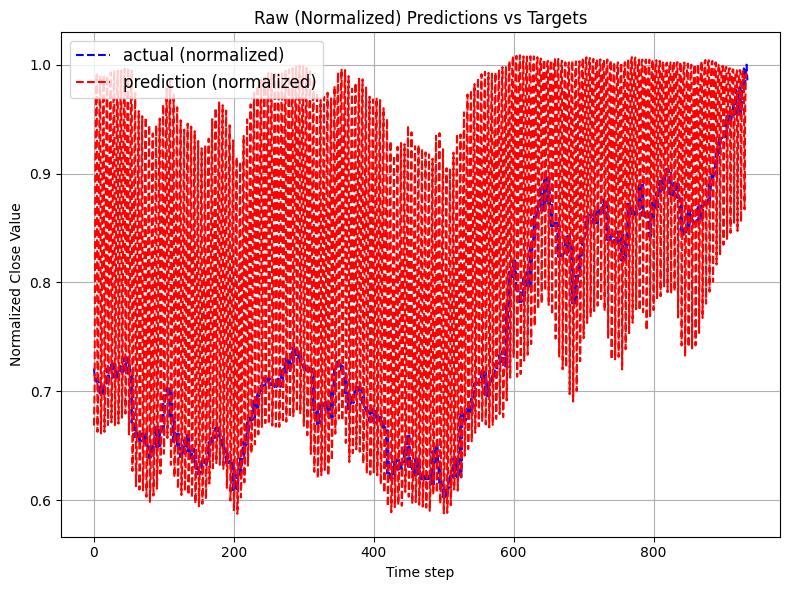

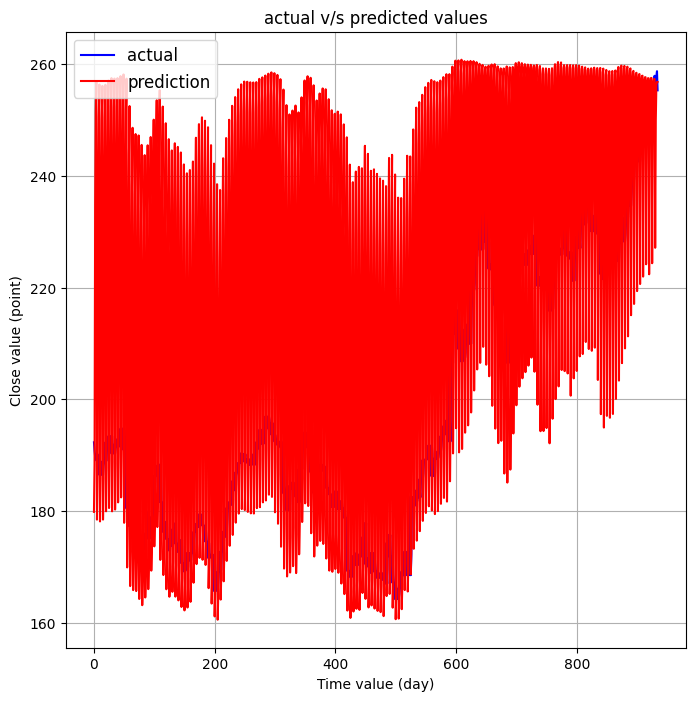

{'val_loss': 2.3683142713046967,
 'val_mae': 0.13303372263908386,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)